# The Experiment
This experiment uses custom modules in the *backend* folder, which have been specifically developed for this third-year lab. This notebook works with **pre-processed data** derived from the **13 TeV 2025 ATLAS Open Data**.

Please run the cell below to install the required packages. You will need to do this **each time you start the server**.

In [9]:
!pip install atlasopenmagic
!pip install pyarrow==20.0.0
 
from atlasopenmagic import install_from_environment
install_from_environment(environment_file="../backend/environment.yml")

Installing packages: ['aiohttp>=3.9.5', 'atlasopenmagic>=1.2.0', 'awkward>=2.8.5', 'awkward-pandas>=2023.8.0', 'fsspec>=2025.7.0', 'hist>=2.8.0', 'ipykernel>=6.29.5', 'jupyter>=1.0.0', 'lmfit>=1.3.2', 'matplotlib>=3.9.1', 'metakernel>=0.30.2', 'notebook>=7', 'numpy>=1.26.4', 'pandas>=2.2.2', 'papermill>=2.6.0', 'pip>=24.2', 'scikit-learn>=1.5.1', 'uproot>=5.3.10', 'uproot3>=3.14.4', 'fsspec-xrootd>=0.5.1', 'jupyterlab_latex>=3.1.0', 'vector>=1.4.1']
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 13.8 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 20.2 MB/s  0:00:00eta 0:00:01
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 4.5.3
    Uninstalling jupyterlab-4.5.3:
      Successfully uninstalled jupyterlab-4.5.3
  Attempting uninstall: notebook━━━━━━━━━━━━━━━━ 0/2 [jupyterlab]
    Found existing installation: notebook 7.5.3m 0/2 [jupyterlab]
    Uninstalling notebook-7.5.3:━━━━━━━━━━━━ 0/2 [jupyterlab]
      Suc

The above cell is likely to take about 30 seconds to run.  Wait until the [*] to the left of the above cell becomes a number, indicating that it has finished running.  Then, run the cell below to import the required modules and functions for the experiment. Repeat this step **every time you restart the kernel**.

In [10]:
import os
import re
import awkward as ak
import time
import datetime
from zoneinfo import ZoneInfo
import uproot
import glob
import numpy as np
import vector
import hist
from hist import Hist
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import pyarrow.parquet as pq
import sys
sys.path.append('../')
from backend import get_valid_variables, validate_read_variables
from backend import plot_stacked_hist, plot_histograms, histogram_2d, plot_errorbars
from backend import get_histogram, analysis_parquet, VALID_STR_CODE, produced_event_count

In [22]:
# debug settings:
'''
import awkward as ak
import uproot
import pyarrow
import hist
import vector
import matplotlib.pyplot as plt
import atlasopenmagic
print("imports ok")
'''



'\nimport awkward as ak\nimport uproot\nimport pyarrow\nimport hist\nimport vector\nimport matplotlib.pyplot as plt\nimport atlasopenmagic\nprint("imports ok")\n'

## Accessing Data Samples
Data samples stored in the folder *backend/parquet* can be accessed using a *string code*. The available string codes are listed below:  
#### Available Final-State Collections (Real Data)
* `'2to4lep'` - Events with two to four leptons, each with at least 7 GeV of transverse momentum $p_T$
* `'GamGam'` - Events with at least two photons, each with at least 25 GeV of $p_T$

#### Available Monte Carlo Simulation Datasets include
* `'Zee'` - Simulated $Z \rightarrow e^+e^-$ events
* `'Zmumu'` - Simulated $Z \rightarrow \mu^+\mu^-$ events
* `'Ztautau'` - Simulated $Z \rightarrow \tau^+\tau^-$ events
* `'ttbar'` - Simulated $t\overline{t}$ events
* `'Hyy'` - Simulated $H \rightarrow \gamma \gamma$ events

You can use the function `VALID_STR_CODE` to view all available string codes.

In [11]:
VALID_STR_CODE

['2to4lep',
 'Zee',
 'Zmumu',
 'Ztautau',
 'VBF_Zee',
 'VBF_Zmumu',
 'VBF_Ztautau',
 'Zee_BFil',
 'Zee_CFilBVeto',
 'Zee_CVetoBVeto',
 'Zmumu_BFil',
 'Zmumu_CFilBVeto',
 'Zmumu_CVetoBVeto',
 'Wenu',
 'Wmunu',
 'Wtaunu',
 'VBF_Wenu',
 'VBF_Wmunu',
 'VBF_Wtaunu',
 'ttbar',
 'VV4l',
 'm10_40_Zee',
 'm10_40_Zmumu',
 'ggH_H4l',
 'VBF_H4l',
 'WpH_H4l',
 'WmH_H4l',
 'ZH_H4l',
 'ggZH_H4l',
 'ttH_H4l',
 'GamGam',
 'ggF_Hyy',
 'VBF_Hyy',
 'WpH_Hyy',
 'WmH_Hyy',
 'ZH_Hyy',
 'ggZH_Hyy',
 'ttH_Hyy',
 'VBF_Zll',
 'm10_40_Zll',
 'Wlepnu',
 'VBF_Wlepnu',
 'H4l',
 'Hyy']

To combine multiple datasets, combine the string codes using `'+'`. For example, if you would like to combine the $Z \rightarrow \mu^+\mu^-$ and $Z \rightarrow e^+e^-$ datasets, use the string code `'Zee+Zmumu'`.

The sample files in the folder *backend/parquet* contain records, each of which corresponds to an individual LHC *event*. The record for each *event* contains information about the leptons and/or photons found in that event. You can view the available variables using the `get_valid_variables` function that is defined in the folder *backend*. An example is shown in the code cell below.

In [12]:
string_code = '2to4lep'
get_valid_variables(string_code)

Variables validated using ../../parquet/2to4lep/chunk_0.parquet


['lep_n',
 'lep_pt',
 'lep_eta',
 'lep_phi',
 'lep_e',
 'lep_ptvarcone30',
 'lep_topoetcone20',
 'lep_type',
 'lep_charge',
 'lep_isLooseID',
 'lep_isMediumID',
 'lep_isTightID',
 'lep_isLooseIso',
 'lep_isTightIso',
 'trigE',
 'trigM',
 'lep_isTrigMatched',
 'totalWeight']

The function `analysis_parquet` reads datasets specified by the `string_code_list` input and returns a dictionary containing the selected data. By default the selected data is stored in memory for subsequent histogramming/fitting. The parameter `fraction` determines the fraction of each dataset to load; the default value is `1`. For di-lepton analysis, it is recommended to start with `fraction = 0.01` or lower to reduce memory usage.

In [13]:
string_code_list = ['2to4lep', 'Zee'] # List of dataset codes to load
read_variables = ['lep_n', 'lep_pt']
fraction = 0.01 # Fraction of each dataset to load
# Call analysis_parquet to read the datasets and return the data as a dictionary
data = analysis_parquet(read_variables, string_code_list, fraction=fraction)
data

Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 2.6s


{'2to4lep_0_01': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='724561 * {lep_n: int32, ...'>,
 'Zee_0_01': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='450511 * {lep_n: int32, ...'>}

As shown in the example above, the `analysis_parquet` function returns a dictionary where:
- **Keys** are constructed by combining each dataset code from `string_code_list` with the `fraction` (e.g. for `2to4lep` and `fraction = 0.01`, the key is `'2to4lep_0_01`)
- **Values** are Awkward Arrays, where each entry corresponds to an event represented as a record (similar to a Python dictionary). The fields in each record correspond to the variables listed in `read_variables`.

For example, the dictionary returned by the `analysis_parquet` may look like this:
```
data = {
    '2to4lep_0_01': Array([
        {'lep_n': 2, 'lep_pt': [106, 47.6]},
        {'lep_n': 2, 'lep_pt': [41.6, 37.3]},
    ]),
    'Zee_0_01': Array([
        ...
    ])
}
```

Let's interpret the first event in the `'2to4lep_0_01'` dataset, which is represented by the first record in the Awkward Array stored under the `'2to4lep_0_01'` key (i.e., `data['2to4lep_0_01']`).
- The number of leptons in this event is 2 (`lep_n : 2`)
- The field `lep_pt` lists their transverse momenta: The first lepton has $p_T = 106$ GeV, and the second lepton has $p_T = 47.6$ GeV.

To extract the $p_T$ of the first lepton from all events in the `'2to4lep_0_01'` dataset, use  
`data['2to4lep_0_01']['lep_pt'][:, 0]`.

In [14]:
data['2to4lep_0_01']['lep_pt'][:, 0] # pT of the first lepton from all events

<Array [39.4, 45.2, 44.3, 59, ..., 10.3, 47.8, 35.4] type='724561 * float32'>

## Event Weights
For a variety of reasons each event in the MC data has an associated *weight*.  

When an event from the ATLAS experiment data is added to one of your histograms then the relevant histogram bin is incremented by 1.0.  However, when using MC events the relevant histogram bin is incremented by an amount `'totalWeight'`.  

You have access to 36 fb$^{-1}$ of real ATLAS data.  However, the MC samples for most of the physical processes have a larger number of events than would be expected in 36 fb$^{-1}$ of data.  The application of a weight (typically less than one) ensures that the total number of events you see in MC histograms is equal to that predicted for the equivalent ATLAS data set.  This calculation involves knowing the predicted cross section, $\sigma$, for each considered physical process and the integrated luminosity, $\int\mathcal{L} dt$.  The *weight* also corrects for discrepancies in experimental efficiencies between the MC simulation and the real ATLAS detector.

You don't need to explicitly include `'totalWeight'` in `read_variables`. If the field is present in the data (i.e. in MC samples), `analysis_parquet` will return it automatically.

Take a look the `EventWeights` module in the backend folder if you're curious how the variable is calculated!

**_Tip_**: Please be careful not to edit any of the code in the backend folder – unless you really know what you are doing you could cause the code to perform in unexpected ways!

## Event Selection

You can also perform event selection by defining a custom *cut function*, which can be passed to `analysis_parquet` via the argument `cut_function`. This function takes the full dataset as input and returns a filtered version according to your selection criteria. In addition, you can compute new variables within the cut function and store them in memory as new fields in the event records. 

The example below selects events with exactly two final-state leptons. It then computes the invariant mass by summing their four-momentum vectors and accessing the `.M` attribute as implemented in the `dilep_cut` function. This function is passed to the `analysis_parquet` via the `cut_function` argument.

In [7]:
#string_code_list = ['2to4lep'] # List of dataset codes to load
string_code_list = ['2to4lep', 'Zmumu', 'm10_40_Zmumu', 'Ztautau', 'ttbar', 'Wmunu'] # List of dataset codes to load
                                                                
# Variables to read from the dataset
read_variables = ['lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_type', 'lep_charge', 'lep_n', 'trigM', 'trigE']
# , 'lep_isLooseID', 'lep_isMediumID', 'lep_isLooseIso', 'lep_isTightIso', 'lep_isTrigMatched']   # other variables that could be read in

# You may also use the pre-defined function `validate_read_variables` to validate your `read_variables`. 
read_variables = validate_read_variables(string_code_list, read_variables)

# Custom selection cut function to filter the data
def pt_cut(data):
    # Cut on lepton number - Only keep events that have two leptons
    data = data[data['lep_n'] == 2] 

    # Cut on lep_type
    # lep_type is 11 for electron, 13 for muon
    data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 26] # Keep events with two muons

    # Cuts on lepton pt
    # Use bitwise operator '&' for AND, '|' for OR. Remember the parentheses!
    data = data[(data['lep_pt'][:, 0] > 10) & (data['lep_pt'][:, 1] > 10)]   # Keep events where both leptons have pt > 10 GeV

    # Require that a single muon trigger fired 
    data = data[(data['trigM'])] 

    # Define four momentum
    four_momentum = vector.zip({
        'pt': data['lep_pt'],
        'eta' : data['lep_eta'],
        'phi' : data['lep_phi'],
        'E' : data['lep_e']
    })
    # Add the 4-momentum of the two leptons in each event and get the 
    # invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    
    # Cut on di-lepton mass
    cut_low = 0
    cut_high = 1000   
    cut_mass = (data['mass']>cut_low) &  (data['mass']<cut_high)
    data = data[cut_mass] # Select events satisfying the condition: cut_low < mass < cut_high (GeV)
 
    return data

fraction = 0.02
pt_data = analysis_parquet(read_variables, string_code_list, fraction=fraction, cut_function=pt_cut)
pt_data

Variables validated using ../../parquet/2to4lep/chunk_0.parquet
Variables validated using ../../parquet/Zmumu/chunk_0.parquet
Variables validated using ../../parquet/m10_40_Zmumu/chunk_0.parquet
Variables validated using ../../parquet/Ztautau/chunk_0.parquet
Variables validated using ../../parquet/ttbar/chunk_0.parquet
Variables validated using ../../parquet/Wmunu/chunk_0.parquet
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.4s


{'2to4lep_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='573455 * {lep_n: int32, ...'>,
 'Zmumu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='877353 * {lep_n: int32, ...'>,
 'm10_40_Zmumu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='27714 * {lep_n: int32, l...'>,
 'Ztautau_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='3176 * {lep_n: int32, le...'>,
 'ttbar_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='8264 * {lep_n: int32, le...'>,
 'Wmunu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='2183 * {lep_n: int32, le...'>}

If you only need data for a specific lepton — for example, the $p_T$ of the first lepton — you can include `'lepton_pt[0]'` in `read_variables` instead of `'lepton_pt'`. This saves memory by storing the data as a flat array rather than a nested one. However, do this only if `'lepton_pt'` is not required elsewhere, such as in the cut function.

In [8]:
#electron
#string_code_list = ['2to4lep'] # List of dataset codes to load
electron_string_code_list = ['2to4lep','Zee','m10_40_Zee','Ztautau','ttbar','Wenu'] # List of dataset codes to load
read_variables = ['lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_type', 'lep_charge', 'lep_n', 'trigM', 'trigE']
electron_read_variables = validate_read_variables(electron_string_code_list, read_variables)

Variables validated using ../../parquet/2to4lep/chunk_0.parquet
Variables validated using ../../parquet/Zee/chunk_0.parquet
Variables validated using ../../parquet/m10_40_Zee/chunk_0.parquet
Variables validated using ../../parquet/Ztautau/chunk_0.parquet
Variables validated using ../../parquet/ttbar/chunk_0.parquet
Variables validated using ../../parquet/Wenu/chunk_0.parquet


In [9]:
# muon
def base_mumu(data):
    data = data[data['lep_n'] == 2]
    data = data[data['lep_type'][:,0] + data['lep_type'][:,1] == 26]
    data = data[(data['lep_pt'][:,0] > 10) & (data['lep_pt'][:,1] > 10)]
    data = data[data['trigM']]
    four_momentum = vector.zip({
        'pt':  data['lep_pt'],
        'eta': data['lep_eta'],
        'phi': data['lep_phi'],
        'E':   data['lep_e']
    })
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    return data
def cut_muOppositeSign(data):
    data = base_mumu(data)
    q0 = data['lep_charge'][:, 0]
    q1 = data['lep_charge'][:, 1]
    return data[(q0 * q1) == -1]

def cut_muSameSign(data):
    data = base_mumu(data)
    q0 = data['lep_charge'][:, 0]
    q1 = data['lep_charge'][:, 1]
    return data[(q0 * q1) == +1]

In [10]:
fraction = 0.02
pt_data_mu_OS = analysis_parquet(read_variables, string_code_list, fraction=fraction, cut_function=cut_muOppositeSign)
pt_data_mu_SS = analysis_parquet(read_variables, string_code_list, fraction=fraction, cut_function=cut_muSameSign)

Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.3s
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.1s


In [11]:
#electron
def base_ee(data):
    data = data[data['lep_n'] == 2]
    data = data[data['lep_type'][:,0] + data['lep_type'][:,1] == 22]
    data = data[(data['lep_pt'][:,0] > 10) & (data['lep_pt'][:,1] > 10)]
    data = data[data['trigE']]
    four_momentum = vector.zip({
        'pt':  data['lep_pt'],
        'eta': data['lep_eta'],
        'phi': data['lep_phi'],
        'E':   data['lep_e']
    })
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    return data
def cut_eeOppositeSign(data):
    data = base_ee(data)
    q0 = data['lep_charge'][:, 0]
    q1 = data['lep_charge'][:, 1]
    return data[(q0 * q1) == -1]

def cut_eeSameSign(data):
    data = base_ee(data)
    q0 = data['lep_charge'][:, 0]
    q1 = data['lep_charge'][:, 1]
    return data[(q0 * q1) == +1]

In [12]:
#electron
fraction = 0.02
pt_data_ee_OS = analysis_parquet(electron_read_variables, electron_string_code_list, fraction=fraction, cut_function=cut_eeOppositeSign)
pt_data_ee_SS = analysis_parquet(electron_read_variables, electron_string_code_list, fraction=fraction, cut_function=cut_eeSameSign)

Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.1s
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.1s


## Plot Stacked Histogram
The dictionary returned by `analysis_parquet` can be used to plot a stacked histogram by passing it to the `plot_stacked_hist` function.

To use this function correctly, there are a few points to take note of:
- The first argument must be a **dictionary**.
- If a dictionary key includes `'Data'`, its content will be plotted as data points with error bars.
- If a dictionary key includes `'Signal'`, its content will be stacked as histogram bars on top of the background.
- Python strings are case-sensitive, i.e. `'Data'` and `'data'` are treated differently!

An example is shown below, where `'2to4lep_0_01'` is treated as data and `'Zee_0_01'` as the signal.

Elapsed time = 0.4s


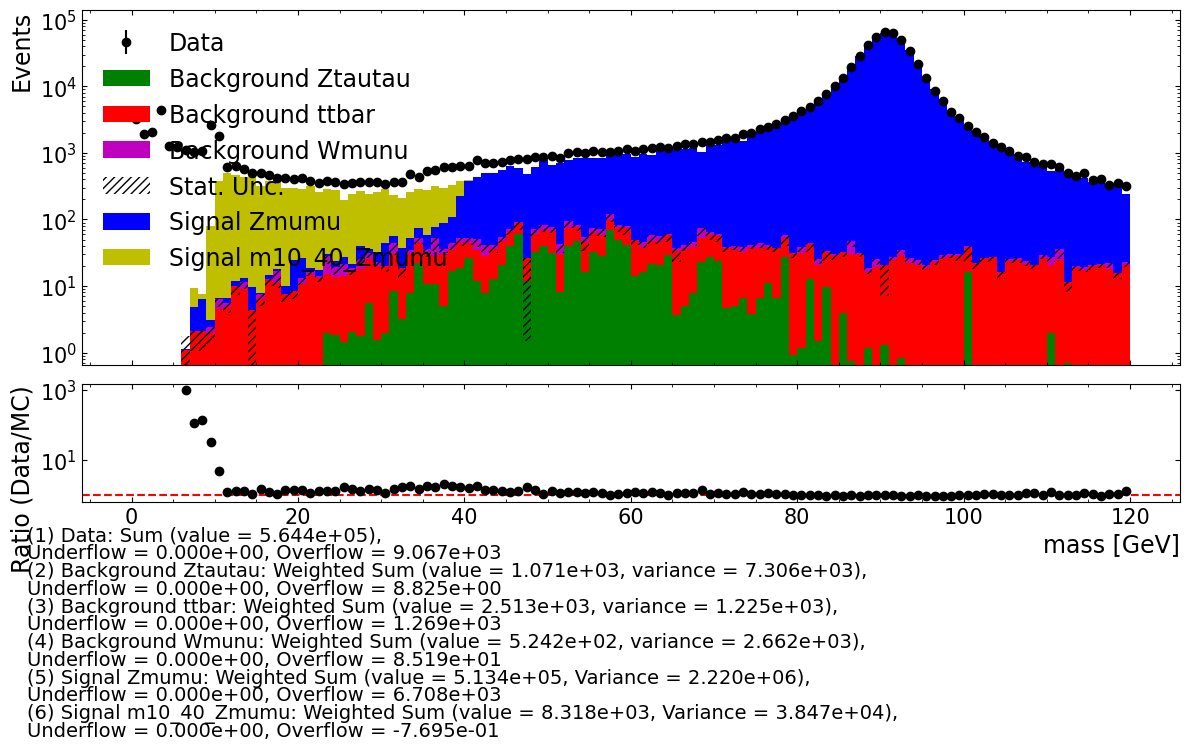

In [13]:
# Example Plot
# Define what to plot: '2to4lep_0_01' as data, 'Zee_0_01' as signal
plot_dict = {
    'Data' : pt_data['2to4lep_0_02'],
    'Signal Zmumu' : pt_data['Zmumu_0_02'], 
    'Signal m10_40_Zmumu' : pt_data['m10_40_Zmumu_0_02'], 
    'Background Ztautau': pt_data['Ztautau_0_02'],
    'Background ttbar' : pt_data['ttbar_0_02'], 
    'Background Wmunu' : pt_data['Wmunu_0_02'],
}

# Define plot appearance
#color_list = ['k'] # Black (data)
color_list = ['k', 'b', 'y', 'g', 'r', 'm'] # Black (data), blue (signal), yellow (signal), green (Ztautau), red (ttbar), magenta (Wmunu')

# Variable to plot on the x-axis
plot_variable = 'mass'

xmin, xmax = 0, 120 # Define histogram bin range and x-axis limits 
num_bins = 120 # Number of histogram bins
x_label = 'mass [GeV]' # x-axis label 

# Plot the histogram
fig, hists = plot_stacked_hist(plot_dict, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label, logy=True, show_text=True, residual_plot=True, save_fig=False)

The `plot_stacked_hist` function accepts several optional parameters that allow you to customise the appearance and behaviour of the plot:
- `y_label` : Label for the y-axis
- `ylim` : Tuple of two numbers for y-axis limits
- `logy` : Set to `True` to use a logarithmic y-axis
- `title` : Title of the plot
- `marker` : Marker style for the data points (default: `'o'`)
- `fig_size` : Tuple of two numbers for the figure size (default: `(12, 8)`)
- `show_text` : Set to `True` to display text annotations (histogram information) on the plot
- `show_back_unc` : Set to `False` to hide background uncertainty
- `save_fig` : Set to `True` to save the figure
- `fig_name` : String filename to save the plot as an image
- `residual_plot` : Set to `True` to add a residual plot (Data / MC) below the main plot
- `residual_plot_ylim` : Tuple of two numbers for residual plot y-axis limits
- `title_fontsize` : Font size for the plot title (default: 17)
- `label_fontsize` : Font size for the x and y axis labels (default: 17)
- `legend_fontsize` : Font size for the legend (default: 17)
- `tick_labelsize` : Font size for the axis tick labels  (default: 15)
- `text_fontsize` : Font size for text annotations (default: 14)

The function returns a `Figure` object and a **list** of `Hist` objects corresponding to each dataset. 

---
## Code for muon and e

Elapsed time = 0.2s


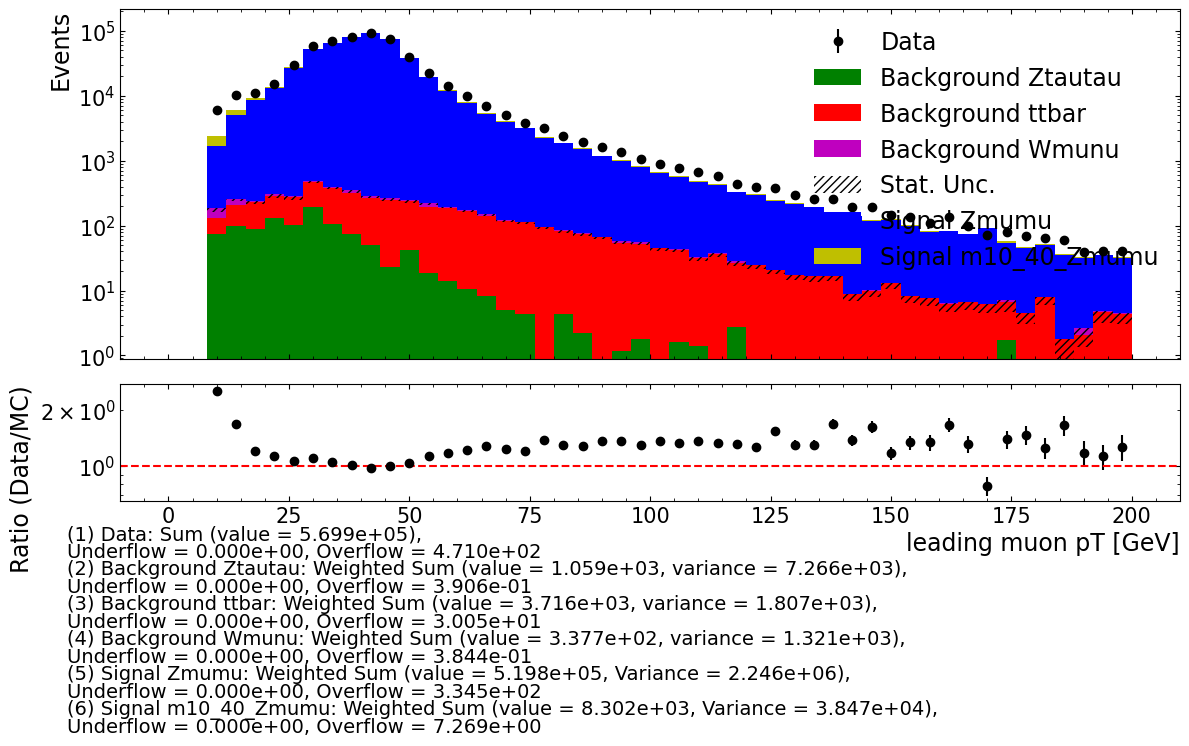

In [14]:
#muon OS pt
plot_dict_mu_OS = {
  'Data' : pt_data_mu_OS['2to4lep_0_02'],
  'Signal Zmumu' : pt_data_mu_OS['Zmumu_0_02'],
  'Signal m10_40_Zmumu' : pt_data_mu_OS['m10_40_Zmumu_0_02'],
  'Background Ztautau' : pt_data_mu_OS['Ztautau_0_02'],
  'Background ttbar' : pt_data_mu_OS['ttbar_0_02'],
  'Background Wmunu' : pt_data_mu_OS['Wmunu_0_02'],
}

color_list = ['k','b','y','g','r','m']

plot_variable = 'lep_pt[0]'
xmin, xmax = 0, 200
num_bins = 50
x_label = 'leading muon pT [GeV]'

fig_mu_ospt, hists_mu_ospt= plot_stacked_hist(plot_dict_mu_OS, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label,
                               logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/muon_OS_pt.png"
)

Elapsed time = 0.1s


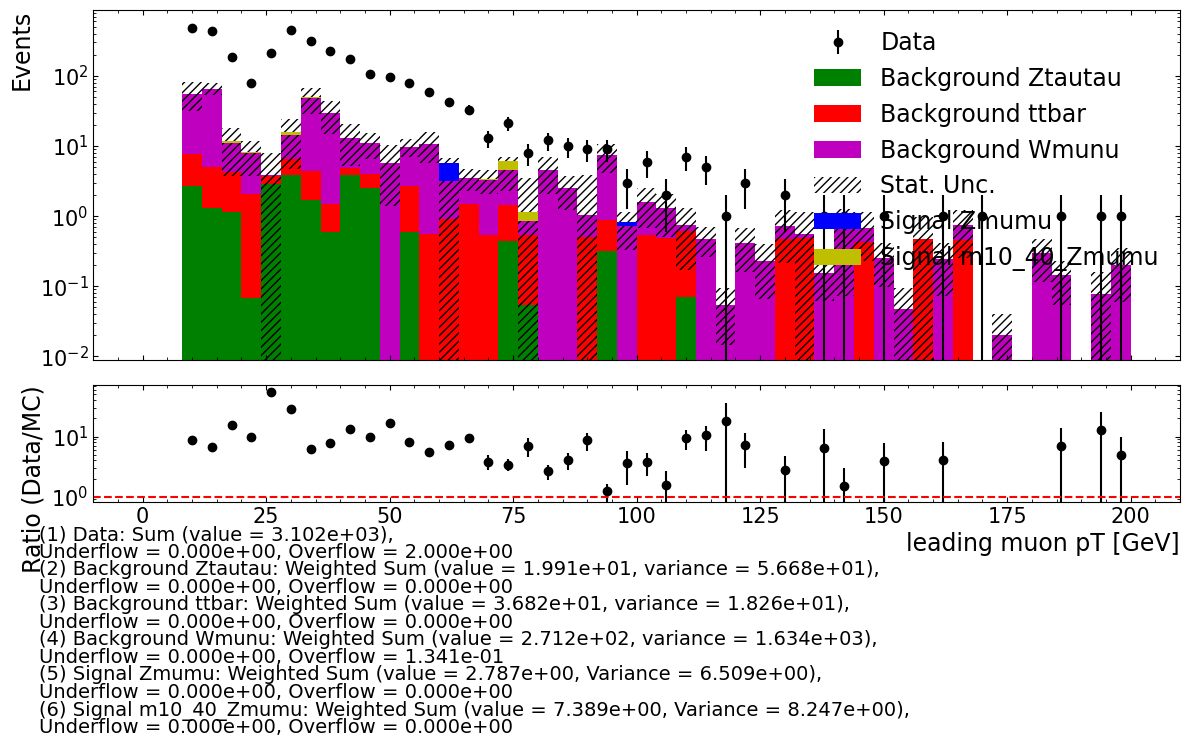

In [15]:
#muon SS pt
plot_dict_mu_SS = {
  'Data' : pt_data_mu_SS['2to4lep_0_02'],
  'Signal Zmumu' : pt_data_mu_SS['Zmumu_0_02'],
  'Signal m10_40_Zmumu' : pt_data_mu_SS['m10_40_Zmumu_0_02'],
  'Background Ztautau' : pt_data_mu_SS['Ztautau_0_02'],
  'Background ttbar' : pt_data_mu_SS['ttbar_0_02'],
  'Background Wmunu' : pt_data_mu_SS['Wmunu_0_02'],
}

color_list = ['k','b','y','g','r','m']

plot_variable = 'lep_pt[0]'
xmin, xmax = 0, 200
num_bins = 50
x_label = 'leading muon pT [GeV]'

fig_mu_sspt, hists_mu_sspt = plot_stacked_hist(plot_dict_mu_SS, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label,
                               logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/muon_SS_pt.png"
)

Elapsed time = 0.2s


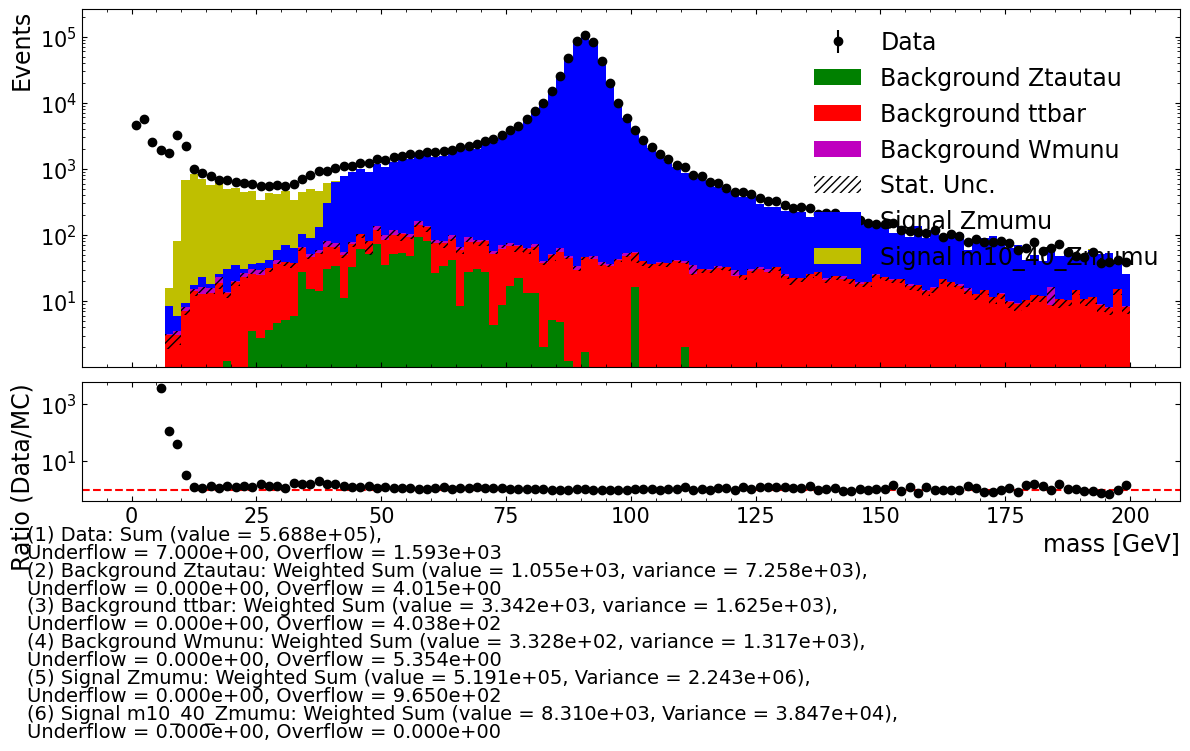

In [16]:
#muon OS mass
plot_variable = 'mass'
xmin, xmax = 0, 200
num_bins = 120
x_label = 'mass [GeV]'

fig_mu_osm, hists_mu_osm = plot_stacked_hist(plot_dict_mu_OS, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label,
                               logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/muon_OS_mass.png"
)

Elapsed time = 0.3s


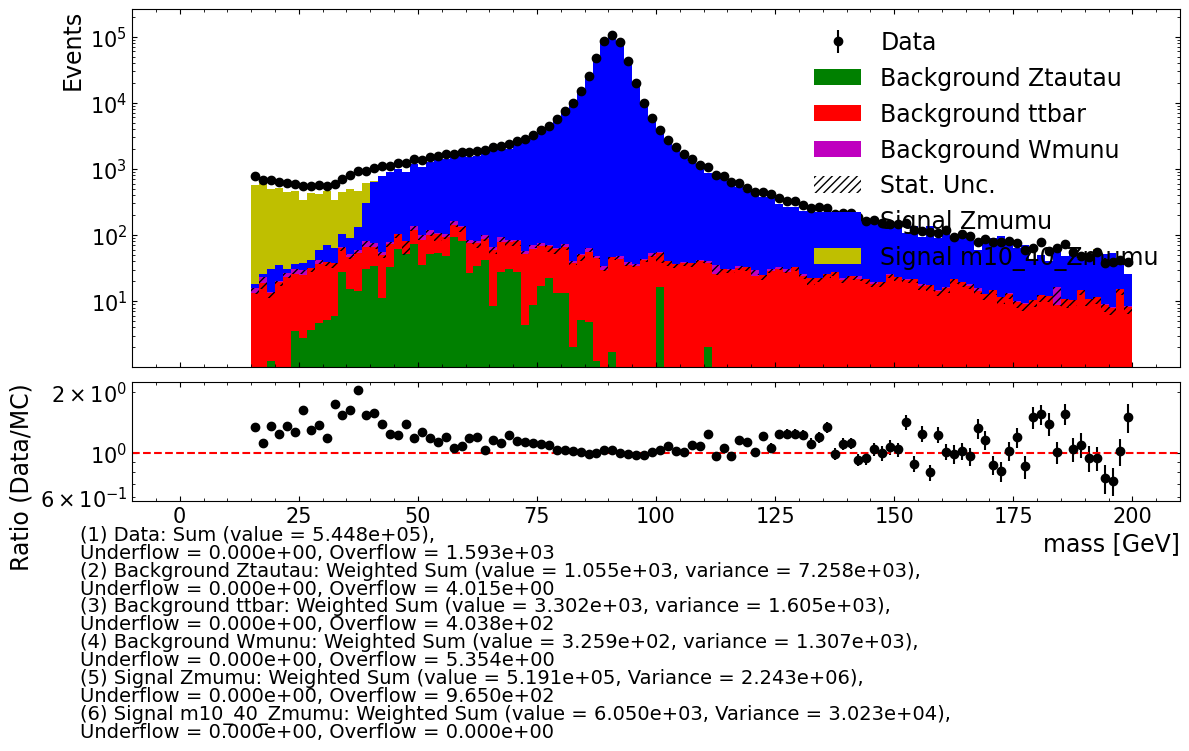

In [17]:
# muon OS mass (apply low-mass cut)
plot_variable = 'mass'
xmin, xmax = 0, 200
num_bins = 120
x_label = 'mass [GeV]'

mass_low = 15  # 例如只保留 mll > 20 GeV

plot_dict_mu_OS_cut = {
    k: v[v['mass'] > mass_low] for k, v in plot_dict_mu_OS.items()
}

fig_mu_osm, hists_mu_osm = plot_stacked_hist(
    plot_dict_mu_OS_cut, plot_variable, color_list,
    num_bins, xmin, xmax, x_label,
    logy=True, show_text=True, residual_plot=True, save_fig=False
)


Elapsed time = 0.2s


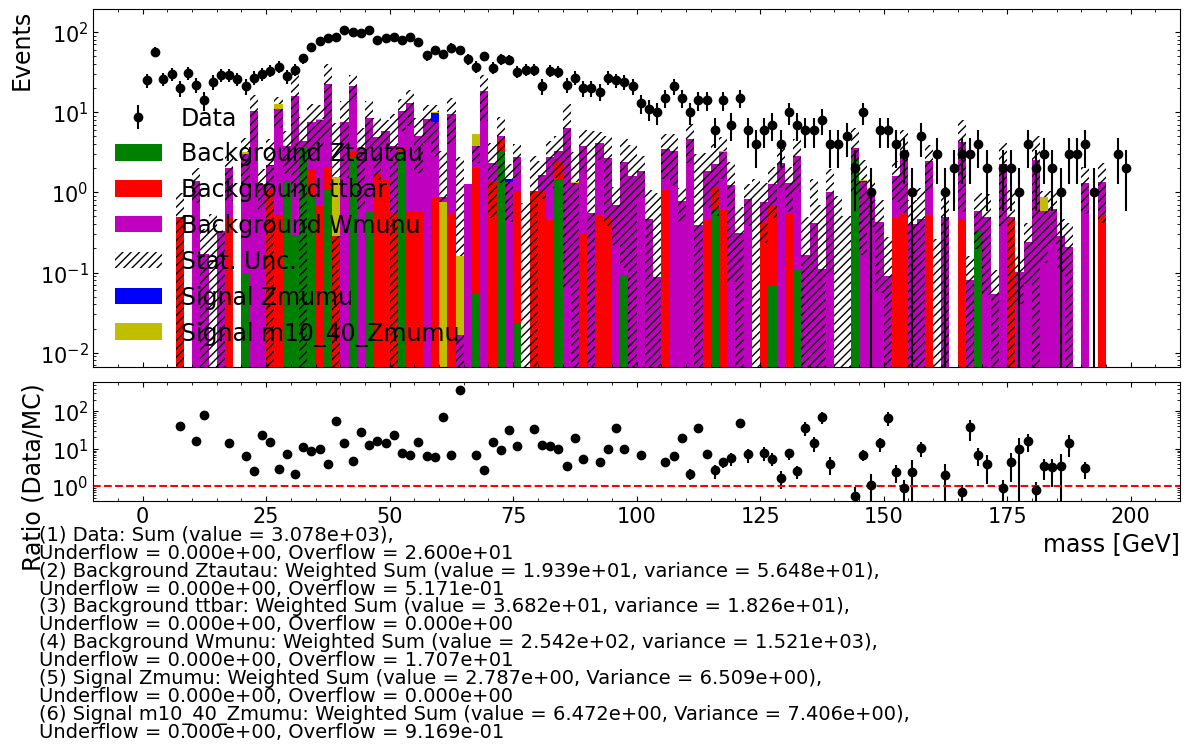

In [18]:
#muon SS mass
plot_variable = 'mass'
xmin, xmax = 0, 200
num_bins = 120
x_label = 'mass [GeV]'

fig_mu_ssm, hists_mu_ssm = plot_stacked_hist(plot_dict_mu_SS, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label,
                               logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/muon_SS_mass.png"
)

Elapsed time = 0.2s


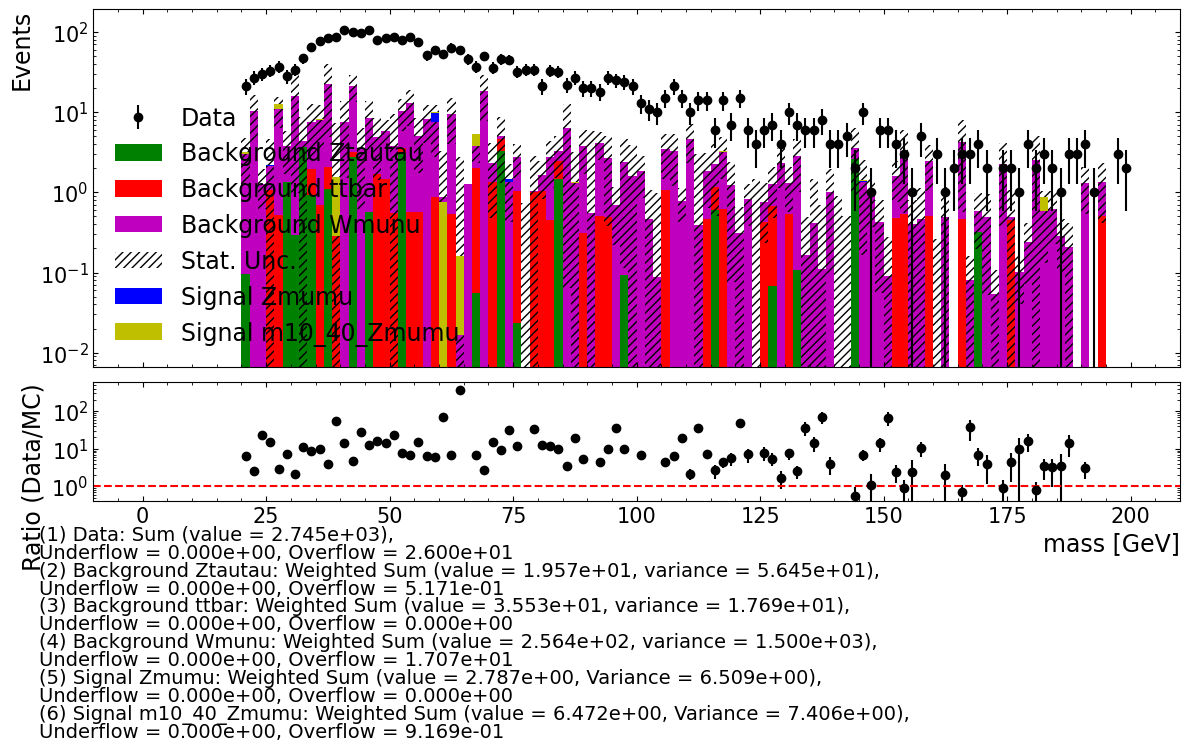

In [19]:
# muon SS mass (apply low-mass cut)
plot_variable = 'mass'
xmin, xmax = 0, 200
num_bins = 120
x_label = 'mass [GeV]'

mass_low = 20  # 例如只保留 mll > 20 GeV

plot_dict_mu_SS_cut = {
    k: v[v['mass'] > mass_low] for k, v in plot_dict_mu_SS.items()
}

fig_mu_ssm, hists_mu_ssm = plot_stacked_hist(
    plot_dict_mu_SS_cut, plot_variable, color_list,
    num_bins, xmin, xmax, x_label,
    logy=True, show_text=True, residual_plot=True, save_fig=False
)


Elapsed time = 0.2s


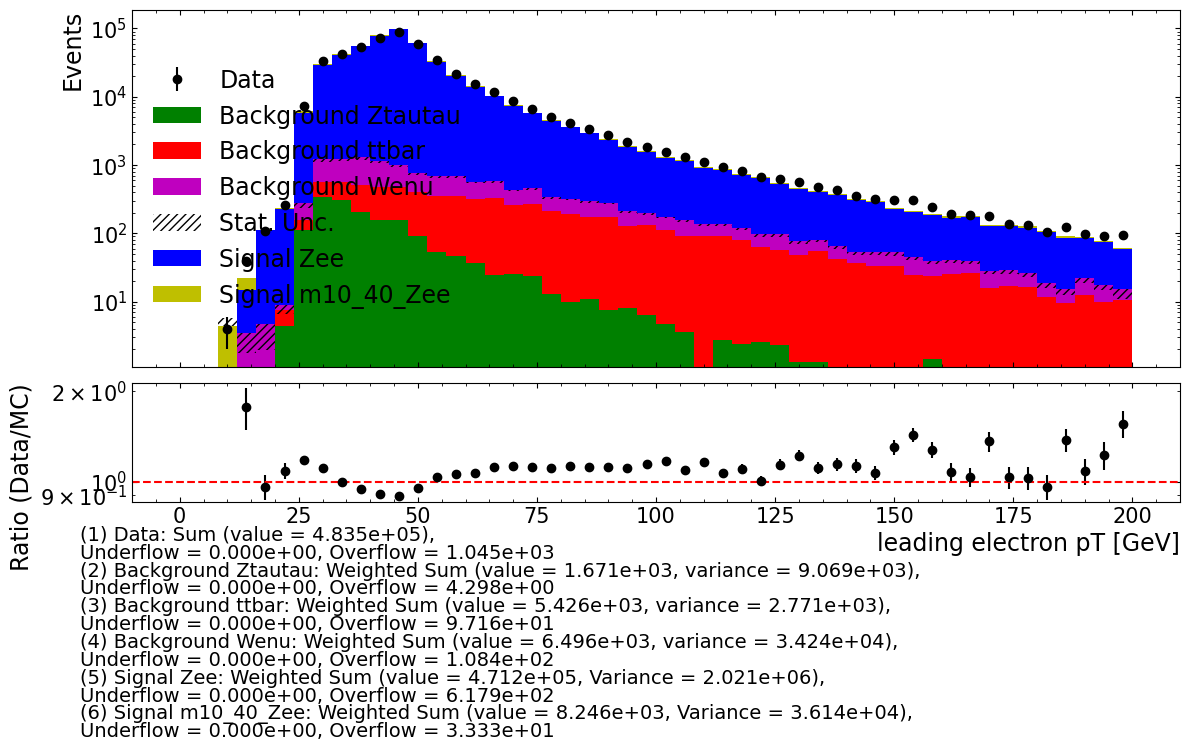

In [20]:
#electron_ospt
plot_dict_ee_OS = {
  'Data' : pt_data_ee_OS['2to4lep_0_02'],
  'Signal Zee' : pt_data_ee_OS['Zee_0_02'],
  'Signal m10_40_Zee' : pt_data_ee_OS['m10_40_Zee_0_02'],
  'Background Ztautau' : pt_data_ee_OS['Ztautau_0_02'],
  'Background ttbar' : pt_data_ee_OS['ttbar_0_02'],
  'Background Wenu' : pt_data_ee_OS['Wenu_0_02'],
}

color_list = ['k','b','y','g','r','m']

plot_variable = 'lep_pt[0]'
xmin, xmax = 0, 200
num_bins = 50
x_label = 'leading electron pT [GeV]'

fig_ee_ospt, hists_ee_ospt= plot_stacked_hist(plot_dict_ee_OS, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label,
                               logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/e_OS_pt.png"
)

Elapsed time = 0.1s


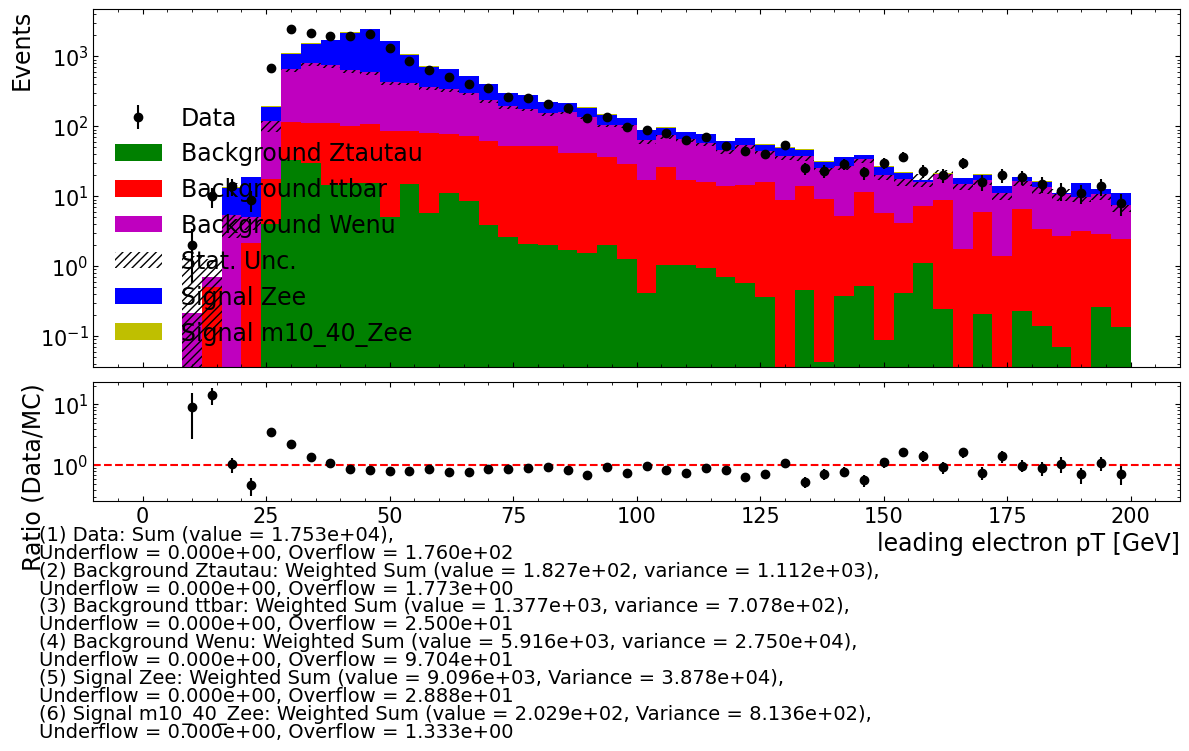

In [21]:
#electron_sspt
plot_dict_ee_SS = {
  'Data' : pt_data_ee_SS['2to4lep_0_02'],
  'Signal Zee' : pt_data_ee_SS['Zee_0_02'],
  'Signal m10_40_Zee' : pt_data_ee_SS['m10_40_Zee_0_02'],
  'Background Ztautau' : pt_data_ee_SS['Ztautau_0_02'],
  'Background ttbar' : pt_data_ee_SS['ttbar_0_02'],
  'Background Wenu' : pt_data_ee_SS['Wenu_0_02'],
}

color_list = ['k','b','y','g','r','m']

plot_variable = 'lep_pt[0]'
xmin, xmax = 0, 200
num_bins = 50
x_label = 'leading electron pT [GeV]'

fig_ee_sspt, hists_ee_sspt= plot_stacked_hist(plot_dict_ee_SS, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label,
                               logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/e_SS_pt.png")

Elapsed time = 0.2s


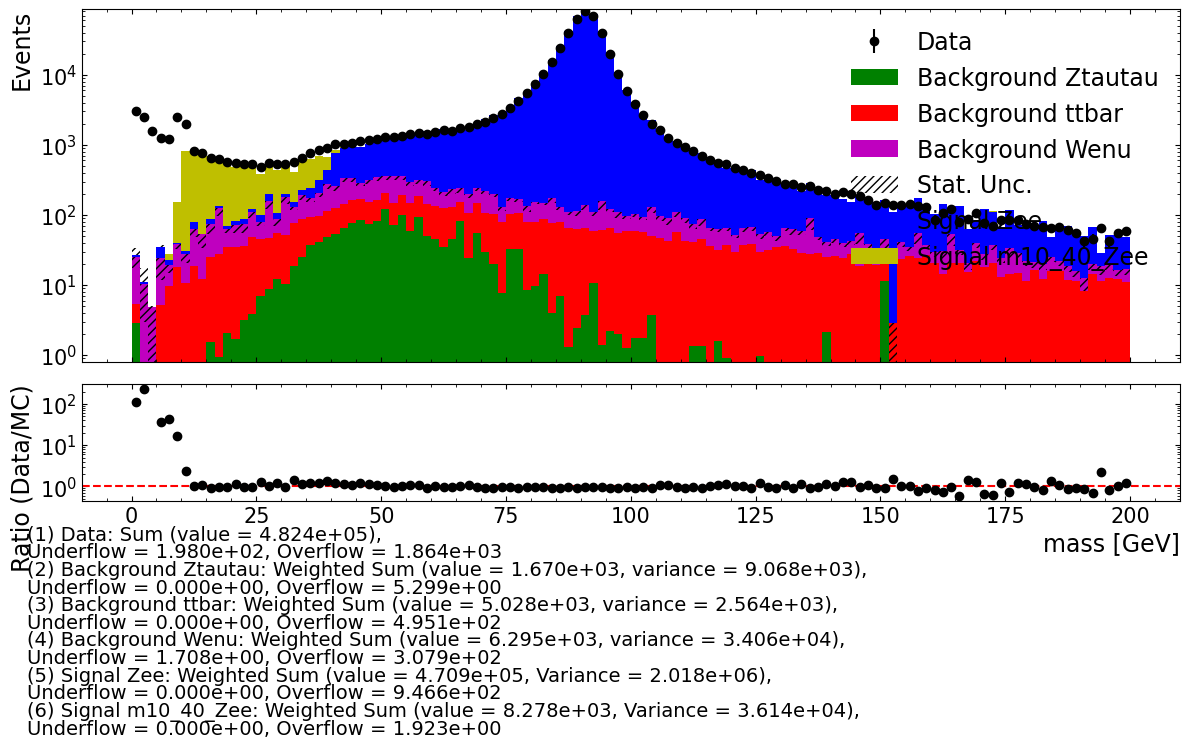

In [22]:
#electron OS mass
plot_variable = 'mass'
xmin, xmax = 0, 200
num_bins = 120
x_label = 'mass [GeV]'

fig_ee_osm, hists_ee_osm = plot_stacked_hist(plot_dict_ee_OS, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label,
                               logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/e_OS_mass.png")

Elapsed time = 0.2s


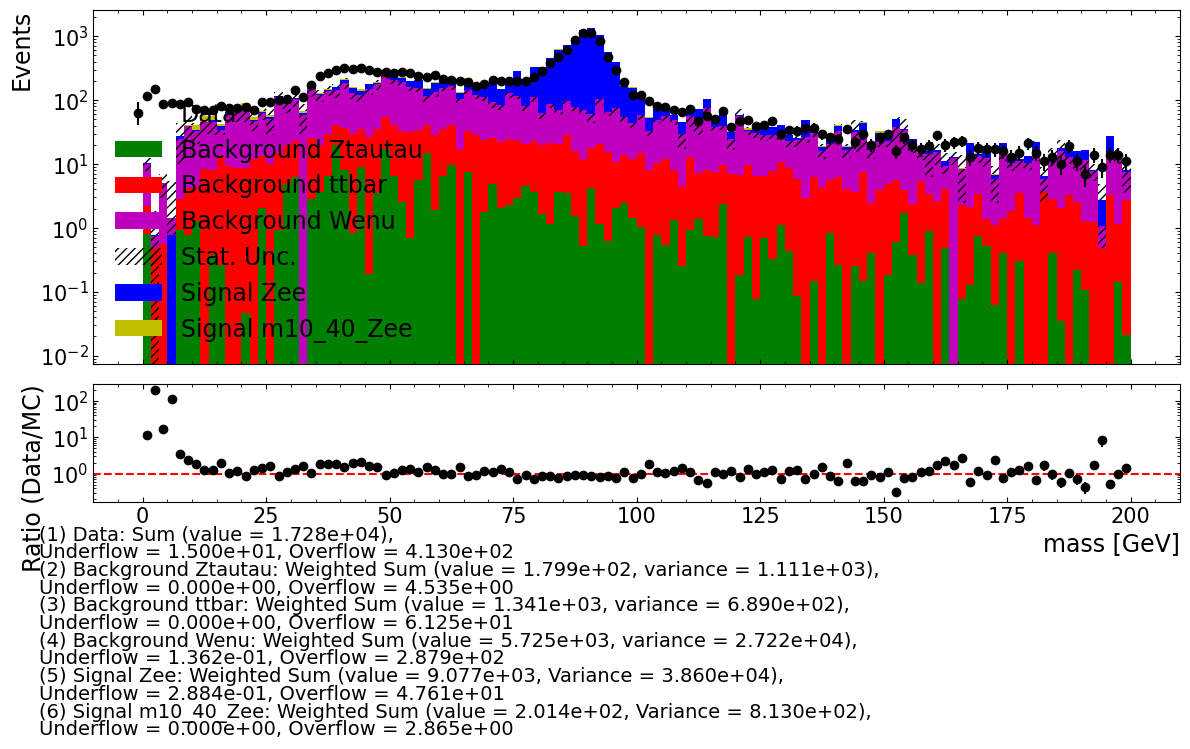

In [23]:
#electron SS mass
plot_variable = 'mass'
xmin, xmax = 0, 200
num_bins = 120
x_label = 'mass [GeV]'

fig_ee_ssm, hists_ee_ssm = plot_stacked_hist(plot_dict_ee_SS, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label,
                               logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/e_SS_mass.png")

Variables validated using ../../parquet/2to4lep/chunk_0.parquet
Skipping 'lep_etcone20' - invalid input for string code '2to4lep'
Variables validated using ../../parquet/Zmumu/chunk_0.parquet
Skipping 'lep_etcone20' - invalid input for string code 'Zmumu'
Variables validated using ../../parquet/m10_40_Zmumu/chunk_0.parquet
Skipping 'lep_etcone20' - invalid input for string code 'm10_40_Zmumu'
Variables validated using ../../parquet/Ztautau/chunk_0.parquet
Skipping 'lep_etcone20' - invalid input for string code 'Ztautau'
Variables validated using ../../parquet/ttbar/chunk_0.parquet
Skipping 'lep_etcone20' - invalid input for string code 'ttbar'
Variables validated using ../../parquet/Wmunu/chunk_0.parquet
Skipping 'lep_etcone20' - invalid input for string code 'Wmunu'
Variables validated using ../../parquet/2to4lep/chunk_0.parquet
Skipping 'lep_etcone20' - invalid input for string code '2to4lep'
Variables validated using ../../parquet/Zee/chunk_0.parquet
Skipping 'lep_etcone20' - invali

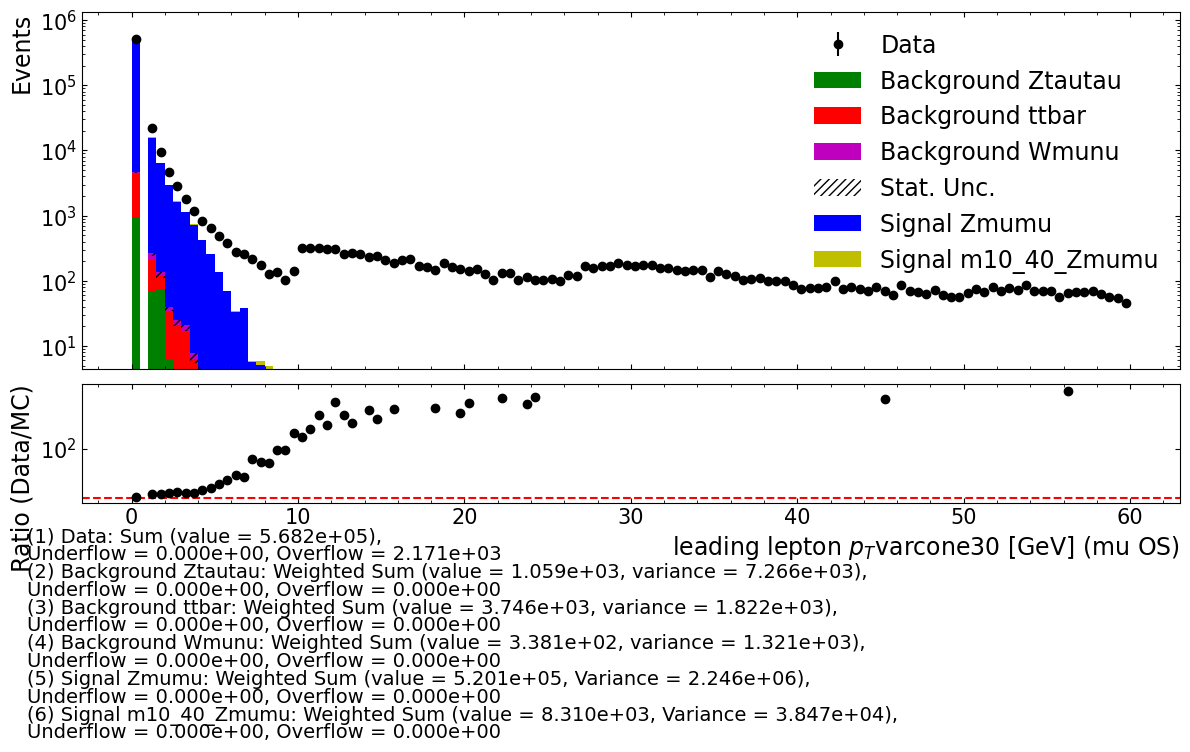

Elapsed time = 0.2s


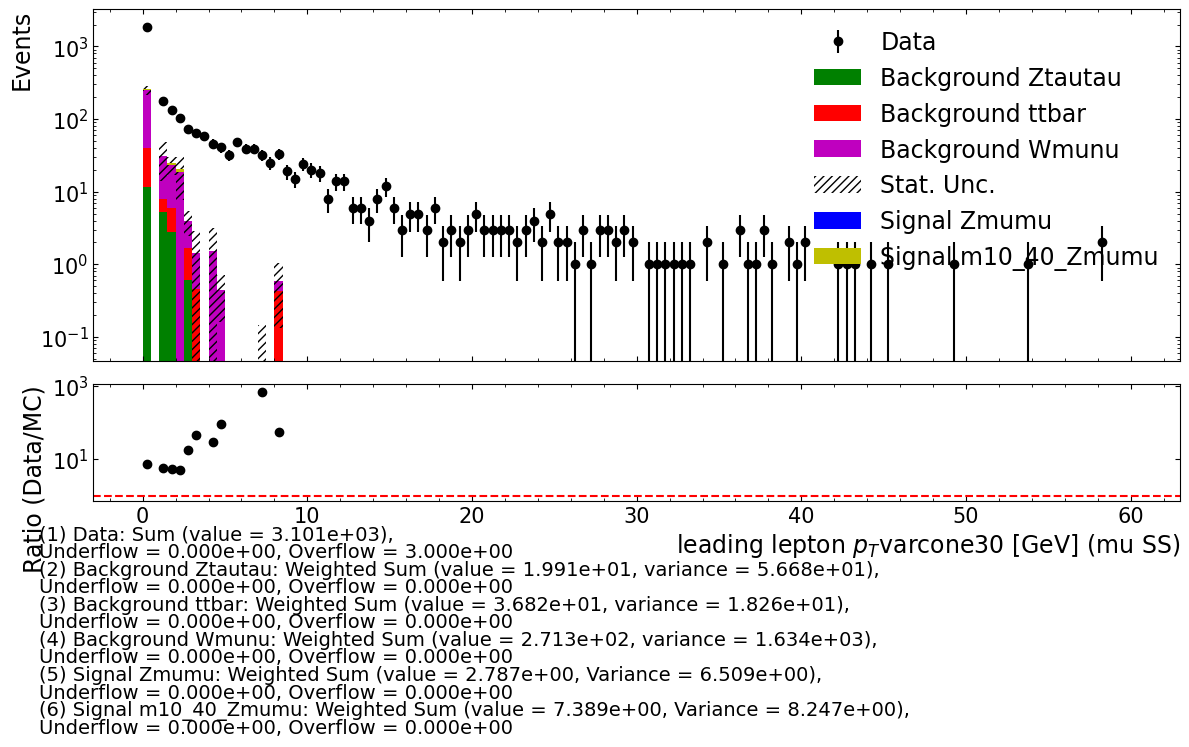

Elapsed time = 0.3s


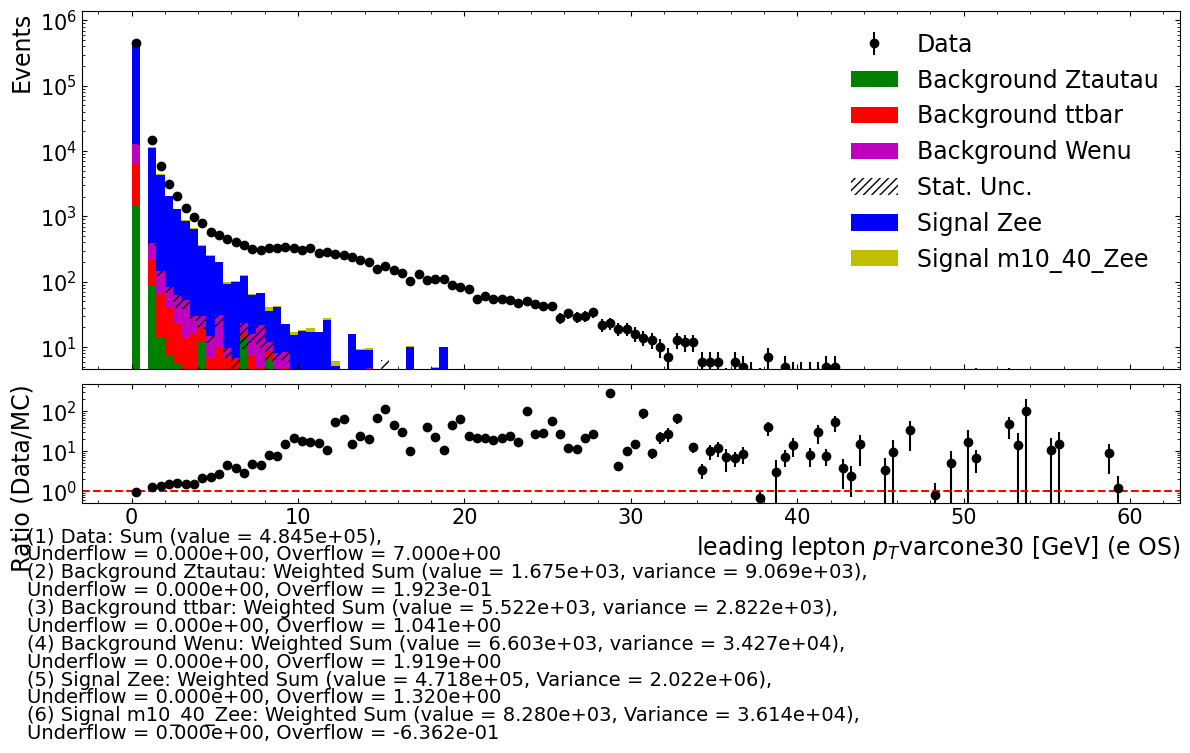

Elapsed time = 0.2s


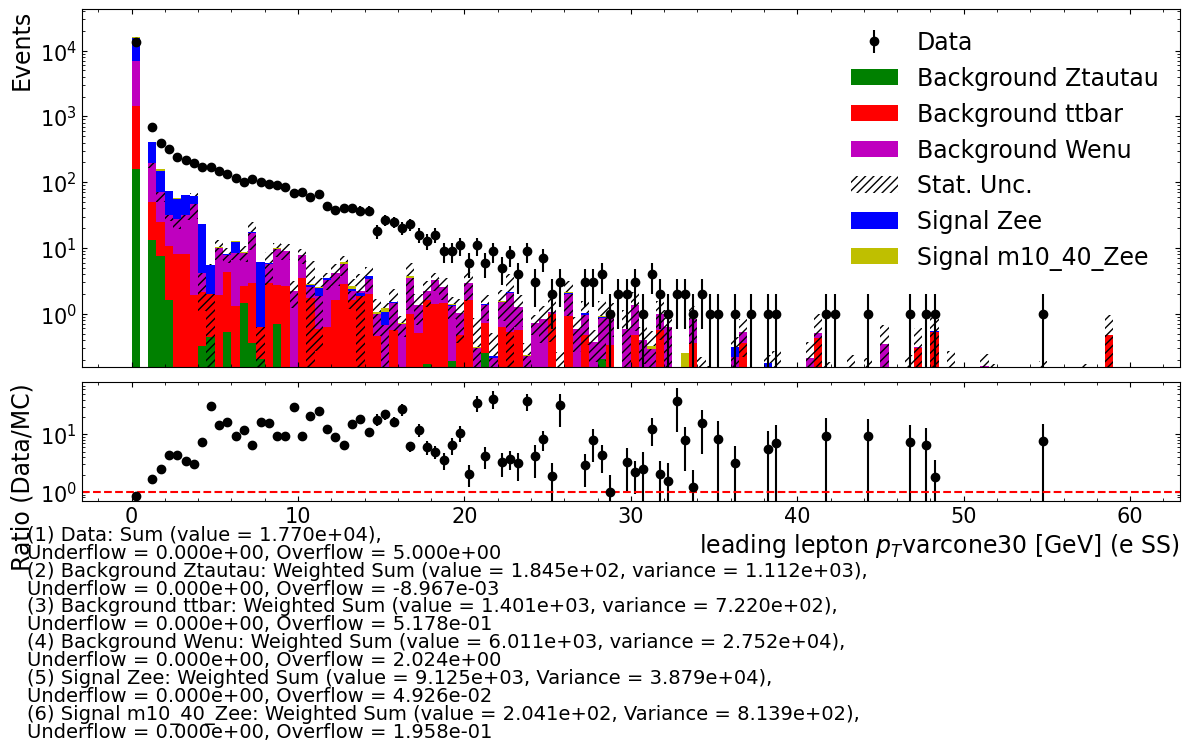

In [61]:
# =========================
# Plot pT cone (lep_ptvarcone30) distributions for muon+electron, OS+SS
# =========================

# 0) We will read one extra variable: lep_ptvarcone30 (track isolation) and etcone
cone_var = ['lep_ptvarcone30', 'lep_etcone20']

# Make sure read variable lists include lep_ptvarcone30
mu_read_variables_cone = validate_read_variables(string_code_list, list(read_variables) + cone_var)
ee_read_variables_cone = validate_read_variables(electron_string_code_list, list(electron_read_variables) + cone_var)

# 1) Re-run analysis_parquet so the returned data actually contains lep_ptvarcone30
#    (cut functions can stay the same as you already defined: cut_muOppositeSign, cut_muSameSign, etc.)
ptcone_mu_OS = analysis_parquet(mu_read_variables_cone, string_code_list, fraction=fraction, cut_function=cut_muOppositeSign)
ptcone_mu_SS = analysis_parquet(mu_read_variables_cone, string_code_list, fraction=fraction, cut_function=cut_muSameSign)

ptcone_ee_OS = analysis_parquet(ee_read_variables_cone, electron_string_code_list, fraction=fraction, cut_function=cut_eeOppositeSign)
ptcone_ee_SS = analysis_parquet(ee_read_variables_cone, electron_string_code_list, fraction=fraction, cut_function=cut_eeSameSign)

# 2) Build the correct key suffix from fraction (e.g. 0.02 -> "0_02")
frac_key = f"{fraction:.2f}".replace(".", "_")

# 3) plot_dicts (same structure as your pT/mass plots)
plot_dict_mu_OS_cone = {
    'Data' : ptcone_mu_OS[f'2to4lep_{frac_key}'],
    'Signal Zmumu' : ptcone_mu_OS.get(f'Zmumu_{frac_key}'),
    'Signal m10_40_Zmumu' : ptcone_mu_OS.get(f'm10_40_Zmumu_{frac_key}'),
    'Background Ztautau' : ptcone_mu_OS.get(f'Ztautau_{frac_key}'),
    'Background ttbar' : ptcone_mu_OS.get(f'ttbar_{frac_key}'),
    'Background Wmunu' : ptcone_mu_OS.get(f'Wmunu_{frac_key}'),
}

plot_dict_mu_SS_cone = {
    'Data' : ptcone_mu_SS[f'2to4lep_{frac_key}'],
    'Signal Zmumu' : ptcone_mu_SS.get(f'Zmumu_{frac_key}'),
    'Signal m10_40_Zmumu' : ptcone_mu_SS.get(f'm10_40_Zmumu_{frac_key}'),
    'Background Ztautau' : ptcone_mu_SS.get(f'Ztautau_{frac_key}'),
    'Background ttbar' : ptcone_mu_SS.get(f'ttbar_{frac_key}'),
    'Background Wmunu' : ptcone_mu_SS.get(f'Wmunu_{frac_key}'),
}

plot_dict_ee_OS_cone = {
    'Data' : ptcone_ee_OS[f'2to4lep_{frac_key}'],
    'Signal Zee' : ptcone_ee_OS.get(f'Zee_{frac_key}'),
    'Signal m10_40_Zee' : ptcone_ee_OS.get(f'm10_40_Zee_{frac_key}'),
    'Background Ztautau' : ptcone_ee_OS.get(f'Ztautau_{frac_key}'),
    'Background ttbar' : ptcone_ee_OS.get(f'ttbar_{frac_key}'),
    'Background Wenu' : ptcone_ee_OS.get(f'Wenu_{frac_key}'),
}

plot_dict_ee_SS_cone = {
    'Data' : ptcone_ee_SS[f'2to4lep_{frac_key}'],
    'Signal Zee' : ptcone_ee_SS.get(f'Zee_{frac_key}'),
    'Signal m10_40_Zee' : ptcone_ee_SS.get(f'm10_40_Zee_{frac_key}'),
    'Background Ztautau' : ptcone_ee_SS.get(f'Ztautau_{frac_key}'),
    'Background ttbar' : ptcone_ee_SS.get(f'ttbar_{frac_key}'),
    'Background Wenu' : ptcone_ee_SS.get(f'Wenu_{frac_key}'),
}

# 4) Plot settings
color_list = ['k','b','y','g','r','m']

# leading lepton ptcone
plot_variable = 'lep_ptvarcone30[0]'   # change to [1] for subleading
xmin, xmax = 0, 60
num_bins = 120

# 5) Make the plots in a nice sequence
x_label = r'leading lepton $p_T$varcone30 [GeV]'

# muon OS
fig_mu_os_cone, _ = plot_stacked_hist(plot_dict_mu_OS_cone, plot_variable, color_list,
                                      num_bins, xmin, xmax, x_label + " (mu OS)",
                                      logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/muon_OS_cone.png"
)

# muon SS
fig_mu_ss_cone, _ = plot_stacked_hist(plot_dict_mu_SS_cone, plot_variable, color_list,
                                      num_bins, xmin, xmax, x_label + " (mu SS)",
                                      logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/muon_SS_cone.png"
)

# electron OS
fig_ee_os_cone, _ = plot_stacked_hist(plot_dict_ee_OS_cone, plot_variable, color_list,
                                      num_bins, xmin, xmax, x_label + " (e OS)",
                                      logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/e_OS_cone.png"
)

# electron SS
fig_ee_ss_cone, _ = plot_stacked_hist(plot_dict_ee_SS_cone, plot_variable, color_list,
                                      num_bins, xmin, xmax, x_label + " (e SS)",
                                      logy=True, show_text=True, residual_plot=True, save_fig=True, fig_name="/Users/thomas/Chty/Softwares/VS Code Project/Jupyter Notebook/ATLAS-Higgs-ZW/Output/e_SS_cone.png"
)

# Tip: if everything is squashed near 0, try xmax=20 or switch logy=False for a closer look.

In [62]:
# =========================
# Apply isolation cut using lep_ptvarcone30
# =========================

import awkward as ak

iso_max = 5.0      # ptvarcone30 cut
etcone_max = 5.0   # topoetcone20 cut（先随便试 5 GeV，后面可以scan）
require_both = True    # True: 两条 lepton 都要 isolated；False: 只 cut leading

def apply_iso_cut(events, iso_max=iso_max, require_both=require_both):
    """events: awkward array (one dataset). return filtered events."""
    if events is None:
        return None

    if require_both:
        mask = (events["lep_ptvarcone30"][:, 0] < iso_max) & (events["lep_ptvarcone30"][:, 1] < iso_max)
    else:
        mask = (events["lep_ptvarcone30"][:, 0] < iso_max)

    return events[mask]

def apply_iso_to_plotdict(plot_dict, iso_max=iso_max, require_both=require_both):
    """plot_dict: {'Data': events, 'Signal ...': events, ...}"""
    out = {}
    for k, v in plot_dict.items():
        out[k] = apply_iso_cut(v, iso_max=iso_max, require_both=require_both)
    return out

# Apply to the 4 channels you built in cell 39
plot_dict_mu_OS_cone_iso = apply_iso_to_plotdict(plot_dict_mu_OS_cone)
plot_dict_mu_SS_cone_iso = apply_iso_to_plotdict(plot_dict_mu_SS_cone)
plot_dict_ee_OS_cone_iso = apply_iso_to_plotdict(plot_dict_ee_OS_cone)
plot_dict_ee_SS_cone_iso = apply_iso_to_plotdict(plot_dict_ee_SS_cone)


Elapsed time = 0.2s


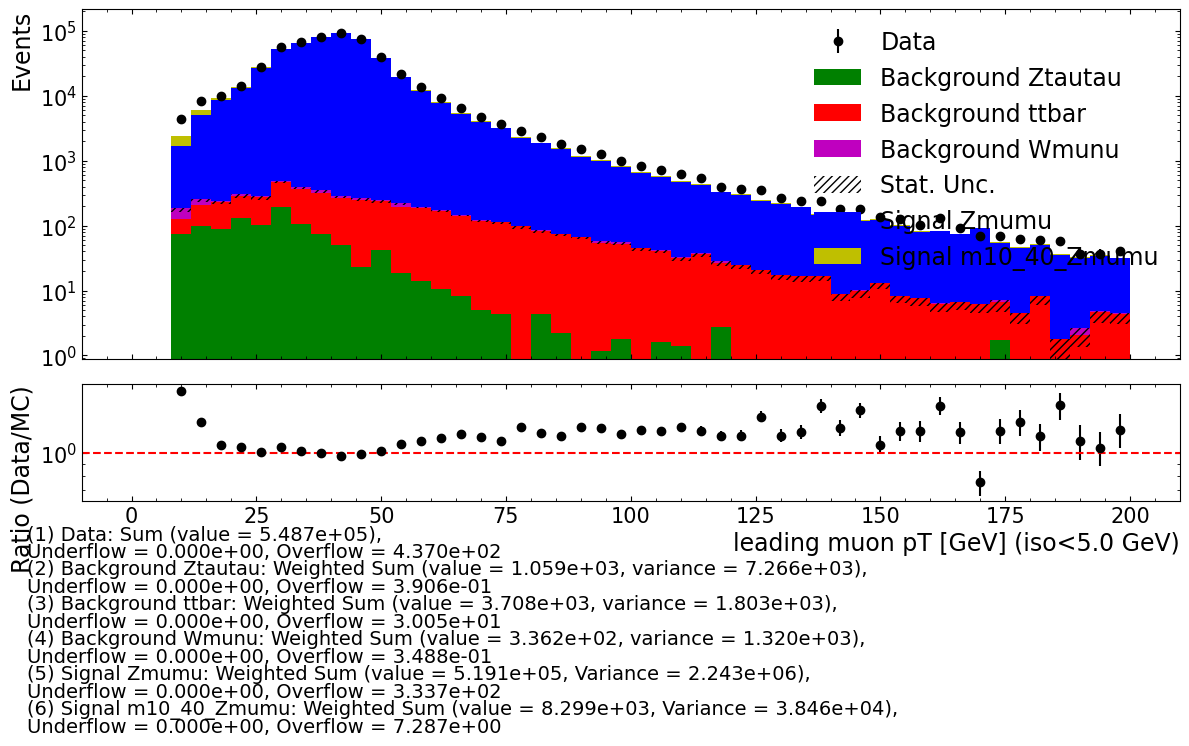

Elapsed time = 0.2s


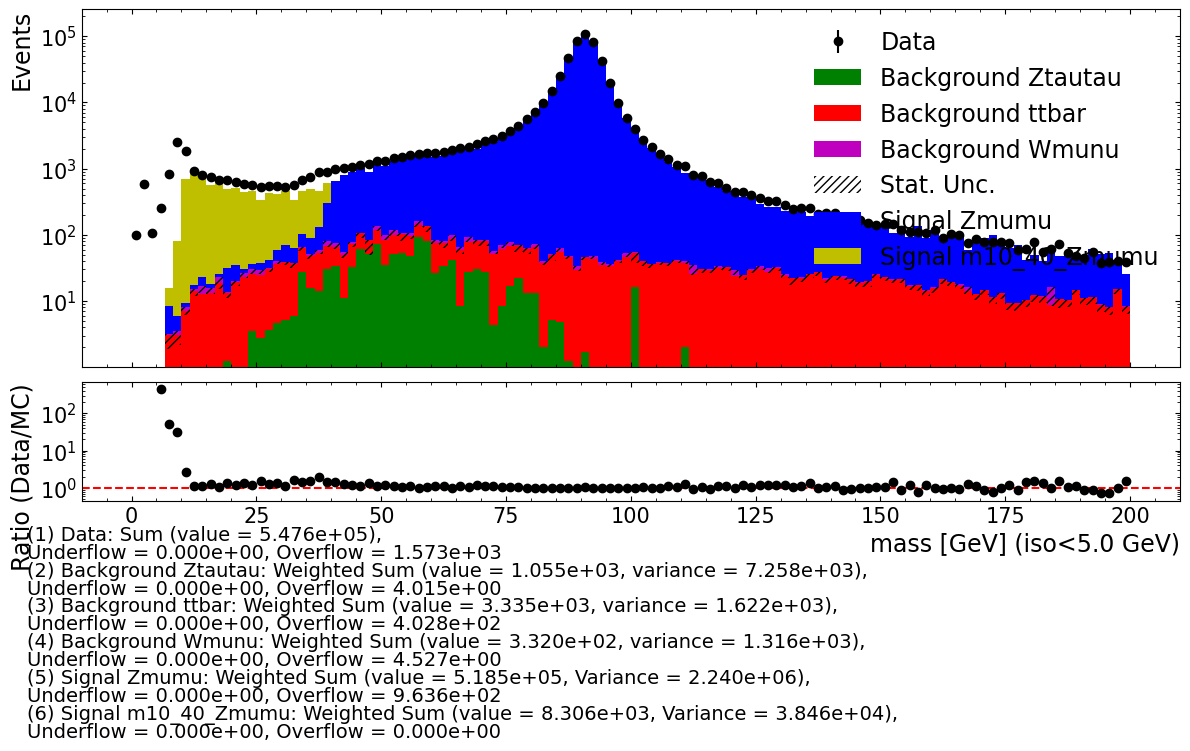

In [27]:
## Plot mu OS：leading muon pT（加了 iso cut）
plot_variable = 'lep_pt[0]'
xmin, xmax = 0, 200
num_bins = 50
x_label = f'leading muon pT [GeV] (iso<{iso_max} GeV)'

fig_mu_ospt_iso, hists_mu_ospt_iso = plot_stacked_hist(
    plot_dict_mu_OS_cone_iso, plot_variable, color_list,
    num_bins, xmin, xmax, x_label,
    logy=True, show_text=True, residual_plot=True, save_fig=False
)

## Plot mu OS：leading muon mass（加了 iso cut）
plot_variable = 'mass'
xmin, xmax = 0, 200
num_bins = 120
x_label = f'mass [GeV] (iso<{iso_max} GeV)'

fig_mu_osm_iso, hists_mu_osm_iso = plot_stacked_hist(
    plot_dict_mu_OS_cone_iso, plot_variable, color_list,
    num_bins, xmin, xmax, x_label,
    logy=True, show_text=True, residual_plot=True, save_fig=False
)


In [28]:
## Analysis

def get_yield(events, is_data=False):
    if events is None:
        return 0.0
    if is_data:
        return float(len(events))
    # MC: sum of weights
    if "totalWeight" in events.fields:
        return float(ak.sum(events["totalWeight"]))
    return float(len(events))

def summarize(plot_dict):
    N_data = get_yield(plot_dict.get("Data"), is_data=True)
    N_sig  = sum(get_yield(v) for k, v in plot_dict.items() if k.startswith("Signal"))
    N_bkg  = sum(get_yield(v) for k, v in plot_dict.items() if k.startswith("Background"))
    SB = N_sig / N_bkg if N_bkg > 0 else float("inf")
    return N_data, N_sig, N_bkg, SB

print("Before iso cut (mu OS):", summarize(plot_dict_mu_OS_cone))
print("After  iso cut (mu OS):", summarize(plot_dict_mu_OS_cone_iso))

iso_values = [2.0, 3.0, 5.0, 10.0]
rows = []
for iso in iso_values:
    d = apply_iso_to_plotdict(plot_dict_mu_OS_cone, iso_max=iso, require_both=True)
    N_data, N_sig, N_bkg, SB = summarize(d)
    rows.append((iso, N_data, N_sig, N_bkg, SB))

import pandas as pd
df = pd.DataFrame(rows, columns=["iso_max [GeV]", "Data", "Signal", "Background", "S/B"])
df


Before iso cut (mu OS): (570369.0, 528405.6373256169, 5143.18206196322, 102.73904966994645)
After  iso cut (mu OS): (549152.0, 527738.6042775235, 5133.739726210614, 102.798083351036)


iso_max [GeV]      Data         Signal   Background         S/B
0            2.0  525509.0  512865.598704  4886.889392  104.947249
1            3.0  540241.0  522341.243721  5060.701100  103.215194
2            5.0  549152.0  527738.604278  5133.739726  102.798083
3           10.0  553662.0  528400.761368  5143.098482  102.739771

## Apply low mass cut

Elapsed time = 0.1s


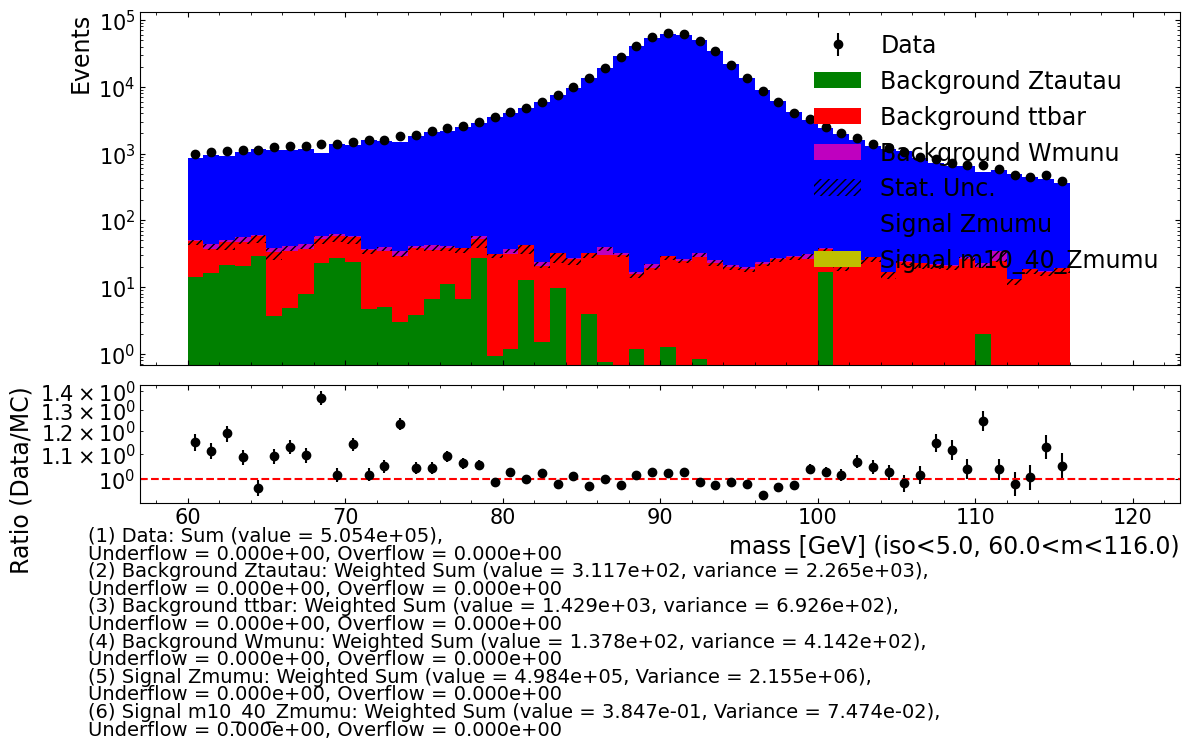

In [65]:
import awkward as ak

iso_max = 5.0
mmin, mmax = 60.0, 116.0     # Z window；如果要更紧可以改成 80, 100
require_both = True

def apply_iso_mass_cut(events, iso_max=iso_max, mmin=mmin, mmax=mmax, require_both=require_both):
    if events is None:
        return None

    if require_both:
        mask = (events["lep_ptvarcone30"][:, 0] < iso_max) & (events["lep_ptvarcone30"][:, 1] < iso_max)
    else:
        mask = (events["lep_ptvarcone30"][:, 0] < iso_max)

    mask = mask & (events["mass"] > mmin) & (events["mass"] < mmax)
    return events[mask]

def apply_to_plotdict(plot_dict):
    return {k: apply_iso_mass_cut(v) for k, v in plot_dict.items()}

plot_dict_mu_OS_final = apply_to_plotdict(plot_dict_mu_OS_cone)

fig, hists = plot_stacked_hist(
    plot_dict_mu_OS_final,
    'mass',
    color_list,
    num_bins=60,
    xmin=60, xmax=120,
    x_label=f'mass [GeV] (iso<{iso_max}, {mmin}<m<{mmax})',
    logy=True,
    show_text=True,
    residual_plot=True,
    save_fig=False
)


---
## 整理

In [42]:
## Unified selection:

import awkward as ak
import numpy as np
import pandas as pd

def select_events(events, iso_max=None, mass_window=None, require_both=True):
    """Return events after applying optional isolation + mass window cuts."""
    if events is None:
        return None
    
    # start with all True mask
    mask = ak.Array(np.ones(len(events), dtype=bool))

    # isolation cut
    if iso_max is not None:
        if require_both:
            mask = mask & (events["lep_ptvarcone30"][:, 0] < iso_max) & (events["lep_ptvarcone30"][:, 1] < iso_max)
        else:
            mask = mask & (events["lep_ptvarcone30"][:, 0] < iso_max)

    # mass window cut
    if mass_window is not None:
        lo, hi = mass_window
        mask = mask & (events["mass"] > lo) & (events["mass"] < hi)

    return events[mask]


def select_plotdict(plot_dict, **kwargs):
    """Apply selection to every dataset in plot_dict."""
    out = {}
    for k, v in plot_dict.items():
        out[k] = select_events(v, **kwargs) if v is not None else None
    return out


def yield_data(events):
    return 0.0 if events is None else float(len(events))


def yield_mc(events):
    if events is None:
        return 0.0
    if "totalWeight" in events.fields:
        return float(ak.sum(events["totalWeight"]))
    return float(len(events))


def summarize_plotdict(plot_dict):
    """Return Data, Signal, Background, S/B, Data/MC (MC = Signal+Background)."""
    n_data = yield_data(plot_dict.get("Data"))

    n_sig = 0.0
    n_bkg = 0.0
    for k, v in plot_dict.items():
        if k.startswith("Signal"):
            n_sig += yield_mc(v)
        if k.startswith("Background"):
            n_bkg += yield_mc(v)

    n_mc = n_sig + n_bkg
    sb = n_sig / n_bkg if n_bkg > 0 else np.inf
    d_over_mc = n_data / n_mc if n_mc > 0 else np.nan
    return n_data, n_sig, n_bkg, sb, d_over_mc



In [44]:
## Analsis for muon OS channel:
mass_win = (66.0, 116.0)
iso_choice = 5.0
require_both = True

steps = [
    ("Baseline (mu OS)", dict()),
    (f"Iso only (iso<{iso_choice})", dict(iso_max=iso_choice)),
    ("Mass window only (66<m<116)", dict(mass_window=mass_win)),
    (f"Iso + Mass window", dict(iso_max=iso_choice, mass_window=mass_win)),
]

rows = []
for name, kw in steps:
    d = select_plotdict(plot_dict_mu_OS_cone, require_both=require_both, **kw)
    n_data, n_sig, n_bkg, sb, dmc = summarize_plotdict(d)
    rows.append([name, n_data, n_sig, n_bkg, sb, dmc])

df_cutflow = pd.DataFrame(rows, columns=["Step", "Data", "Signal", "Background", "S/B", "Data/MC"])
df_cutflow


Step      Data         Signal   Background  \
0             Baseline (mu OS)  570369.0  528405.637326  5143.182062   
1           Iso only (iso<5.0)  549152.0  527738.604278  5133.739726   
2  Mass window only (66<m<116)  502352.0  493269.408136  1579.983659   
3            Iso + Mass window  498799.0  492625.583890  1576.939197   

          S/B   Data/MC  
0  102.739050  1.069010  
1  102.798083  1.030551  
2  312.199057  1.015161  
3  312.393518  1.009301

Elapsed time = 0.3s


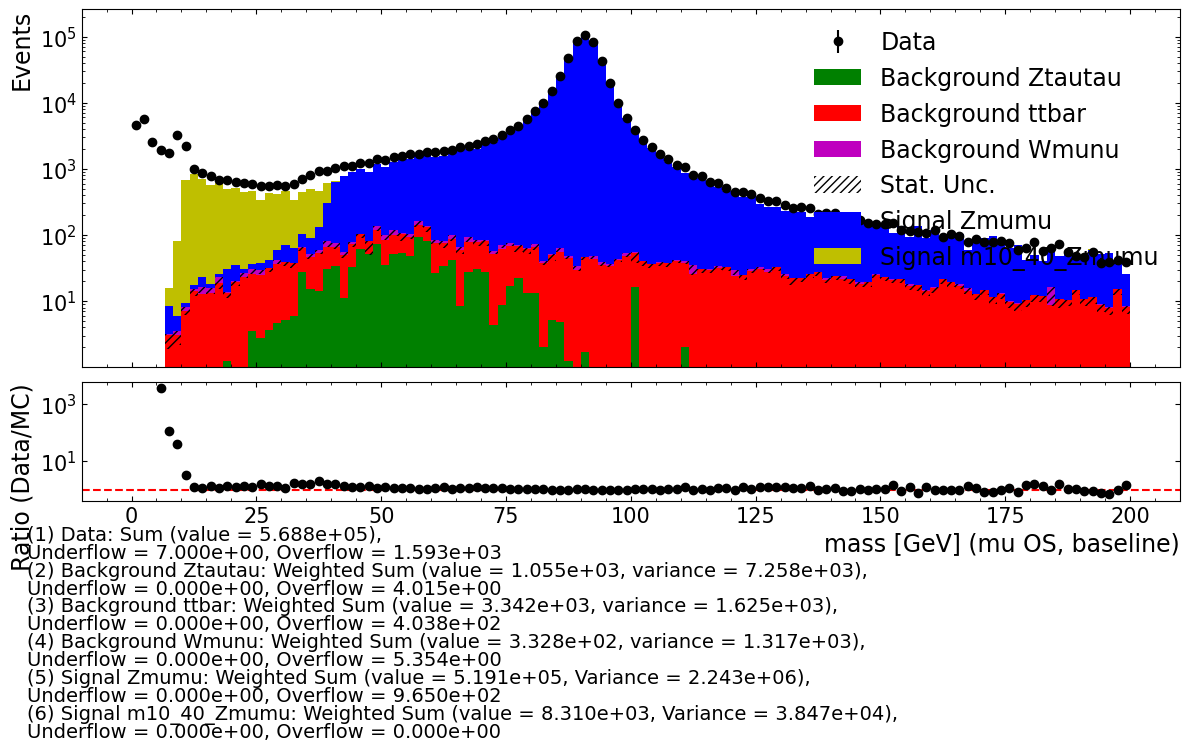

Elapsed time = 0.1s


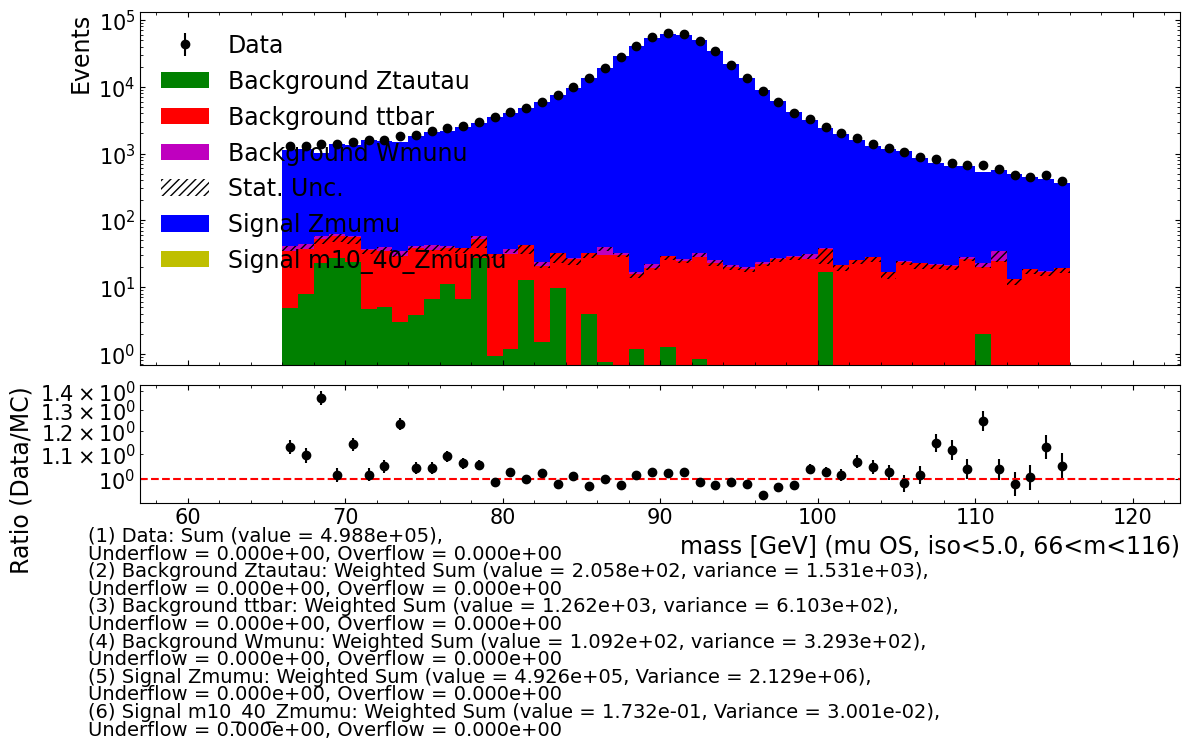

In [48]:
#Plot for conparison:
fig_before, _ = plot_stacked_hist(
    plot_dict_mu_OS_cone,
    "mass",
    color_list,
    num_bins=120, xmin=0, xmax=200,
    x_label="mass [GeV] (mu OS, baseline)",
    logy=True, show_text=True, residual_plot=True, save_fig=False
)
plot_dict_mu_OS_final = select_plotdict(
    plot_dict_mu_OS_cone,
    iso_max=iso_choice,
    mass_window=mass_win,
    require_both=True
)

fig_after, _ = plot_stacked_hist(
    plot_dict_mu_OS_final,
    "mass",
    color_list,
    num_bins=60, xmin=60, xmax=120,
    x_label=f"mass [GeV] (mu OS, iso<{iso_choice}, 66<m<116)",
    logy=True, show_text=True, residual_plot=True, save_fig=False
)


In [46]:
## Identify best cut

iso_values = [1.0, 2.0, 3.0, 5.0, 7.0, 10.0]

# reference: OS signal yield in Z window without iso
os_ref = select_plotdict(plot_dict_mu_OS_cone, mass_window=mass_win, require_both=True)
_, s_ref, _, _, _ = summarize_plotdict(os_ref)

# reference: SS data yield in Z window without iso (background proxy)
ss_ref = select_plotdict(plot_dict_mu_SS_cone, mass_window=mass_win, require_both=True)
dss_ref, _, _, _, _ = summarize_plotdict(ss_ref)

rows = []
for iso in iso_values:
    os_sel = select_plotdict(plot_dict_mu_OS_cone, iso_max=iso, mass_window=mass_win, require_both=True)
    ss_sel = select_plotdict(plot_dict_mu_SS_cone, iso_max=iso, mass_window=mass_win, require_both=True)

    dos, sos, bos, sbos, dmc_os = summarize_plotdict(os_sel)
    dss, sss, bss, sbss, dmc_ss = summarize_plotdict(ss_sel)

    sig_eff = sos / s_ref if s_ref > 0 else np.nan
    ss_rej = 1.0 - (dss / dss_ref) if dss_ref > 0 else np.nan  # larger = better

    rows.append([iso, sig_eff, sbos, dmc_os, dss, ss_rej])

df_scan = pd.DataFrame(
    rows,
    columns=["iso_max", "OS sig efficiency", "OS S/B", "OS Data/MC", "SS Data", "SS rejection"]
)

df_scan


iso_max  OS sig efficiency      OS S/B  OS Data/MC  SS Data  SS rejection
0      1.0           0.890544  351.291383    0.967556    282.0      0.625995
1      2.0           0.970013  324.092382    0.997117    379.0      0.497347
2      3.0           0.988167  317.160772    1.005097    429.0      0.431034
3      5.0           0.998695  312.393518    1.009301    512.0      0.320955
4      7.0           0.999922  312.277789    1.012081    579.0      0.232095
5     10.0           0.999990  312.201220    1.014085    665.0      0.118037

In [47]:
# Auto select best iso cut: require >99.5% signal efficiency, then pick the one with highest SS rejection
cand = df_scan[df_scan["OS sig efficiency"] > 0.995].copy()
best = cand.sort_values("SS rejection", ascending=False).head(1)
best


iso_max  OS sig efficiency      OS S/B  OS Data/MC  SS Data  SS rejection
3      5.0           0.998695  312.393518    1.009301    512.0      0.320955

So this verifies our picked iso_max before.

---
## Updated Whole Stuffs

In [50]:
# General Functions for unified selection and cutflow table

import awkward as ak
import numpy as np
import pandas as pd

def select_events(events,
                  mass_window=None,
                  ptcone_max=None,
                  etcone_max=None,
                  iso_wp=None,          # None / "loose" / "tight"
                  require_both=True):
    if events is None:
        return None
    
    mask = ak.Array(np.ones(len(events), dtype=bool))

    # --- mass window ---
    if mass_window is not None:
        lo, hi = mass_window
        mask = mask & (events["mass"] > lo) & (events["mass"] < hi)

    # --- isolation working point (uses built flags) ---
    if iso_wp is not None:
        if iso_wp.lower() == "tight":
            iso_field = "lep_isTightIso"
        elif iso_wp.lower() == "loose":
            iso_field = "lep_isLooseIso"
        else:
            raise ValueError("iso_wp must be None / 'loose' / 'tight'")

        if require_both:
            mask = mask & (events[iso_field][:,0]) & (events[iso_field][:,1])
        else:
            mask = mask & (events[iso_field][:,0])

    # --- numeric ptcone cut ---
    if ptcone_max is not None:
        if require_both:
            mask = mask & (events["lep_ptvarcone30"][:,0] < ptcone_max) & (events["lep_ptvarcone30"][:,1] < ptcone_max)
        else:
            mask = mask & (events["lep_ptvarcone30"][:,0] < ptcone_max)

    # --- numeric etcone cut (calo isolation) ---
    if etcone_max is not None:
        if "lep_topoetcone20" not in events.fields:
            raise KeyError("lep_topoetcone20 not found in events. Check your read_variables.")
        if require_both:
            mask = mask & (events["lep_topoetcone20"][:,0] < etcone_max) & (events["lep_topoetcone20"][:,1] < etcone_max)
        else:
            mask = mask & (events["lep_topoetcone20"][:,0] < etcone_max)

    return events[mask]


def select_plotdict(plot_dict, **kwargs):
    return {k: select_events(v, **kwargs) if v is not None else None
            for k, v in plot_dict.items()}


def yield_data(events):
    return 0.0 if events is None else float(len(events))


def yield_mc(events):
    if events is None:
        return 0.0
    if "totalWeight" in events.fields:
        return float(ak.sum(events["totalWeight"]))
    return float(len(events))


def summarize_plotdict(plot_dict):
    n_data = yield_data(plot_dict.get("Data"))
    n_sig  = sum(yield_mc(v) for k,v in plot_dict.items() if k.startswith("Signal"))
    n_bkg  = sum(yield_mc(v) for k,v in plot_dict.items() if k.startswith("Background"))
    n_mc   = n_sig + n_bkg
    sb     = n_sig/n_bkg if n_bkg>0 else np.inf
    dmc    = n_data/n_mc if n_mc>0 else np.nan
    return n_data, n_sig, n_bkg, sb, dmc


def make_cutflow(plot_dict, steps, require_both=True):
    rows = []
    for step_name, sel in steps:
        d = select_plotdict(plot_dict, require_both=require_both, **sel)
        n_data, n_sig, n_bkg, sb, dmc = summarize_plotdict(d)
        rows.append([step_name, n_data, n_sig, n_bkg, sb, dmc])
    return pd.DataFrame(rows, columns=["Step","Data","Signal","Background","S/B","Data/MC"])


In [ ]:
## Settings:
mass_win = (66.0, 116.0)
ptcone_choice = 5.0

steps = [
    ("Baseline", dict()),
    ("Z window (66<m<116)", dict(mass_window=mass_win)),
    (f"ptcone only (ptcone<{ptcone_choice})", dict(ptcone_max=ptcone_choice)),
    (f"ptcone + Z window", dict(ptcone_max=ptcone_choice, mass_window=mass_win)),
]

df_os = make_cutflow(plot_dict_mu_OS_cone, steps, require_both=True)
df_ss = make_cutflow(plot_dict_mu_SS_cone, steps, require_both=True)

df_os, df_ss



(                       Step      Data         Signal   Background         S/B  \
 0                  Baseline  570369.0  528405.637326  5143.182062  102.739050   
 1       Z window (66<m<116)  502352.0  493269.408136  1579.983659  312.199057   
 2  ptcone only (ptcone<5.0)  549152.0  527738.604278  5133.739726  102.798083   
 3         ptcone + Z window  498799.0  492625.583890  1576.939197  312.393518   
 
     Data/MC  
 0  1.069010  
 1  1.015161  
 2  1.030551  
 3  1.009301  ,
                        Step    Data     Signal  Background       S/B  \
 0                  Baseline  3104.0  10.176157  328.044943  0.031021   
 1       Z window (66<m<116)   754.0   1.763342   71.767414  0.024570   
 2  ptcone only (ptcone<5.0)  2125.0  10.176157  326.753701  0.031143   
 3         ptcone + Z window   512.0   1.763342   71.173832  0.024775   
 
      Data/MC  
 0   9.177429  
 1  10.254213  
 2   6.306951  
 3   7.019740  )

In [ ]:
## TightIso Settings (etcone):

steps_isoWP = [
    ("Baseline", dict()),
    ("Z window", dict(mass_window=mass_win)),
    ("TightIso only", dict(iso_wp="tight")),
    ("TightIso + Z window", dict(iso_wp="tight", mass_window=mass_win)),
]

df_os_wp = make_cutflow(plot_dict_mu_OS_cone, steps_isoWP, require_both=True)
df_ss_wp = make_cutflow(plot_dict_mu_SS_cone, steps_isoWP, require_both=True)

df_os_wp, df_ss_wp


Elapsed time = 0.2s


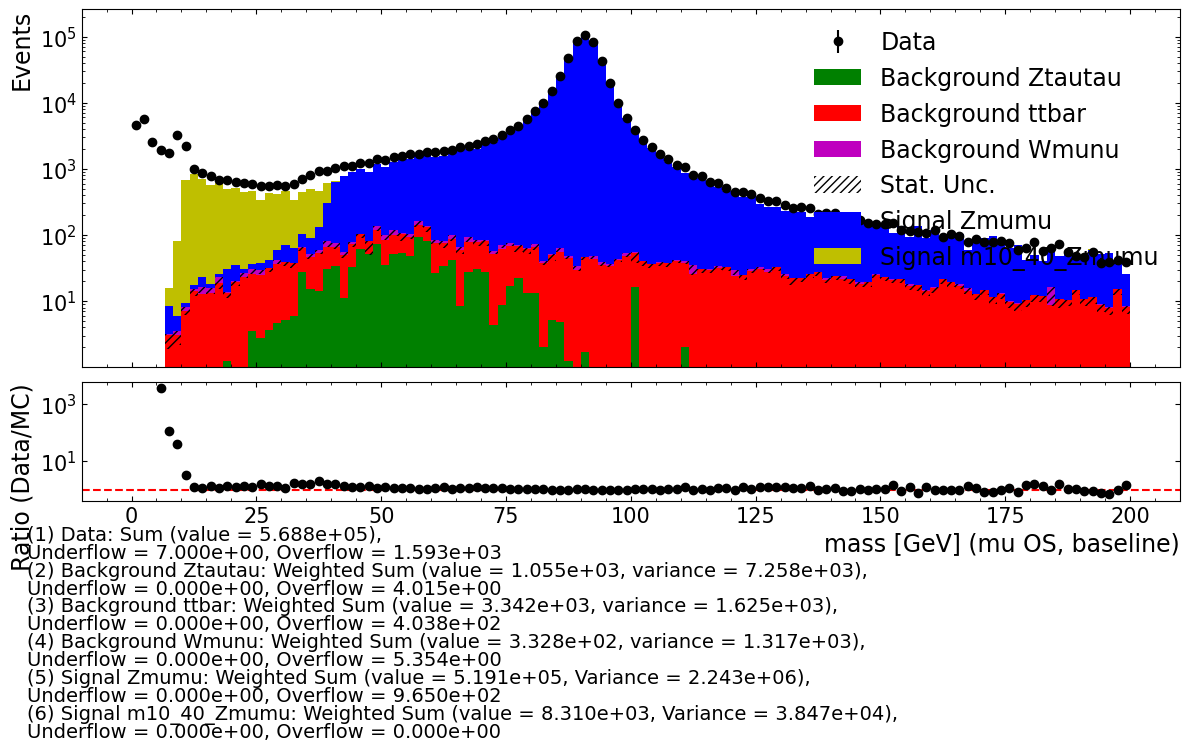

Elapsed time = 0.1s


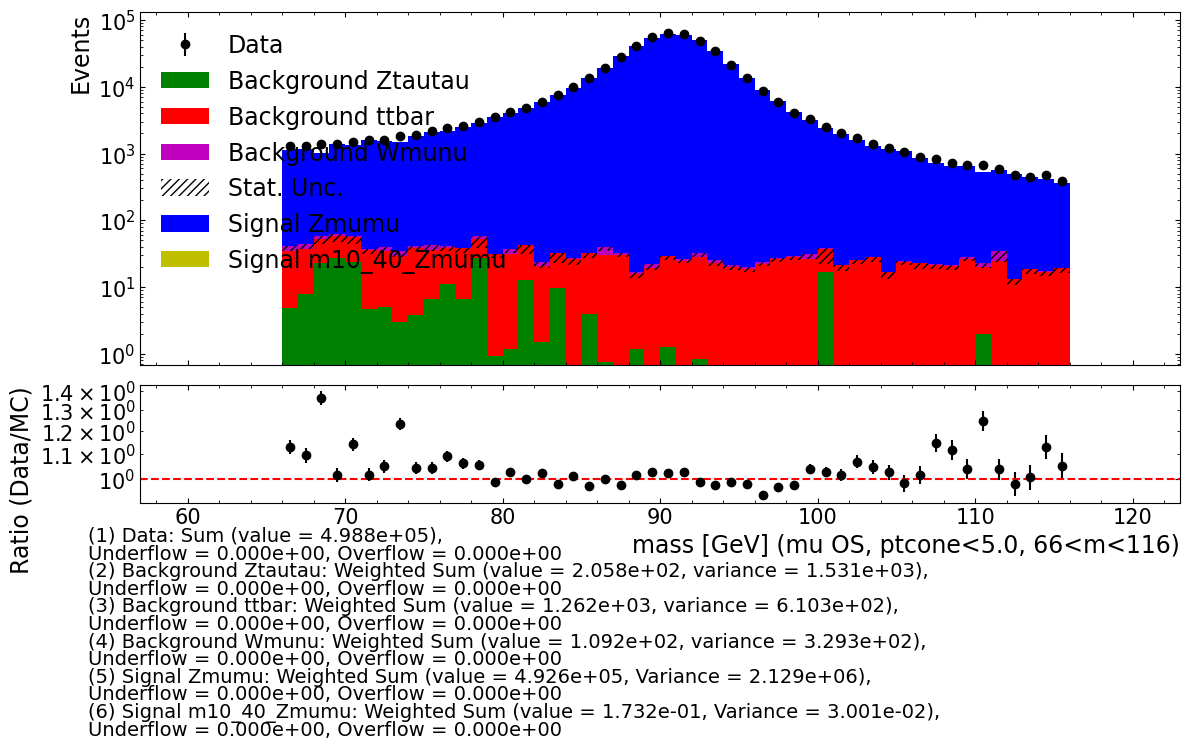

Elapsed time = 0.1s


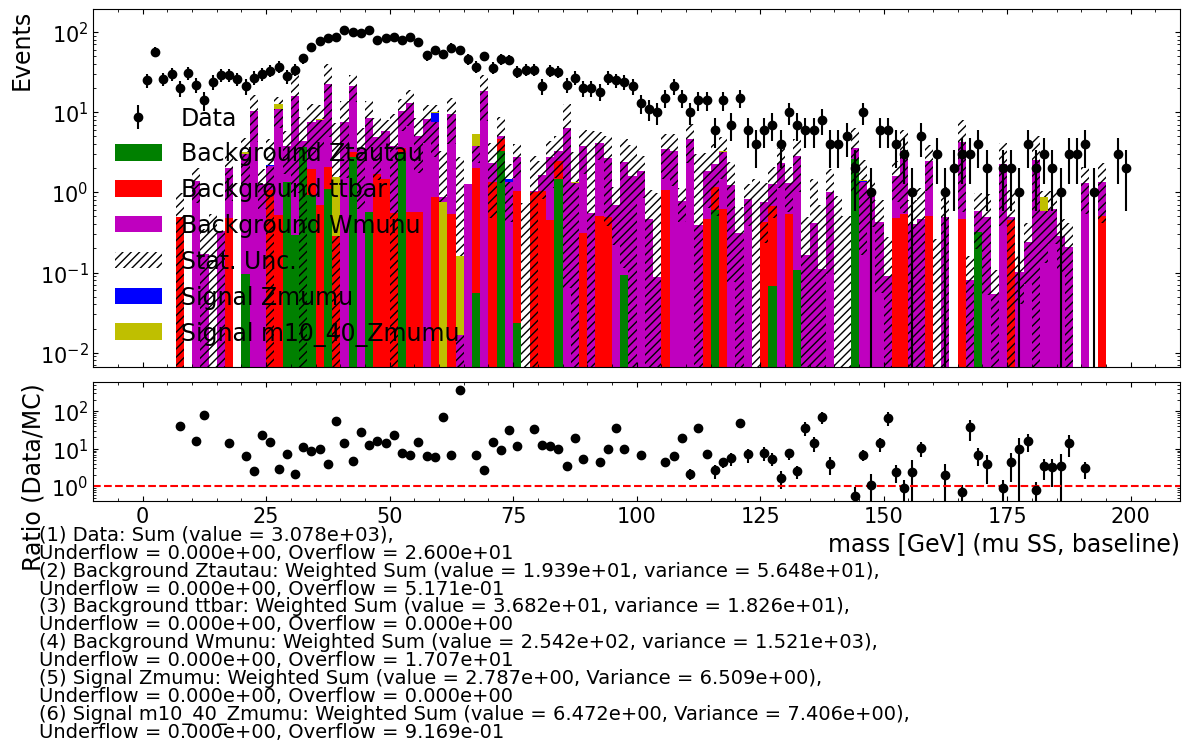

Elapsed time = 0.1s


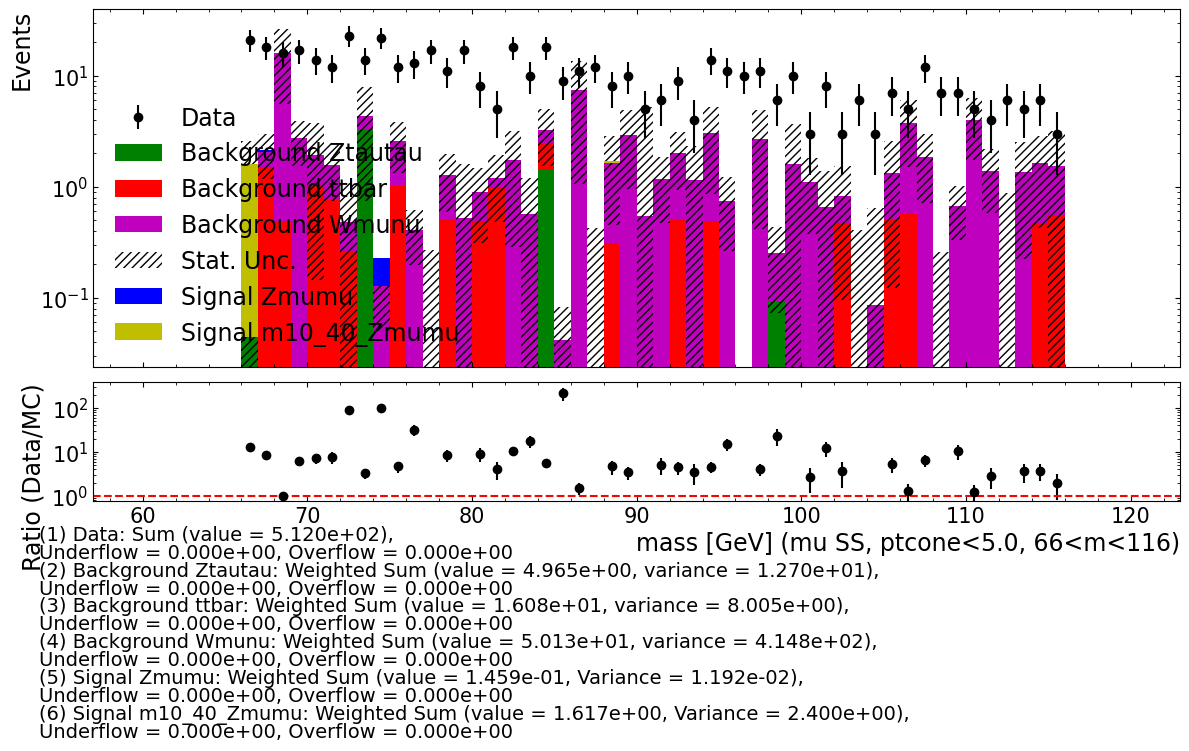

(<Figure size 1200x800 with 2 Axes>,
 [Hist(Regular(60, 60, 120, name='Data'), storage=Double()) # Sum: 512.0,
  Hist(Regular(60, 60, 120, name='Background Ztautau'), storage=Weight()) # Sum: WeightedSum(value=4.96516, variance=12.7016),
  Hist(Regular(60, 60, 120, name='Background ttbar'), storage=Weight()) # Sum: WeightedSum(value=16.0776, variance=8.00489),
  Hist(Regular(60, 60, 120, name='Background Wmunu'), storage=Weight()) # Sum: WeightedSum(value=50.1311, variance=414.787),
  Hist(Regular(60, 60, 120, name='Signal Zmumu'), storage=Weight()) # Sum: WeightedSum(value=0.145945, variance=0.0119248),
  Hist(Regular(60, 60, 120, name='Signal m10_40_Zmumu'), storage=Weight()) # Sum: WeightedSum(value=1.6174, variance=2.39977)])

In [53]:
# OS before
plot_stacked_hist(plot_dict_mu_OS_cone, "mass", color_list,
                  num_bins=120, xmin=0, xmax=200,
                  x_label="mass [GeV] (mu OS, baseline)",
                  logy=True, show_text=True, residual_plot=True, save_fig=False)

# OS after (Z window + iso)
plot_dict_mu_OS_final = select_plotdict(plot_dict_mu_OS_cone, ptcone_max=ptcone_choice, mass_window=mass_win, require_both=True)
plot_stacked_hist(plot_dict_mu_OS_final, "mass", color_list,
                  num_bins=60, xmin=60, xmax=120,
                  x_label=f"mass [GeV] (mu OS, ptcone<{ptcone_choice}, 66<m<116)",
                  logy=True, show_text=True, residual_plot=True, save_fig=False)

# SS before
plot_stacked_hist(plot_dict_mu_SS_cone, "mass", color_list,
                  num_bins=120, xmin=0, xmax=200,
                  x_label="mass [GeV] (mu SS, baseline)",
                  logy=True, show_text=True, residual_plot=True, save_fig=False)

# SS after (same region, good for comparison)
plot_dict_mu_SS_final = select_plotdict(plot_dict_mu_SS_cone, ptcone_max=ptcone_choice, mass_window=mass_win, require_both=True)
plot_stacked_hist(plot_dict_mu_SS_final, "mass", color_list,
                  num_bins=60, xmin=60, xmax=120,
                  x_label=f"mass [GeV] (mu SS, ptcone<{ptcone_choice}, 66<m<116)",
                  logy=True, show_text=True, residual_plot=True, save_fig=False)


In [59]:
## ptcone cut scan:

iso_values = [1.0, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 7.0, 10.0]

# Reference: OS signal in Z window without iso
os_ref = select_plotdict(plot_dict_mu_OS_cone, mass_window=mass_win, require_both=True)
_, s_ref, _, _, _ = summarize_plotdict(os_ref)

# Reference: SS data in Z window without iso
ss_ref = select_plotdict(plot_dict_mu_SS_cone, mass_window=mass_win, require_both=True)
dss_ref, _, _, _, _ = summarize_plotdict(ss_ref)

rows = []
for iso in iso_values:
    os_sel = select_plotdict(plot_dict_mu_OS_cone, mass_window=mass_win, ptcone_max=iso, require_both=True)
    ss_sel = select_plotdict(plot_dict_mu_SS_cone, mass_window=mass_win, ptcone_max=iso, require_both=True)

    dos, sos, bos, sbos, dmc_os = summarize_plotdict(os_sel)
    dss, sss, bss, sbss, dmc_ss = summarize_plotdict(ss_sel)

    sig_eff = sos / s_ref if s_ref > 0 else np.nan
    ss_rej  = 1.0 - (dss / dss_ref) if dss_ref > 0 else np.nan

    rows.append([iso, sig_eff, ss_rej, dos, dss, dmc_os, dmc_ss])

df_scan = pd.DataFrame(rows, columns=[
    "ptcone_max", "OS sig efficiency", "SS rejection",
    "OS Data", "SS Data", "OS Data/MC", "SS Data/MC"
])
df_scan


ptcone_max  OS sig efficiency  SS rejection   OS Data  SS Data  \
0          1.0           0.890544      0.625995  426236.0    282.0   
1          2.0           0.970013      0.497347  478570.0    379.0   
2          3.0           0.988167      0.431034  491462.0    429.0   
3          3.5           0.992760      0.404509  494444.0    449.0   
4          4.0           0.995682      0.370027  496415.0    475.0   
5          4.5           0.997587      0.351459  497777.0    489.0   
6          5.0           0.998695      0.320955  498799.0    512.0   
7          5.5           0.999375      0.299735  499545.0    528.0   
8          6.0           0.999700      0.269231  500072.0    551.0   
9          7.0           0.999922      0.232095  500788.0    579.0   
10        10.0           0.999990      0.118037  501814.0    665.0   

    OS Data/MC  SS Data/MC  
0     0.967556    6.223500  
1     0.997117    6.487973  
2     1.005097    6.236146  
3     1.006492    6.321221  
4     1.007527    6.780502  
5     1.008357    6.836063  
6     1.009301    7.019740  
7     1.010122    7.239107  
8     1.010859    7.554447  
9     1.012081    7.938339  
10    1.014085    9.043835

In [60]:
## Find best:
cand = df_scan[df_scan["OS sig efficiency"] > 0.995].copy()
best = cand.sort_values("SS rejection", ascending=False).head(1)
best


ptcone_max  OS sig efficiency  SS rejection   OS Data  SS Data  OS Data/MC  \
4         4.0           0.995682      0.370027  496415.0    475.0    1.007527   

   SS Data/MC  
4    6.780502

## Hist
`Hist` objects can be used to inspect the histogram contents, including the bin values, variances (for MC datasets), and underflow/overflow bins.  
The second value returned by `plot_stacked_hist` is a list of `Hist` objects. They are in the order 'Data', 'Background', 'Signal'.

Here are some useful methods:
- `.sum()` - total sum of all bin contents
- `.view()` - bin values (Data)
- `.view().value` - bin values (MC)
- `.view().variance` - bin variances (MC)
- `.view(flow=True)[0]` - underflow bin value
- `.view(flow=True)[-1]` - overflow bin value
- `.axes[0].centers` - bin centres
  
For example, try uncommenting the lines below to explore the contents of a `Hist` object:

In [45]:
# In our example, the first Hist object (index 0) is Data, and the second (index 1) is MC
hists                 # View the full histogram object
#hists[2]                 # View the full histogram object
# hists[0].sum()         # Total sum of all bin contents
# hists[0].view()        # Access the bin values (excluding flow bins)

[Hist(Regular(120, 0, 120, name='Data'), storage=Double()) # Sum: 564388.0 (573455.0 with flow),
 Hist(Regular(120, 0, 120, name='Background Ztautau'), storage=Weight()) # Sum: WeightedSum(value=1070.58, variance=7306.25) (WeightedSum(value=1079.41, variance=7323.01) with flow),
 Hist(Regular(120, 0, 120, name='Background ttbar'), storage=Weight()) # Sum: WeightedSum(value=2512.94, variance=1224.68) (WeightedSum(value=3782.38, variance=1839.87) with flow),
 Hist(Regular(120, 0, 120, name='Background Wmunu'), storage=Weight()) # Sum: WeightedSum(value=524.241, variance=2661.83) (WeightedSum(value=609.436, variance=2955.24) with flow),
 Hist(Regular(120, 0, 120, name='Signal Zmumu'), storage=Weight()) # Sum: WeightedSum(value=513388, variance=2.21957e+06) (WeightedSum(value=520096, variance=2.2464e+06) with flow),
 Hist(Regular(120, 0, 120, name='Signal m10_40_Zmumu'), storage=Weight()) # Sum: WeightedSum(value=8317.87, variance=38473.2) (WeightedSum(value=8317.1, variance=38477.8) with 

For more information about `Hist`, see https://hist.readthedocs.io/en/latest/.

For more information about `matplotlib.pyplot`, see https://matplotlib.org/stable/api/pyplot_summary.html.

The function `savefig` saves a copy of the figure you have just produced.
    Note an alternative is to set the input argument `save_fig` to `True` in the function `plot_stacked_hist`.

In [ ]:
fig.savefig(plot_variable+'.png')

## Additional Plotting Functions
If you want to plot additional variables to identify where the selection cut could be tightened, the `plot_histograms` function is for you. This function returns:
- A **list** of `Figure` objects (one per variable plotted)
- A corresponding **list of lists** of `Hist` objects

There are some arguments worth pointing out:
- `xmin_xmax_list` : a tuple of two numbers applied to all plots, or a list of tuples (one per variable)
- `num_bins_list` : an int applied to all plots, or a list of int (one per variable)

The same applies to these optional arguments: `y_label_list`, `ylim_list`, `title_list`, and `residual_ylim_list`. These can be specified as a single value applied to all plots or as a list matching the number of variables.

Elapsed time = 0.2s


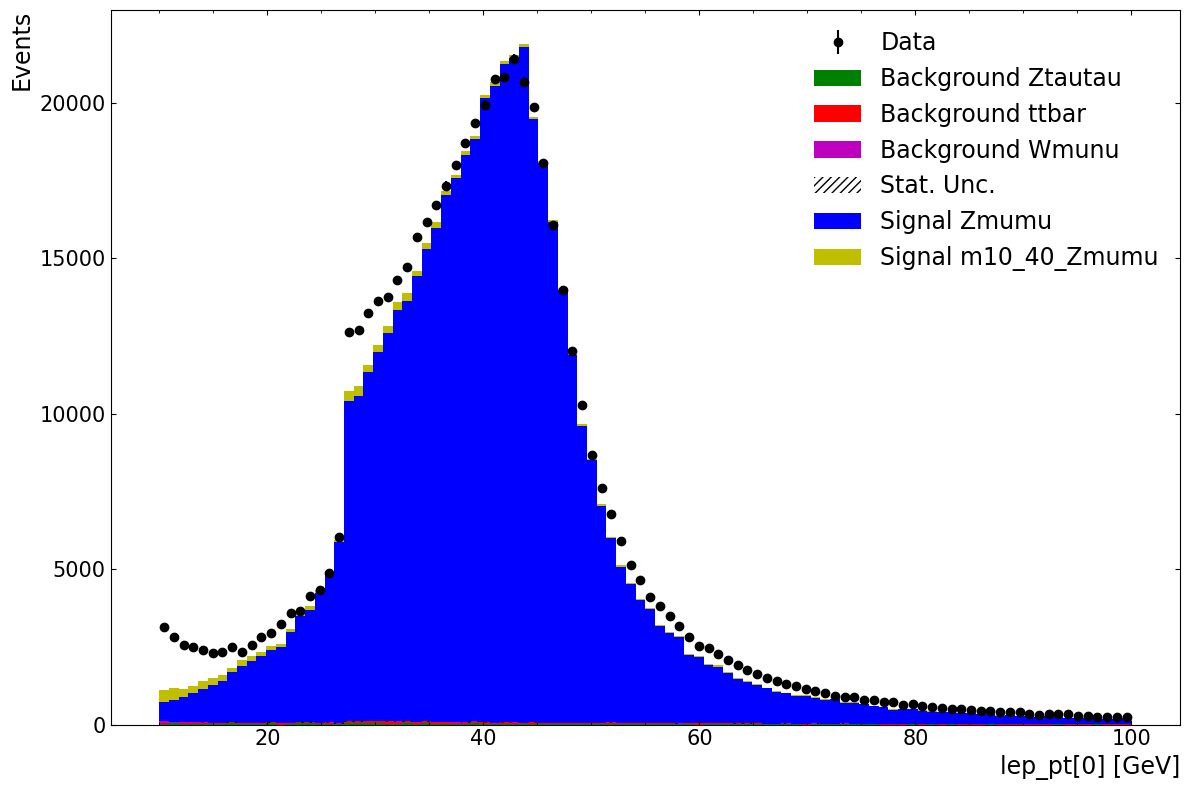

Elapsed time = 0.7s


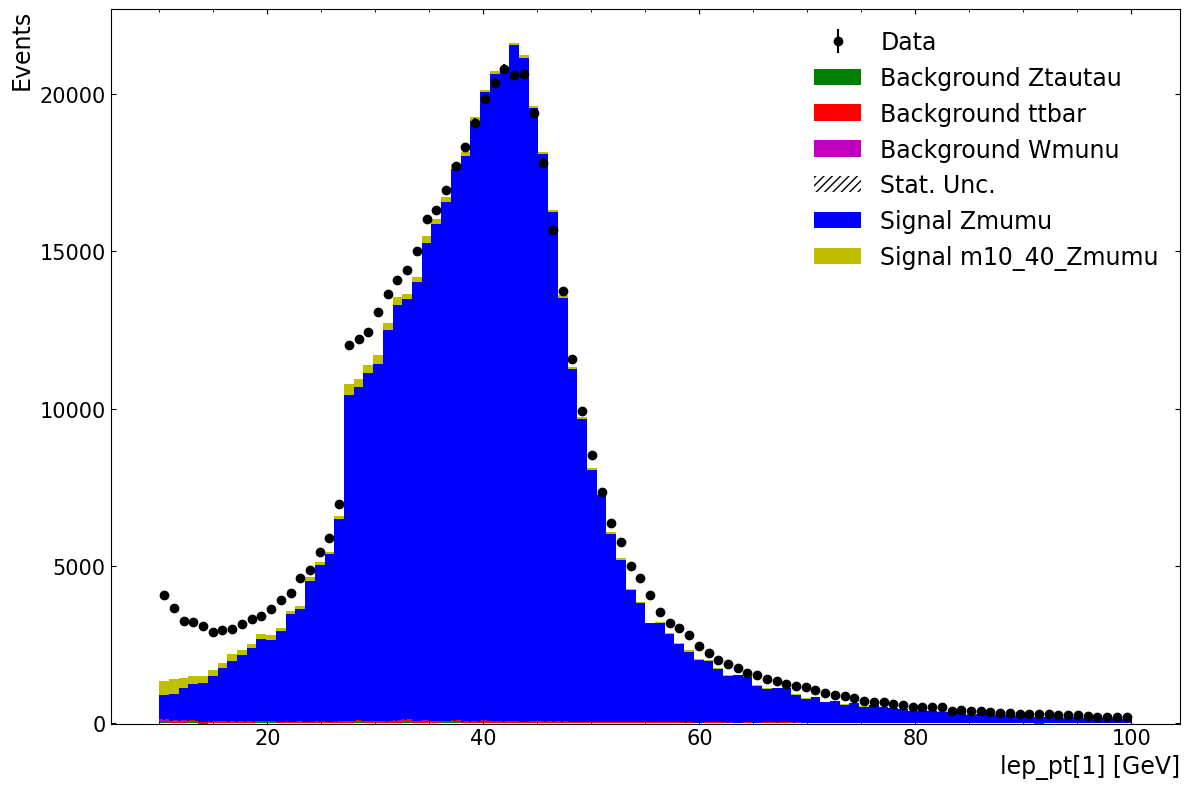

Elapsed time = 1.0s


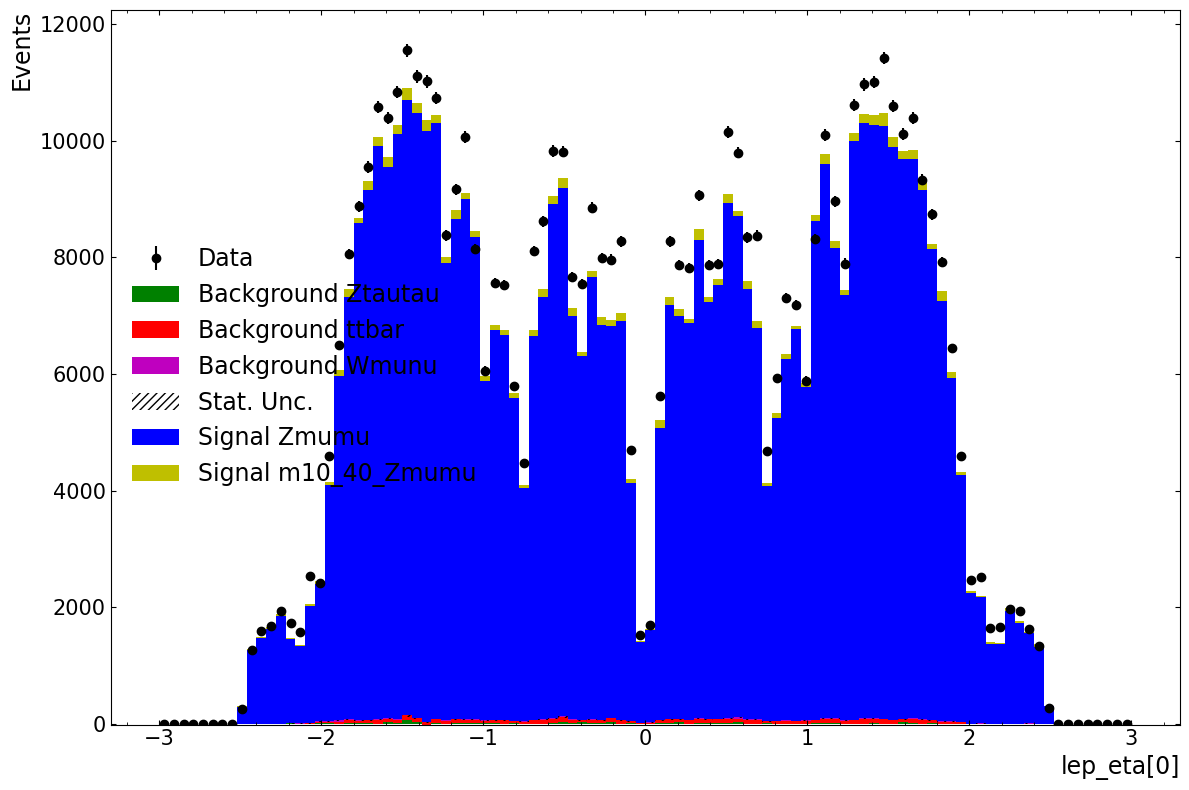

Elapsed time = 1.5s


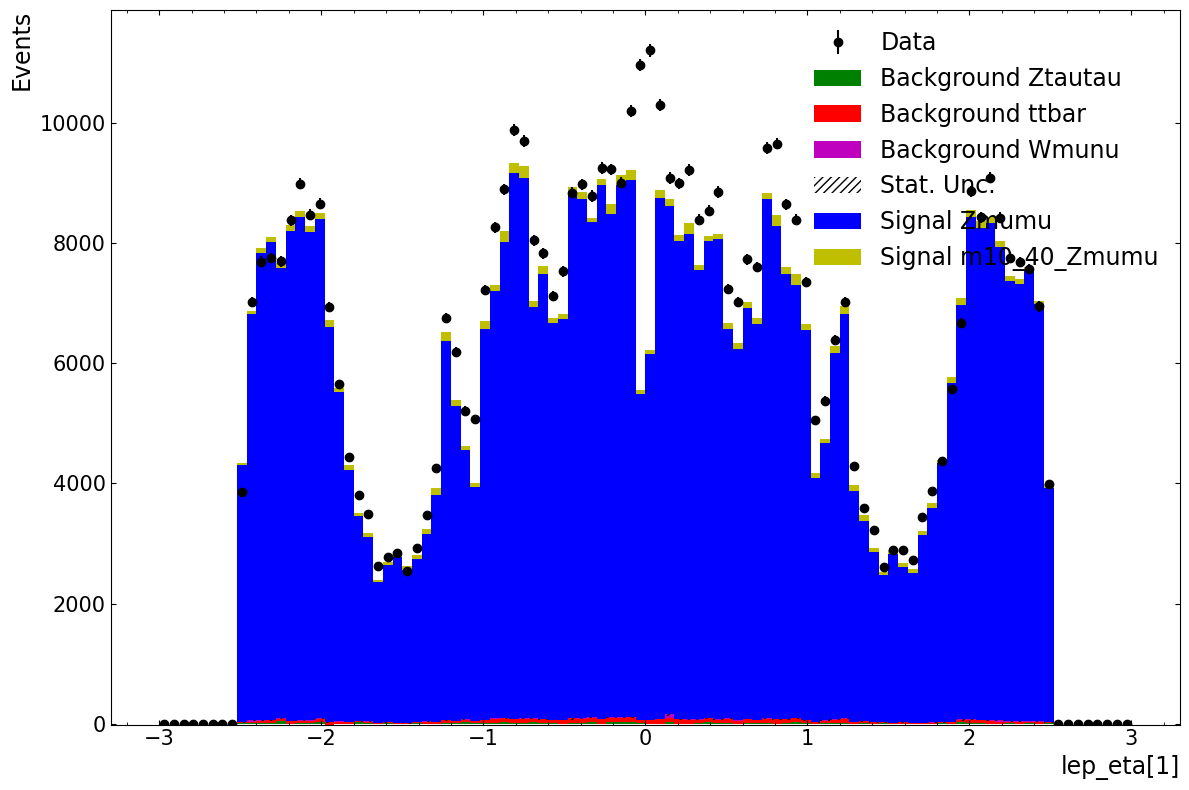

([<Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>],
 [[Hist(Regular(100, 10, 100, name='Data'), storage=Double()) # Sum: 566545.0 (573455.0 with flow),
   Hist(Regular(100, 10, 100, name='Background Ztautau'), storage=Weight()) # Sum: WeightedSum(value=1069.6, variance=7312.92) (WeightedSum(value=1079.41, variance=7323.01) with flow),
   Hist(Regular(100, 10, 100, name='Background ttbar'), storage=Weight()) # Sum: WeightedSum(value=3379.59, variance=1645.39) (WeightedSum(value=3782.38, variance=1839.87) with flow),
   Hist(Regular(100, 10, 100, name='Background Wmunu'), storage=Weight()) # Sum: WeightedSum(value=595.072, variance=2944.39) (WeightedSum(value=609.436, variance=2955.24) with flow),
   Hist(Regular(100, 10, 100, name='Signal Zmumu'), storage=Weight()) # Sum: WeightedSum(value=515514, variance=2.2432e+06) (WeightedSum(value=520096, variance=2.2464e+06) with flow),
   Hist(Re

In [ ]:
# Plot many variables at once 
plot_dict = {
    'Data' : pt_data['2to4lep_0_02'],
    'Signal Zmumu' : pt_data['Zmumu_0_02'], 
    'Signal m10_40_Zmumu' : pt_data['m10_40_Zmumu_0_02'], 
    'Background Ztautau': pt_data['Ztautau_0_02'],
    'Background ttbar' : pt_data['ttbar_0_02'], 
    'Background Wmunu' : pt_data['Wmunu_0_02'],
}

# Define plot appearance
#color_list = ['k'] # Black (data)
color_list = ['k', 'b', 'y', 'g', 'r', 'm'] # Black (data), blue (signal), yellow (signal), green (Ztautau), red (ttbar), magenta (Wmunu')


plot_variables = ['lep_pt[0]', 'lep_pt[1]', 'lep_eta[0]', 'lep_eta[1]']
xmin_xmax_list = [(10, 100), (10, 100), (-3, 3), (-3, 3)] # Bin range for each variable
num_bins_list = 100
x_label_list = ['lep_pt[0] [GeV]', 'lep_pt[1] [GeV]', 'lep_eta[0]', 'lep_eta[1]']

plot_histograms(
    plot_dict,
    plot_variables,
    color_list,
    xmin_xmax_list, # If you provide a tuple of 2 numbers, that will be applied to all plots
    num_bins_list,
    x_label_list,
    # Optional arguments start from here
    # y_label_list=None, # Str or list of str for y-axis label
    # ylim_list=None, # Tuple of 2 numbers or list of tuples for y axis limit
    logy=False, # Whether to set the y axis as log scale
    # title_list=None, # Str or list of str for title
    # marker='o', # Marker type
    # title_fontsize=17, # Fontsize for title
    # label_fontsize=17, # Fontsize for x and y axes
    # legend_fontsize=17, # Fontsize for legend
    # tick_labelsize=15, # Fontsize for x and y axes ticks
    # text_fontsize=14, # Fontsize for text that shows histogram info
    # fig_size=(12, 8), # Figure size
    # show_text=False, # Whether to show the text that displays histogram info
    # show_back_unc=True, # Whether to show the background uncertainty
    save_fig=False, # Whether to save figure
    # fig_name=None, # Filename of the image. If not provided, save figure using the plot_variable and the keys of data_dict
    residual_plot=False # Whether to show residual plot under the main plot
    # residual_ylim_list=None # Tuple of 2 numbers or list of tuples for residual plot y-axis limit
)         

The `plot_errorbars` function is designed for situations where you want to:
- Plot the same variable for different particles in the same event on a single figure, or
- Compare histograms under different selection cuts.

The first argument to `plot_errorbars` must be a dictionary. Each value in this dictionary should also be a dictionary containing the following keys:
- `'color'`: Color to be used for plotting
- `'array'`: The data array to be histogrammed
- `'weight'`: Weights associated with each data point

This function returns:
- A `Figure` object (for saving), and
- A list of `Hist` objects representing the histograms for each key

Below are some examples demonstrating how to use the `plot_errorbars` function.

Elapsed time = 0.0s


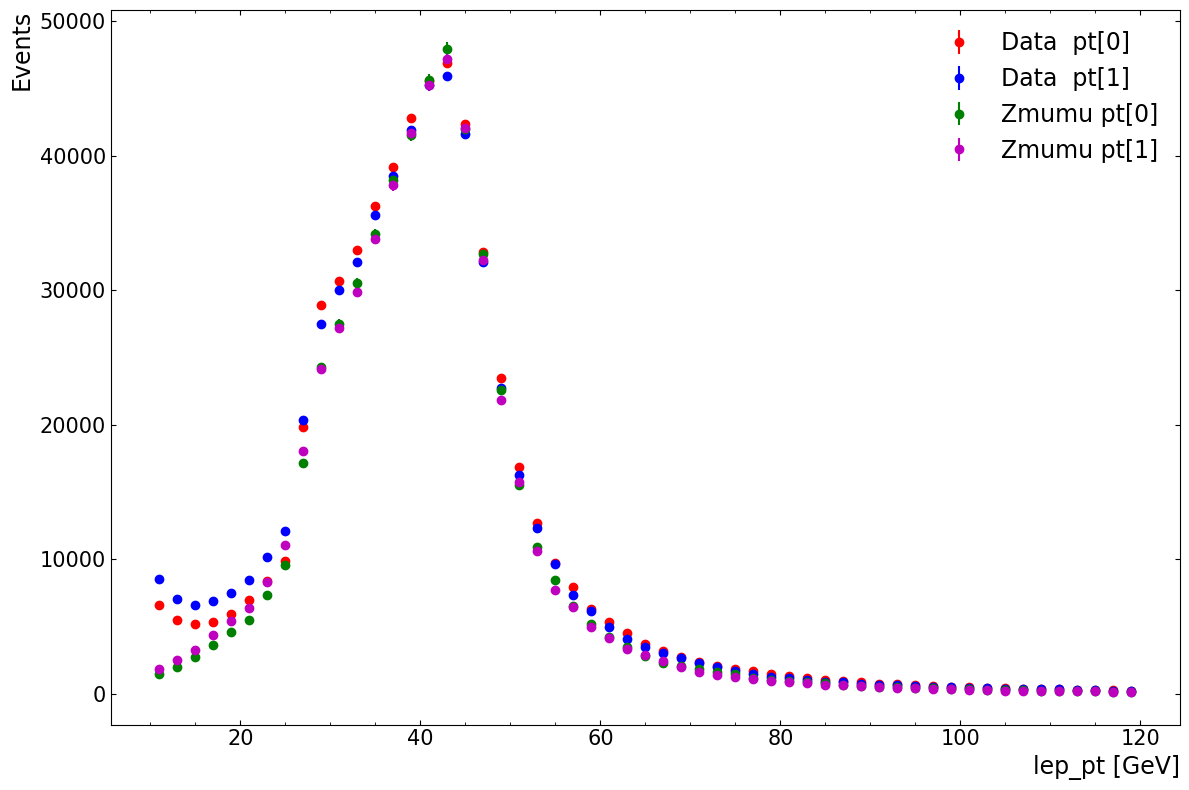

(<Figure size 1200x800 with 1 Axes>,
 [Hist(Regular(55, 10, 120, name='Data  pt[0]'), storage=Double()) # Sum: 569916.0 (573455.0 with flow),
  Hist(Regular(55, 10, 120, name='Data  pt[1]'), storage=Double()) # Sum: 570131.0 (573455.0 with flow),
  Hist(Regular(55, 10, 120, name='Zmumu pt[0]'), storage=Weight()) # Sum: WeightedSum(value=517771, variance=2.24469e+06) (WeightedSum(value=520096, variance=2.2464e+06) with flow),
  Hist(Regular(55, 10, 120, name='Zmumu pt[1]'), storage=Weight()) # Sum: WeightedSum(value=517991, variance=2.24475e+06) (WeightedSum(value=520096, variance=2.2464e+06) with flow)])

In [ ]:
# Compare pt of the two leptons
data_dict = {
    'Data  pt[0]' : {'color' : 'r',
                          'array' : pt_data['2to4lep_0_02']['lep_pt'][:, 0],
                          'weight' : None},
    'Data  pt[1]' : {'color' : 'b',
                          'array' : pt_data['2to4lep_0_02']['lep_pt'][:, 1],
                          'weight' : None},
    'Zmumu pt[0]' : {'color' : 'g',
                         'array' : pt_data['Zmumu_0_02']['lep_pt'][:, 0],
                         'weight' : pt_data['Zmumu_0_02']['totalWeight']},
    'Zmumu pt[1]' : {'color' : 'm',
                         'array' : pt_data['Zmumu_0_02']['lep_pt'][:, 1],
                         'weight' : pt_data['Zmumu_0_02']['totalWeight']},
}
xmin, xmax = 10, 120
num_bins = 55
x_label = 'lep_pt [GeV]'

plot_errorbars(data_dict,
               xmin,
               xmax,
               num_bins,
               x_label,
               # Optional arguments
               # y_label='Events',
               # logy=False,
               # title='',
               # marker='o',
               # title_fontsize=17,
               # label_fontsize=17,
               # legend_fontsize=17,
               # tick_labelsize=15,
               # text_fontsize=14,
               # show_text=False,
               # fig_size=(12, 8)
)

In [ ]:
# Create a second copy of the data in memory, having applied a different set of event selection cuts (from those applied above in function "pt_cut()"

def pt20_cut(data):
    # Cut on lepton number, type and pt
    data = data[data['lep_n'] == 2] 
    data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 26]
    data = data[(data['lep_pt'][:, 0] > 20) & (data['lep_pt'][:, 1] > 20)]

    # Require that a single muon trigger fired 
    data = data[(data['trigM'])] 

    four_momentum = vector.zip({
        'pt': data['lep_pt'],
        'eta' : data['lep_eta'],
        'phi' : data['lep_phi'],
        'E' : data['lep_e']
    })
    # Add the 4-momentum of the two leptons in each event and get the 
    # invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    
    return data

pt20_data = analysis_parquet(read_variables, string_code_list, fraction=fraction, cut_function=pt20_cut)
pt20_data

Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.3s


{'2to4lep_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='508455 * {lep_n: int32, ...'>,
 'Zmumu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='765189 * {lep_n: int32, ...'>,
 'm10_40_Zmumu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='14655 * {lep_n: int32, l...'>,
 'Ztautau_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='1665 * {lep_n: int32, le...'>,
 'ttbar_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='6697 * {lep_n: int32, le...'>,
 'Wmunu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='497 * {lep_n: int32, lep...'>}

In [ ]:
# Compare histograms under different cuts
data_dict = {
    'Data pt>20' : {'color' : 'r',
                    'array' : pt20_data['2to4lep_0_02']['mass'],
                    'weight' : None},
    'Zmumu pt>20' : {'color' : 'g',
                   'array' : pt20_data['Zmumu_0_02']['mass'],
                   'weight' : pt20_data['Zmumu_0_02']['totalWeight']},
    'Data pt>10' : {'color' : 'b',
                    'array' : pt_data['2to4lep_0_02']['mass'],
                    'weight' : None},
    'Zmumu pt>10' : {'color' : 'm',
                   'array' : pt_data['Zmumu_0_02']['mass'],
                   'weight' : pt_data['Zmumu_0_02']['totalWeight']},
}

xmin, xmax = 50, 140 # Define histogram bin range and x-axis limits 
num_bins = 90 # Number of histogram bins
x_label = 'mass [GeV]'

plot_errorbars(data_dict, xmin, xmax, num_bins, x_label, logy=True)

## 2D Histogram
If you want to plot a 2D histogram, you can use the `histogram_2d` function as shown in the code cell below.

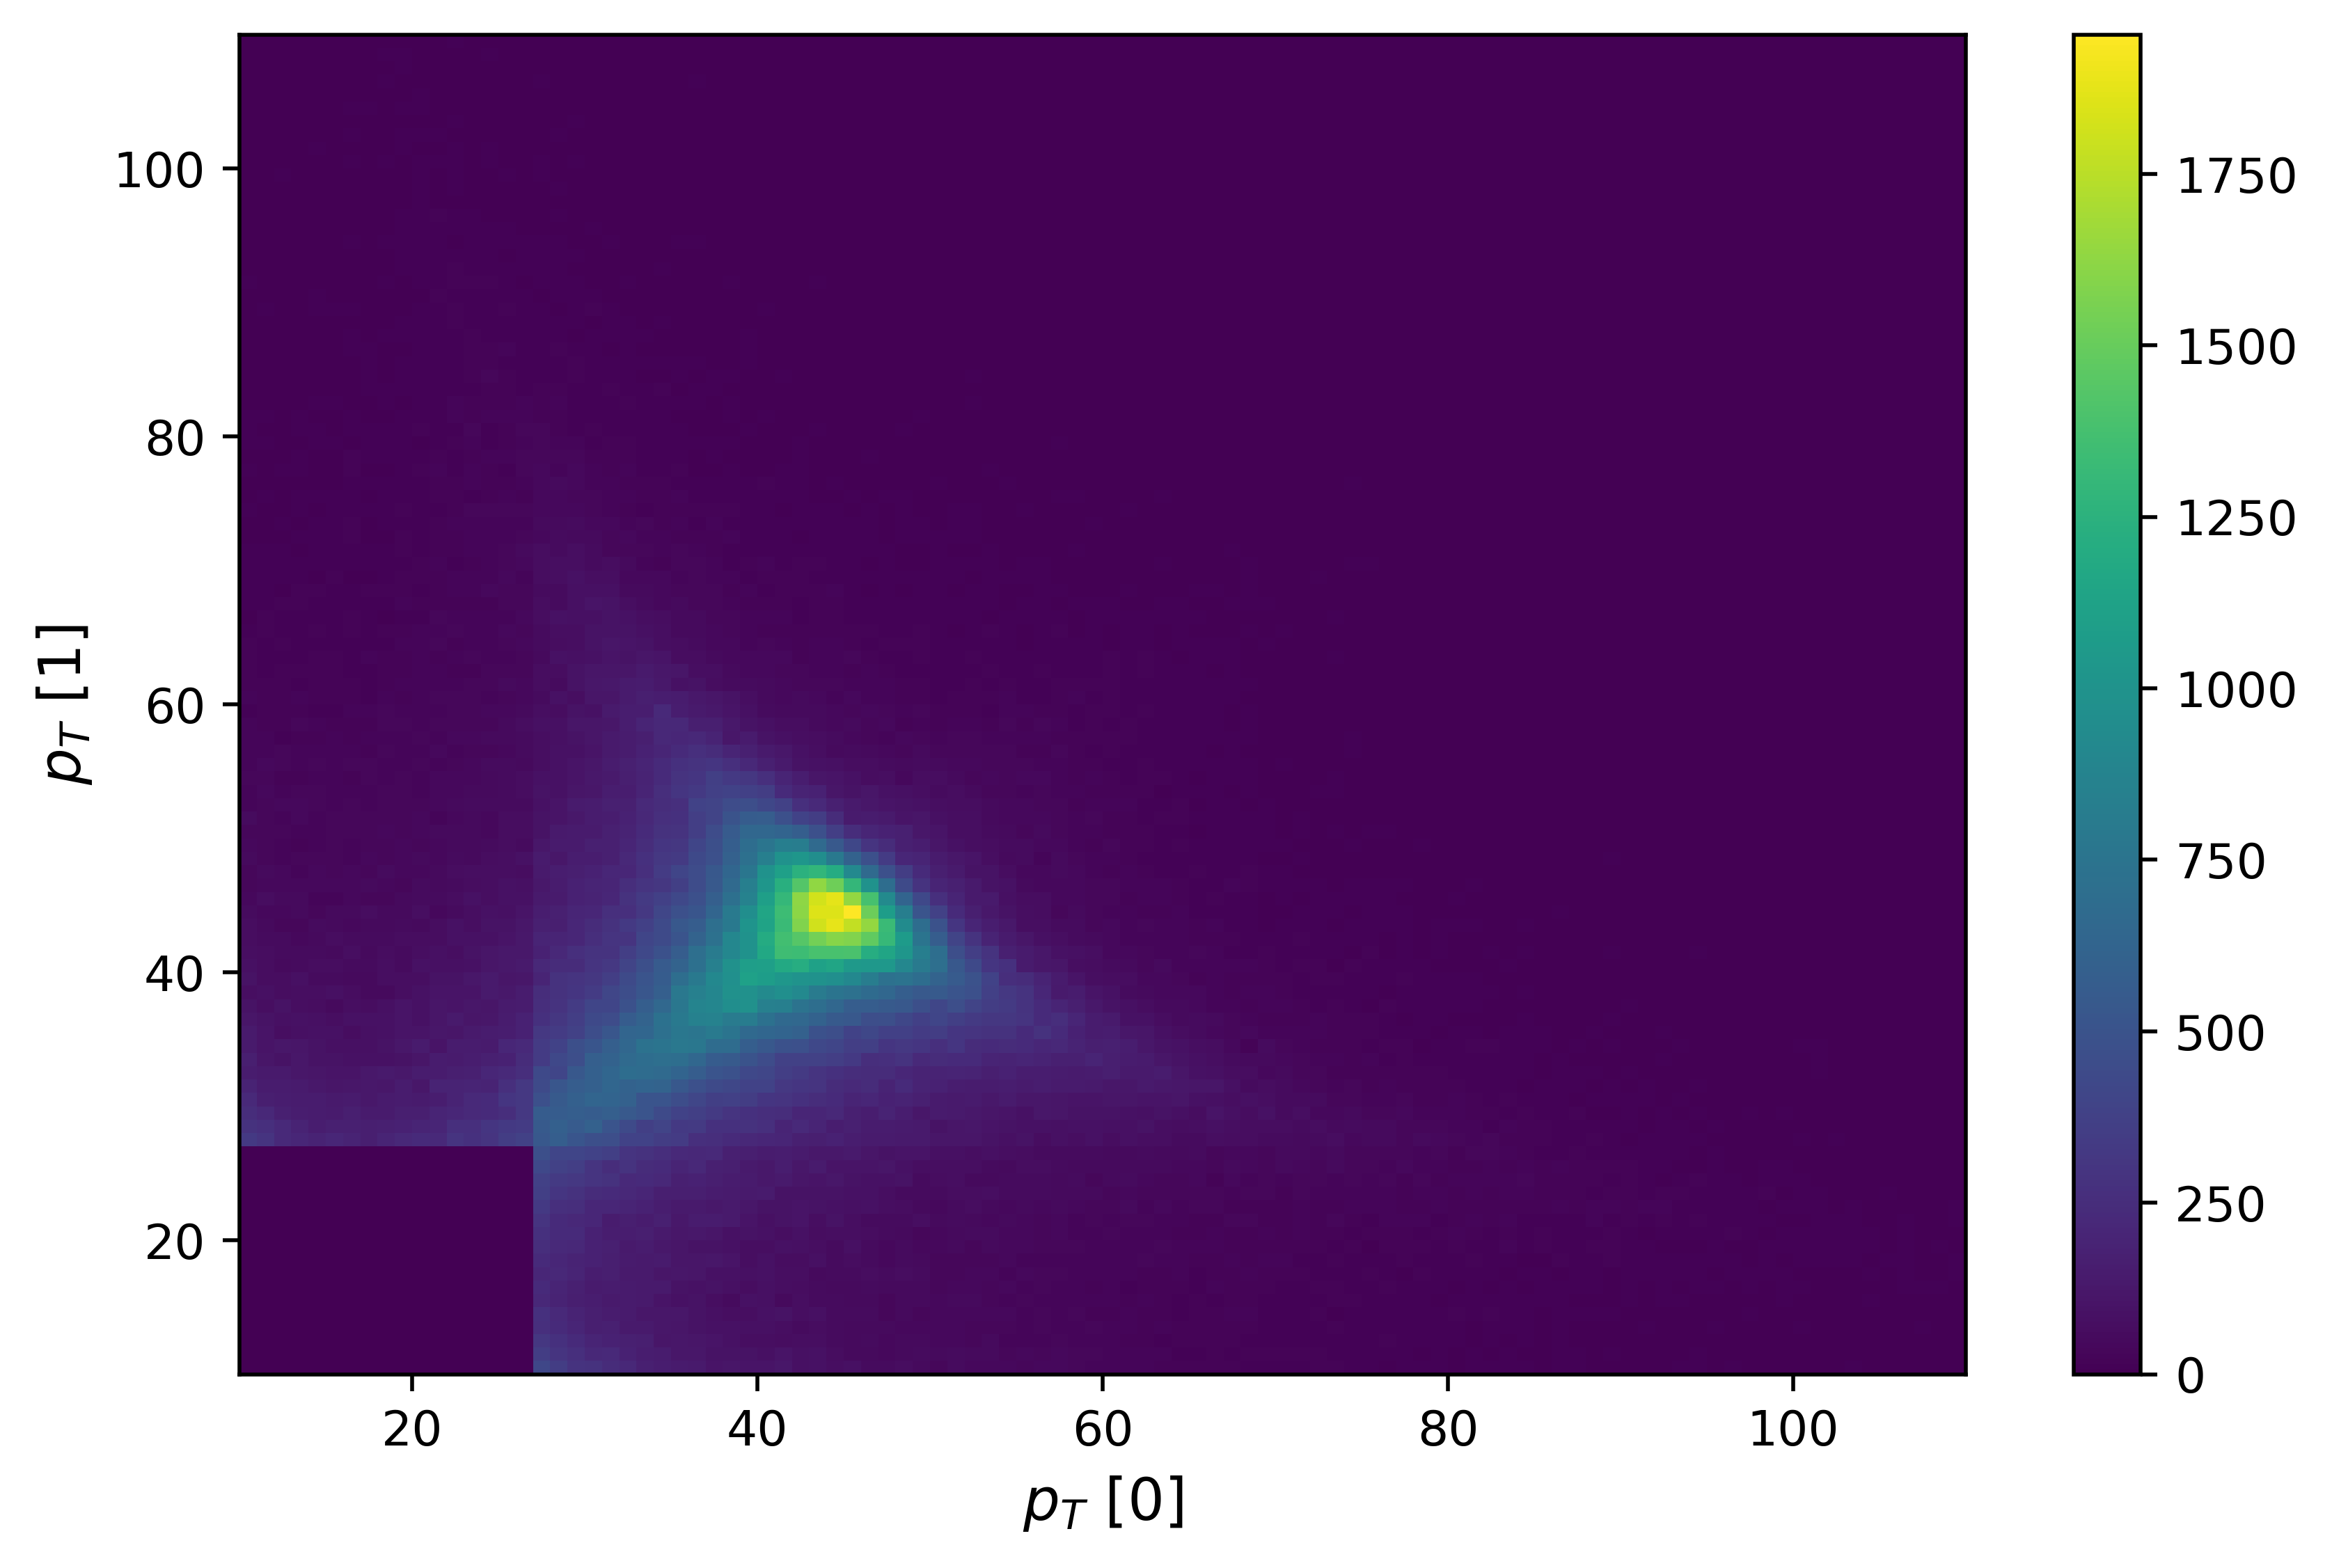

In [ ]:

data_pt0 = pt_data['2to4lep_0_02']['lep_pt'][:, 0]
data_pt1 = pt_data['2to4lep_0_02']['lep_pt'][:, 1]
data_2d = (data_pt0, data_pt1) # Plot lep_pt[0] on x-axis, lep_pt[1] on y-axis
num_bins_2d = (100, 100) # Number of bins along x and y-axis 
min_max_2d = ((10, 110), (10, 110)) # The bin range in x and y
label_2d = ('$p_T$ [0]', '$p_T$ [1]') # The labels for x and y-axis


# Plot the 2D histogram
fig, h = histogram_2d(data_2d, num_bins_2d,
                      min_max_2d, label_2d,
                      # Optional arguments
                      # label_fontsize=12, tick_labelsize=10,
                      # title_fontsize=13, title='',
                      # colorbar_label='Events'
                    )
# Uncomment to save the image
#fig.savefig('test.png', dpi=500)

## Write the Data to Disk
When working with larger datasets, e.g. using a higher `fraction` in `analysis_parquet`, it is often more efficient to write the data to disk rather than keeping it all in memory. 

To do this, set the optional argument `write_parquet=True`. This will instruct the `analysis_parquet` function to save the output as Parquet files. If you write data to disk, it is recommended to set `return_output=False` to avoid loading large amounts of data into memory.  

In addition, you can customise the output location using the `output_directory` argument. If not provided, the files will be saved in an `output` folder with a unique name created from the current date and time.  

**Note**: The provided output directory must be unique and cannot be reused. Attempting to write to an existing directory will raise a `FileExistsError` to prevent accidental overwriting of data.   

For example, the following makes a tighter preselection of di-lepton events.


In [ ]:
# Write your own di-lepton preselection to parquet files

string_code_list = ['2to4lep', 'Zmumu', 'm10_40_Zmumu', 'Ztautau', 'ttbar', 'Wmunu', 'Wtaunu'] # List of dataset codes to load
#string_code_list = ['2to4lep', 'Zee', 'm10_40_Zee', 'Ztautau', 'ttbar', 'Wenu', 'Wtaunu'] # List of dataset codes to load

# Specify the variables to be read in.
# These variables will also be written out, in addition to any defined in the function 'preselection_cut' below
read_variables = ['lep_n', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_type', 'lep_charge', 'trigE', 'trigM', 'lep_isTrigMatched',
                   'lep_isLooseID', 'lep_isMediumID', 'lep_isLooseIso', 'lep_isTightIso']

# Alternatively, you may wish to use the pre-defined function `validate_read_variables` to find the names of all available variables
#read_variables = get_valid_variables('2to4lep') # Save all available variables

# Specify the directory to which the output parquet files should be written
output_dir = '../../output-parquet/dimuon_massGT15_PtGT15'

# Custom selection cut function to filter the data when writing out parquet files
def preselection_cut(data):
    # Use bitwise operator '&' for AND, '|' for OR. Remember to put parentheses around each logical (sub)expression!

    # Cut on lepton number - Only keep events that have two leptons
    data = data[data['lep_n'] == 2] 

    # Cut on lep_type
    # lep_type is 11 for electron, 13 for muon
    #data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 22] # Keep events with two electrons
    data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 26] # Keep events with two muons

    # Require that a single electron trigger fired 
    #data = data[(data['trigE'])] 
    # Require that a single muon trigger fired 
    data = data[(data['trigM'])] 

    # Require at least one lepton to have  pt > 27 GeV and be trigger matched
    # N.B. not needed here because this has already been required in the pre-selection of the parquet files you are reaeding in
    #data = data[((data['lep_pt'][:, 0] > 27) & (data['lep_isTrigMatched'][:, 0])) | ((data['lep_pt'][:, 1] > 27) & (data['lep_isTrigMatched'][:, 1]))]

    # Find the pt of the lepton with the lowest pt of the two and add this variable to the data to be stored on the output parquet files
    data['soft_pt'] = ((data['lep_pt'][:, 0] > data['lep_pt'][:, 1])*data['lep_pt'][:, 1]) + ((data['lep_pt'][:, 0] < data['lep_pt'][:, 1])*data['lep_pt'][:, 0])

    # Cut on lepton pt - Keep events where both leptons have pt > 15 GeV
    # Use bitwise operator '&' for AND, '|' for OR. Remember the parentheses!
    LoosePt = 15
    data = data[(data['lep_pt'][:, 0] > LoosePt) & (data['lep_pt'][:, 1] > LoosePt)]

    # Define four momentum
    four_momentum = vector.zip({
        'pt': data['lep_pt'],
        'eta' : data['lep_eta'],
        'phi' : data['lep_phi'],
        'E' : data['lep_e']
    })
    # Add the 4-momentum of the two leptons in each event and get the invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    
    # Cut on di-lepton mass
    cut_low = 15
    cut_high = 1000   
    cut_mass = (data['mass']>cut_low) &  (data['mass']<cut_high)
    data = data[cut_mass] # Select events satisfying the condition: cut_low < mass < cut_high (GeV)
        
    # Tip: if you want to plot a variable that is a mathematical function of one or more of the input variables then do something like the following: 
    # Calculate the product of the charges of the two leptons.  
    data['charge_product'] = data['lep_charge'][:, 0] * data['lep_charge'][:, 1]

    # Select same-sign (['charge_product']>0), or opposite-sign (['charge_product']<0) events
    #data = data[data['charge_product']<0]
 
    return data

fraction = 0.02

# The argument "write_parquet=True" tells the function to write new parquet files to the output directory "output_dir"
# The argument "return_output=False" tells the function NOT to store data from the selected events to memory (Needed to avoid overflowing the memory limit for fraction = 1)
analysis_parquet(read_variables, string_code_list, fraction=fraction, cut_function=preselection_cut, write_parquet=True, output_directory=output_dir, return_output=False)

# In order to make plots from these new parquet files you need to read them back in using the next cell


Write data to output_directory: ../../output-parquet/dimuon_massGT15_PtGT15
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 4.6s


Files saved by `analysis_parquet` can be reloaded using the same function by specifying the following optional arguments:
- `read_directory` : Path to the directory where the data is saved.
- `subdirectory_names` : A list of subdirectories (folder names) to read from. If not provided, all subdirectories in `read_directory` will be read.
  
Note that `string_code_list` is also an optional argument with a default of `None`. Either `string_code_list` _**or**_ `read_directory` must be provided to the `analysis_parquet` function.  

**_Tip_**: Before loading large datasets, it is recommended to restart the kernel to free up memory. Avoid reading too many variables at once to reduce memory usage.

In [ ]:
# Read in your private di-lepton analysis parquet files and store the required data in memory

read_directory = '../../output-parquet/dimuon_massGT15_PtGT15' # Directory where data was saved when running the previous cell
# N.B. the '../../' in the directory name means that the output directory is created in your "home" directory rather then getting mixed up with your code
get_valid_variables('2to4lep')

# Specify which variables you want to read in for each event
read_variables = ['mass', 'charge_product']
#read_variables = ['lep_n', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_type', 'lep_charge', 'trigE', 'trigM', 'lep_isTrigMatched',
#                   'lep_isLooseID', 'lep_isMediumID', 'lep_isLooseIso', 'lep_isTightIso', 'soft_pt', 'charge_product']

fraction = 1

# Custom selection cut function to filter the data
def read_parquet_cut(data):

    # Cut on lep_type
    # lep_type is 11 for electron, 13 for muon
    #data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 26]

    # Cut on di-lepton mass
    cut_low = 85
    cut_high = 95   
    cut_mass = (data['mass']>cut_low) &  (data['mass']<cut_high)
    data = data[cut_mass] # Select events satisfying the condition: cut_low < mass < cut_high (GeV)

    # Select same-sign (['charge_product']>0), or opposite-sign (['charge_product']<0) events
    data = data[data['charge_product']<0]
 
    
    return data
    
pt_data = analysis_parquet(read_variables, string_code_list=None, read_directory=read_directory,
                        subdirectory_names=None, fraction=fraction, cut_function=read_parquet_cut,
                        write_parquet=False, output_directory=None, return_output=True)
pt_data

# You can now in principle use all of the various plotting functions in the cells above on the data you have now stored in memory.
# N.B. In the plotting functions you will need to change the names of the items in "plot_dict" to correspond to the keys written out below

Variables validated using ../../parquet/2to4lep/chunk_0.parquet
Input read_directory found. Data will be read from ../../output-parquet/dimuon_massGT15_PtGT15.
No data found for ['mass' 'charge_product' 'totalWeight'] in ../../output-parquet/dimuon_massGT15_PtGT15/m10_40_Zmumu_0_02/chunk0.parquet after selection cut
Elapsed time = 0.1s


{'Zmumu_0_02 x1': <Array [{totalWeight: 0.106, ...}, ..., {...}] type='601439 * {totalWeight:...'>,
 'ttbar_0_02 x1': <Array [{totalWeight: 0.318, ...}, ..., {...}] type='524 * {totalWeight: fl...'>,
 'Wmunu_0_02 x1': <Array [{totalWeight: -0.148, ...}, ..., {...}] type='35 * {totalWeight: fl...'>,
 '2to4lep_0_02 x1': <Array [{totalWeight: 1, mass: 88, ...}, ...] type='383429 * {totalWeight: ...'>,
 'Wtaunu_0_02 x1': <Array [{totalWeight: 0.268, ...}, {...}] type='2 * {totalWeight: float64, ...'>,
 'm10_40_Zmumu_0_02 x1': None,
 'Ztautau_0_02 x1': <Array [{totalWeight: 0.373, ...}, ..., {...}] type='24 * {totalWeight: flo...'>}

Note the *change* in the keys of the output dictionary. Each key is constructed by combining the subdirectory name with the `fraction`, separated with`' x'`.  
For example, if the subdirectory name is `'Zee_0_01'` and `fraction = 0.1`, the resulting key will be `'Zee_0_01 x0_1'`, implying that the sample represents `0.01 × 0.1` of the original dataset.  
However, this naming convention does not reflect whether any cuts have been applied, hence the actual number of events is likely not this fraction of the full data —  it only provides a rough estimate. So, make sure to **record** your output directories and cuts clearly in your lab book!

In [ ]:
  
# Function 'produced_event_count' returns the total number (sum of weights) of generated Monte Carlo events for the data set specified by 'dataKey' and the specificed integrated luminosity.
# You will need this as the denominator in the calculation of the selection efficiency for your signal processes
luminosity = 36.6
produced_event_count('Zmumu',luminosity)

The total number of produced events (sum of weights) for Monte Carlo data set Zmumu and luminosity 36.6 inverse femtobarns is 81299580


81299580.00000001

---
---
---
# Rearranged Code

In [2]:
# =========================
# CLEAN DILEPTON ANALYSIS (v2)
# Change LEPTON = "mu" -> "e" to switch channel
# =========================

import numpy as np
import pandas as pd
import awkward as ak
import vector
import sys

# If backend import is not already in scope, keep this:
if "../" not in sys.path:
    sys.path.append("../")

from backend import validate_read_variables, analysis_parquet, plot_stacked_hist

# -------------------------
# 0) User config
# -------------------------
LEPTON = "mu"            # "mu" or "e"
FRACTION = 0.02          # load fraction
PT_MIN = 10.0            # baseline lepton pT cut (GeV)
REQUIRE_BOTH_ISO = True  # iso cut on both leptons

# Mass window you want to study (typical Z window)
MASS_WINDOW = (66.0, 116.0)

# For iso scan (float step + range)
PTCONE_RANGE = (0.0, 10.0)   # GeV
PTCONE_STEP  = 0.25          # GeV
ETCONE_RANGE = (0.0, 10.0)   # GeV
ETCONE_STEP  = 0.25          # GeV

# Minimum OS signal efficiency requirement inside MASS_WINDOW
OS_SIG_EFF_MIN = 0.995

# -------------------------
# 1) Channel configuration
# -------------------------
CHANNELS = {
    "mu": {
        "string_codes": ["2to4lep", "Zmumu", "m10_40_Zmumu", "Ztautau", "ttbar", "Wmunu"],
        "type_sum": 26,   # 13+13
        "trigger_field": "trigM",
        "signals": ["Zmumu", "m10_40_Zmumu"],
        "bkgs":    ["Ztautau", "ttbar", "Wmunu"],
        "leading_label": "leading muon pT [GeV]",
    },
    "e": {
        "string_codes": ["2to4lep", "Zee", "m10_40_Zee", "Ztautau", "ttbar", "Wenu"],
        "type_sum": 22,   # 11+11
        "trigger_field": "trigE",
        "signals": ["Zee", "m10_40_Zee"],
        "bkgs":    ["Ztautau", "ttbar", "Wenu"],
        "leading_label": "leading electron pT [GeV]",
    }
}

cfg = CHANNELS[LEPTON]

# -------------------------
# 2) Base selection + OS/SS split (self-contained)
# -------------------------
def base_dilepton(data, lepton="mu", pt_min=10.0):
    """Baseline: exactly 2 leptons, correct flavor, pT thresholds, trigger, compute mass."""
    cfg_local = CHANNELS[lepton]

    data = data[data["lep_n"] == 2]
    data = data[(data["lep_type"][:,0] + data["lep_type"][:,1]) == cfg_local["type_sum"]]
    data = data[(data["lep_pt"][:,0] > pt_min) & (data["lep_pt"][:,1] > pt_min)]
    data = data[data[cfg_local["trigger_field"]]]

    p4 = vector.zip({
        "pt":  data["lep_pt"],
        "eta": data["lep_eta"],
        "phi": data["lep_phi"],
        "E":   data["lep_e"],
    })
    data["mass"] = (p4[:,0] + p4[:,1]).M
    return data

def make_cut_function(lepton="mu", sign="OS", pt_min=10.0):
    """Return a cut_function(data)->data for analysis_parquet."""
    def _cut(data):
        data = base_dilepton(data, lepton=lepton, pt_min=pt_min)
        qprod = data["lep_charge"][:,0] * data["lep_charge"][:,1]
        if sign.upper() == "OS":
            return data[qprod == -1]
        elif sign.upper() == "SS":
            return data[qprod == +1]
        else:
            raise ValueError("sign must be 'OS' or 'SS'")
    return _cut


Fetching metadata for release: 2025e-13tev-beta...
Fetching datasets: 100%|██████████| 374/374 [00:00<00:00, 856.66datasets/s]
✓ Successfully cached 374 datasets.
Active release: 2025e-13tev-beta. (Datasets path: REMOTE)


In [3]:
# -------------------------
# 3) Variables to read (must include iso variables!)
# -------------------------
base_vars = [
    "lep_n", "lep_pt", "lep_eta", "lep_phi", "lep_e",
    "lep_type", "lep_charge",
    "trigM", "trigE",
]

iso_vars = [
    "lep_ptvarcone30",     # track isolation
    "lep_topoetcone20",    # calo isolation
]

read_vars = validate_read_variables(cfg["string_codes"], base_vars + iso_vars)

# -------------------------
# 4) Load OS & SS
# -------------------------
cut_OS = make_cut_function(lepton=LEPTON, sign="OS", pt_min=PT_MIN)
cut_SS = make_cut_function(lepton=LEPTON, sign="SS", pt_min=PT_MIN)

data_OS = analysis_parquet(read_vars, cfg["string_codes"], fraction=FRACTION, cut_function=cut_OS)
data_SS = analysis_parquet(read_vars, cfg["string_codes"], fraction=FRACTION, cut_function=cut_SS)

# -------------------------
# 5) Robustly infer the fraction key suffix (avoid formatting mismatch)
# -------------------------
def infer_suffix(d, data_code="2to4lep"):
    for k in d.keys():
        if k.startswith(data_code + "_"):
            return k.split(data_code + "_", 1)[1]
    raise KeyError("Cannot infer suffix: no 2to4lep_* key found.")

suffix = infer_suffix(data_OS, "2to4lep")
print("Inferred key suffix =", suffix)

def get_sample(d, code):
    return d.get(f"{code}_{suffix}")

# -------------------------
# 6) Build plot_dict in a fixed order (important for color_list)
# -------------------------
def build_plot_dict(d, lepton="mu"):
    cfg_local = CHANNELS[lepton]
    plot_dict = {
        "Data": get_sample(d, "2to4lep"),
    }
    for s in cfg_local["signals"]:
        plot_dict[f"Signal {s}"] = get_sample(d, s)
    for b in cfg_local["bkgs"]:
        plot_dict[f"Background {b}"] = get_sample(d, b)
    return plot_dict

plot_OS = build_plot_dict(data_OS, LEPTON)
plot_SS = build_plot_dict(data_SS, LEPTON)

# plot colors: Data (k), Signal1 (b), Signal2 (y), Backgrounds (g,r,m)
color_list = ["k", "b", "y", "g", "r", "m"]


Variables validated using ../../parquet/2to4lep/chunk_0.parquet
Variables validated using ../../parquet/Zmumu/chunk_0.parquet
Variables validated using ../../parquet/m10_40_Zmumu/chunk_0.parquet
Variables validated using ../../parquet/Ztautau/chunk_0.parquet
Variables validated using ../../parquet/ttbar/chunk_0.parquet
Variables validated using ../../parquet/Wmunu/chunk_0.parquet
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.7s
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.4s
Inferred key suffix = 0_02


Elapsed time = 0.4s


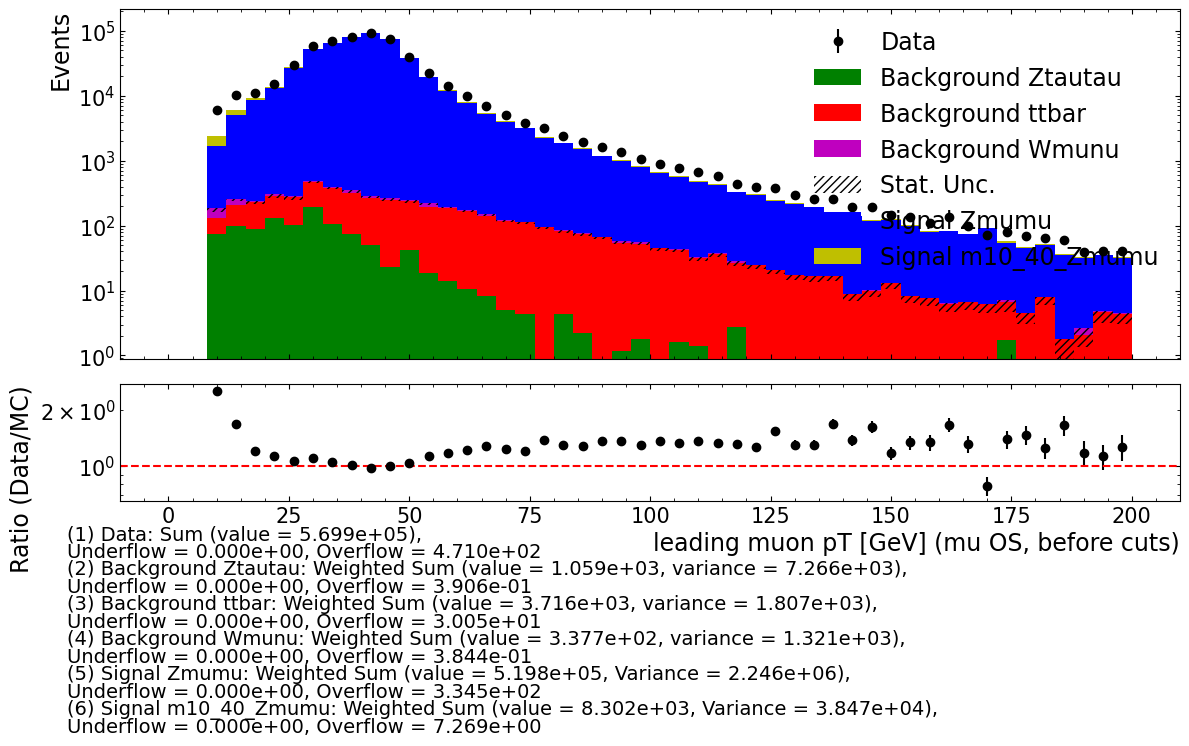

Elapsed time = 0.1s


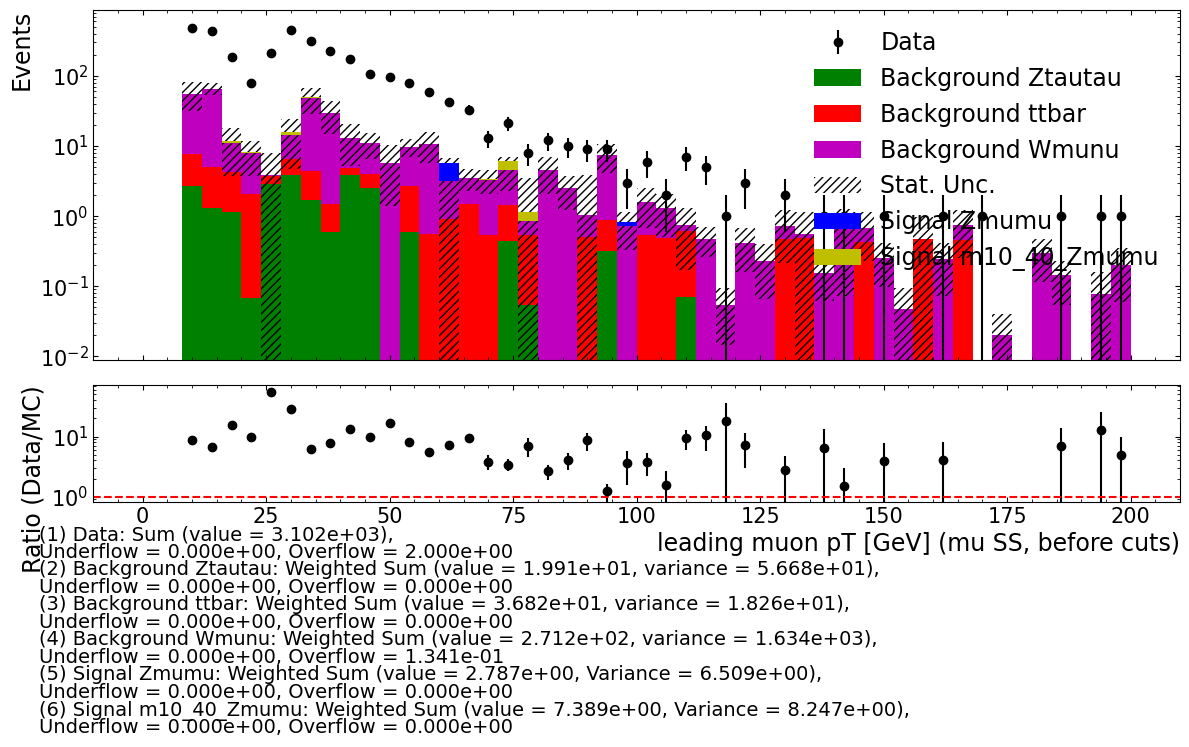

Elapsed time = 0.1s


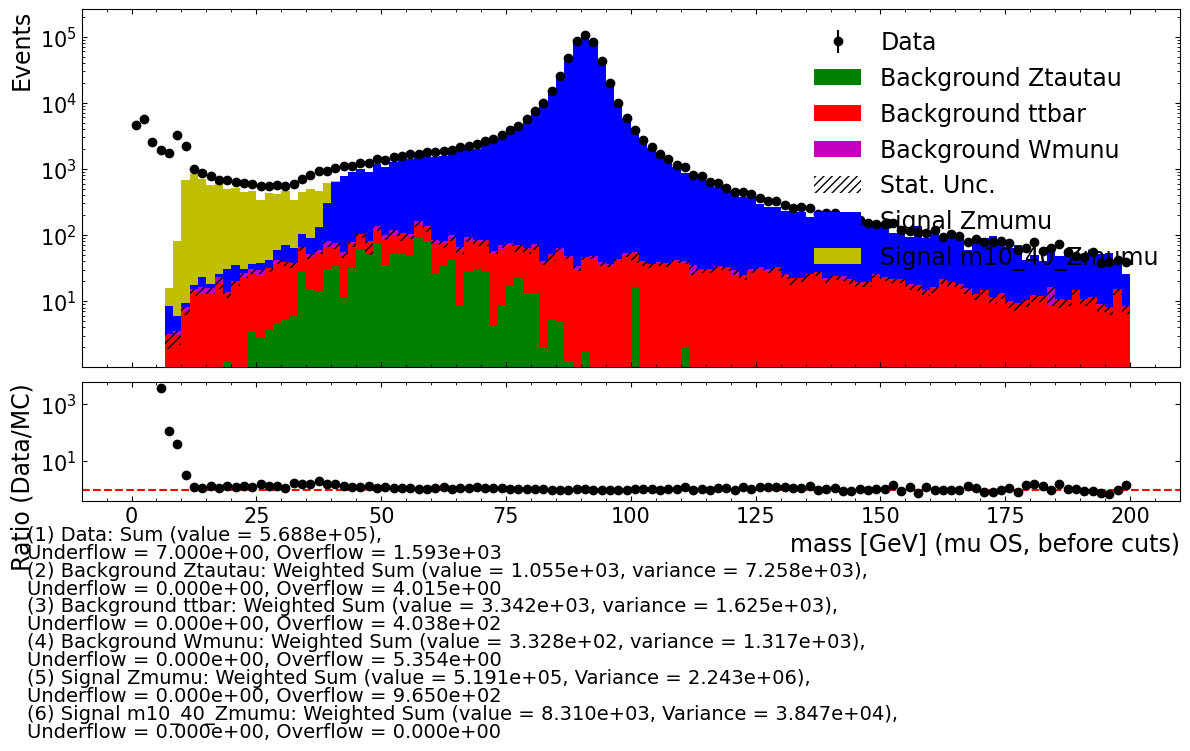

Elapsed time = 0.2s


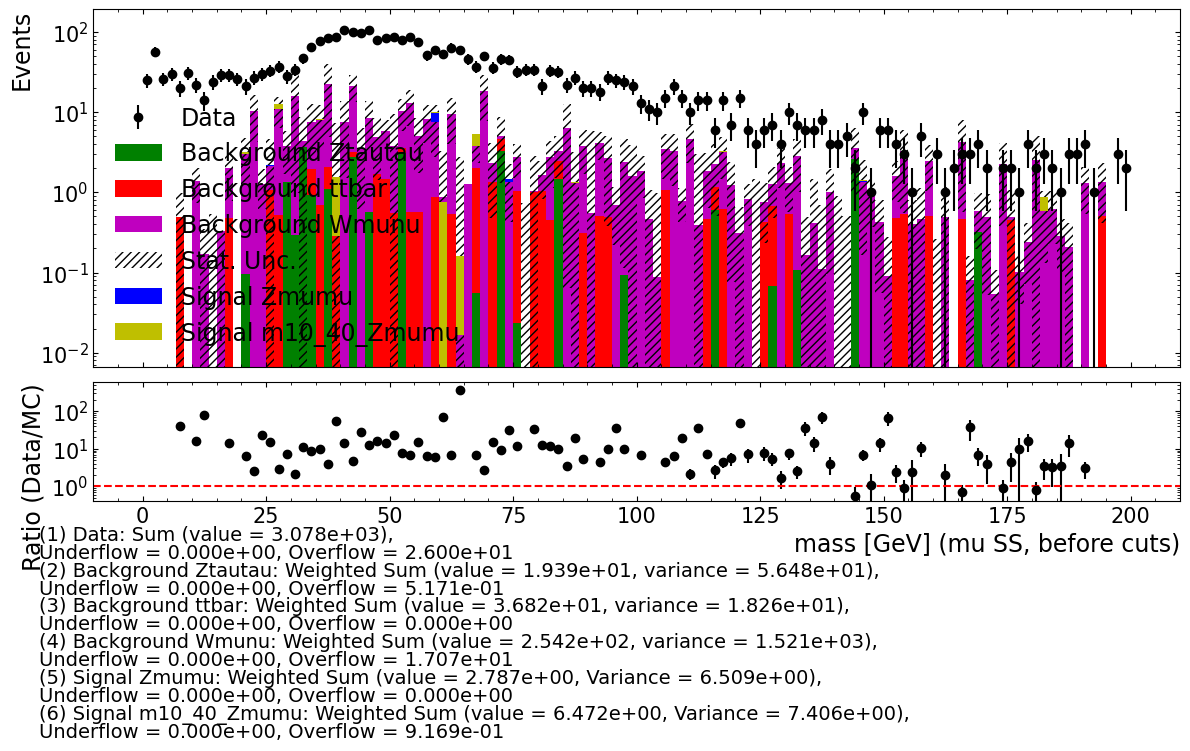

In [4]:
# -------------------------
# 7) BEFORE plots (OS & SS): leading pT and mass
# -------------------------

# pT (leading lepton)
plot_variable = "lep_pt[0]"
xmin, xmax = 0, 200
num_bins = 50

fig_os_pt, _ = plot_stacked_hist(
    plot_OS, plot_variable, color_list,
    num_bins, xmin, xmax, cfg["leading_label"] + f" ({LEPTON} OS, before cuts)",
    logy=True, show_text=True, residual_plot=True, save_fig=False
)

fig_ss_pt, _ = plot_stacked_hist(
    plot_SS, plot_variable, color_list,
    num_bins, xmin, xmax, cfg["leading_label"] + f" ({LEPTON} SS, before cuts)",
    logy=True, show_text=True, residual_plot=True, save_fig=False
)

# mass (full range)
plot_variable = "mass"
xmin, xmax = 0, 200
num_bins = 120

fig_os_mass_before, _ = plot_stacked_hist(
    plot_OS, plot_variable, color_list,
    num_bins, xmin, xmax, f"mass [GeV] ({LEPTON} OS, before cuts)",
    logy=True, show_text=True, residual_plot=True, save_fig=False
)

fig_ss_mass_before, _ = plot_stacked_hist(
    plot_SS, plot_variable, color_list,
    num_bins, xmin, xmax, f"mass [GeV] ({LEPTON} SS, before cuts)",
    logy=True, show_text=True, residual_plot=True, save_fig=False
)


In [5]:
# -------------------------
# 8) Selection utilities: mass window + ptcone + etcone
# -------------------------

def apply_selection(events,
                    mass_window=None,
                    ptcone_max=None,
                    etcone_max=None,
                    require_both=True):
    if events is None:
        return None

    mask = ak.Array(np.ones(len(events), dtype=bool))

    # mass window
    if mass_window is not None:
        lo, hi = mass_window
        mask = mask & (events["mass"] > lo) & (events["mass"] < hi)

    # ptcone (track iso)
    if ptcone_max is not None:
        if require_both:
            mask = mask & (events["lep_ptvarcone30"][:,0] < ptcone_max) & (events["lep_ptvarcone30"][:,1] < ptcone_max)
        else:
            mask = mask & (events["lep_ptvarcone30"][:,0] < ptcone_max)

    # etcone (calo iso)
    if etcone_max is not None:
        if require_both:
            mask = mask & (events["lep_topoetcone20"][:,0] < etcone_max) & (events["lep_topoetcone20"][:,1] < etcone_max)
        else:
            mask = mask & (events["lep_topoetcone20"][:,0] < etcone_max)

    return events[mask]

def select_plotdict(plot_dict, **kwargs):
    return {k: apply_selection(v, **kwargs) if v is not None else None for k,v in plot_dict.items()}

def yield_data(events):
    return 0.0 if events is None else float(len(events))

def yield_mc(events):
    if events is None:
        return 0.0
    # backend typically stores totalWeight for MC
    if "totalWeight" in events.fields:
        return float(ak.sum(events["totalWeight"]))
    return float(len(events))

def summarize(plot_dict):
    n_data = yield_data(plot_dict.get("Data"))
    n_sig = 0.0
    n_bkg = 0.0
    for k,v in plot_dict.items():
        if k.startswith("Signal"):
            n_sig += yield_mc(v)
        if k.startswith("Background"):
            n_bkg += yield_mc(v)
    n_mc = n_sig + n_bkg
    sb = n_sig/n_bkg if n_bkg>0 else np.inf
    dmc = n_data/n_mc if n_mc>0 else np.nan
    return n_data, n_sig, n_bkg, sb, dmc

def cutflow_table(plot_dict, mass_window, ptcone_max, etcone_max, require_both=True):
    steps = [
        ("Baseline", dict()),
        ("Mass window", dict(mass_window=mass_window)),
        ("Iso only", dict(ptcone_max=ptcone_max, etcone_max=etcone_max)),
        ("Mass + Iso", dict(mass_window=mass_window, ptcone_max=ptcone_max, etcone_max=etcone_max)),
    ]
    rows = []
    for name, kw in steps:
        dsel = select_plotdict(plot_dict, require_both=require_both, **kw)
        n_data, n_sig, n_bkg, sb, dmc = summarize(dsel)
        rows.append([name, n_data, n_sig, n_bkg, sb, dmc])
    return pd.DataFrame(rows, columns=["Step","Data","Signal","Background","S/B","Data/MC"])


In [6]:
# -------------------------
# 9) ISO scan (float range+step) in MASS_WINDOW
#    Metrics:
#      - OS signal efficiency (relative to "mass window only")
#      - SS data rejection   (relative to "mass window only")
# -------------------------

# reference yields inside mass window only (no iso)
os_ref = select_plotdict(plot_OS, mass_window=MASS_WINDOW, require_both=REQUIRE_BOTH_ISO)
ss_ref = select_plotdict(plot_SS, mass_window=MASS_WINDOW, require_both=REQUIRE_BOTH_ISO)

_, os_sig_ref, _, _, _ = summarize(os_ref)
ss_data_ref, _, _, _, _ = summarize(ss_ref)

pt_vals = np.arange(PTCONE_RANGE[0], PTCONE_RANGE[1] + 1e-12, PTCONE_STEP)
et_vals = np.arange(ETCONE_RANGE[0], ETCONE_RANGE[1] + 1e-12, ETCONE_STEP)

rows = []
for ptc in pt_vals:
    for etc in et_vals:
        os_sel = select_plotdict(plot_OS,
                                 mass_window=MASS_WINDOW,
                                 ptcone_max=float(ptc),
                                 etcone_max=float(etc),
                                 require_both=REQUIRE_BOTH_ISO)
        ss_sel = select_plotdict(plot_SS,
                                 mass_window=MASS_WINDOW,
                                 ptcone_max=float(ptc),
                                 etcone_max=float(etc),
                                 require_both=REQUIRE_BOTH_ISO)

        os_data, os_sig, os_bkg, os_sb, os_dmc = summarize(os_sel)
        ss_data, ss_sig, ss_bkg, ss_sb, ss_dmc = summarize(ss_sel)

        os_sig_eff = os_sig/os_sig_ref if os_sig_ref > 0 else np.nan
        ss_rej = 1.0 - (ss_data/ss_data_ref) if ss_data_ref > 0 else np.nan

        rows.append([float(ptc), float(etc), os_sig_eff, ss_rej, os_dmc, os_sb, ss_data])

df_scan = pd.DataFrame(
    rows,
    columns=["ptcone_max", "etcone_max", "OS_sig_eff", "SS_rejection", "OS_Data/MC", "OS_S/B", "SS_Data"]
)

# Keep only those that satisfy OS efficiency requirement
df_allowed = df_scan[df_scan["OS_sig_eff"] >= OS_SIG_EFF_MIN].copy()

print("Scan grid size =", len(df_scan), " | Allowed by eff >=", OS_SIG_EFF_MIN, ":", len(df_allowed))

# Pick "best" = maximize SS_rejection, tie-breaker: smaller (ptcone_max+etcone_max)
df_allowed["tightness"] = df_allowed["ptcone_max"] + df_allowed["etcone_max"]
df_allowed = df_allowed.sort_values(["SS_rejection", "tightness"], ascending=[False, True])

best = df_allowed.iloc[0] if len(df_allowed) > 0 else None
best


Scan grid size = 1681  | Allowed by eff >= 0.995 : 190


ptcone_max        4.500000
etcone_max        9.250000
OS_sig_eff        0.995349
SS_rejection      0.545093
OS_Data/MC        1.002575
OS_S/B          313.264241
SS_Data         343.000000
tightness        13.750000
Name: 775, dtype: float64

Best working point found: ptcone<4.500 GeV, etcone<9.250 GeV
Best metrics: {'ptcone_max': 4.5, 'etcone_max': 9.25, 'OS_sig_eff': 0.995349187822985, 'SS_rejection': 0.5450928381962865, 'OS_Data/MC': 1.0025752233255558, 'OS_S/B': 313.2642410788991, 'SS_Data': 343.0, 'tightness': 13.75}
Elapsed time = 0.3s


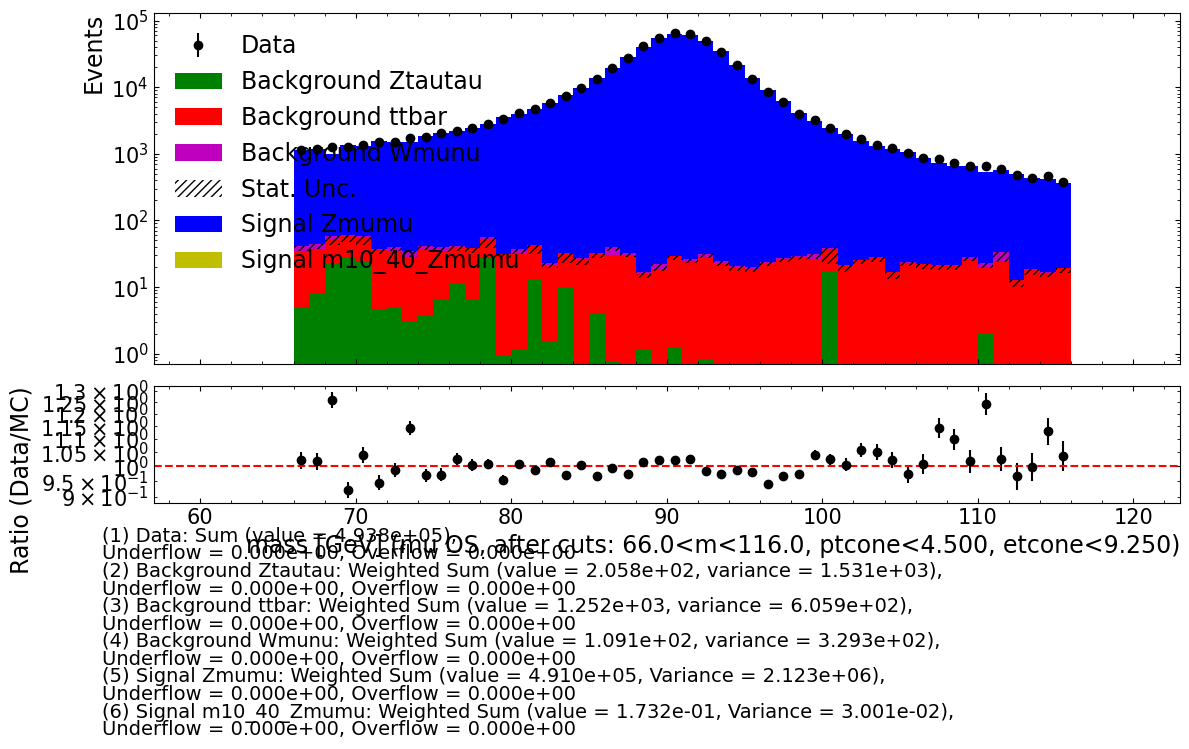

Elapsed time = 0.1s


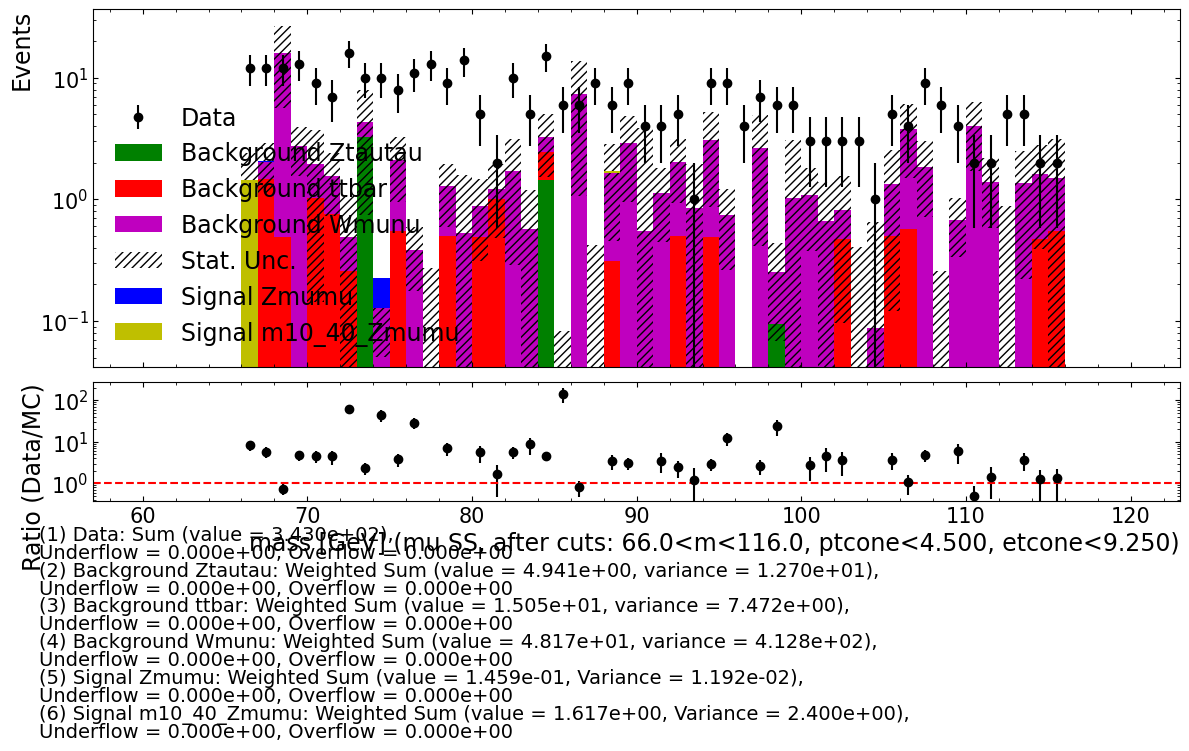


=== OS cutflow ===


Step      Data         Signal   Background         S/B   Data/MC
0     Baseline  570369.0  528405.637326  5143.182062  102.739050  1.069010
1  Mass window  502352.0  493269.408136  1579.983659  312.199057  1.015161
2     Iso only  541549.0  525999.646566  5104.958906  103.036999  1.019665
3   Mass + Iso  493811.0  490975.304766  1567.288060  313.264241  1.002575


=== SS cutflow ===


Step    Data     Signal  Background       S/B    Data/MC
0     Baseline  3104.0  10.176157  328.044943  0.031021   9.177429
1  Mass window   754.0   1.763342   71.767414  0.024570  10.254213
2     Iso only  1566.0  10.176157  322.146494  0.031589   4.712288
3   Mass + Iso   343.0   1.763342   68.158019  0.025871   4.905511

In [7]:
# -------------------------
# 10) Apply best cut, plot AFTER mass (OS & SS), and print cutflow
# -------------------------

if best is None:
    raise RuntimeError("No working point satisfies OS_SIG_EFF_MIN. Try loosening ranges or lowering OS_SIG_EFF_MIN.")

BEST_PTC = float(best["ptcone_max"])
BEST_ETC = float(best["etcone_max"])

print(f"Best working point found: ptcone<{BEST_PTC:.3f} GeV, etcone<{BEST_ETC:.3f} GeV")
print("Best metrics:", best.to_dict())

plot_OS_after = select_plotdict(
    plot_OS,
    mass_window=MASS_WINDOW,
    ptcone_max=BEST_PTC,
    etcone_max=BEST_ETC,
    require_both=REQUIRE_BOTH_ISO
)

plot_SS_after = select_plotdict(
    plot_SS,
    mass_window=MASS_WINDOW,
    ptcone_max=BEST_PTC,
    etcone_max=BEST_ETC,
    require_both=REQUIRE_BOTH_ISO
)

# AFTER mass plots (zoom into Z region for clarity)
plot_variable = "mass"
xmin, xmax = 60, 120
num_bins = 60

fig_os_mass_after, _ = plot_stacked_hist(
    plot_OS_after, plot_variable, color_list,
    num_bins, xmin, xmax,
    f"mass [GeV] ({LEPTON} OS, after cuts: {MASS_WINDOW[0]}<m<{MASS_WINDOW[1]}, ptcone<{BEST_PTC:.3f}, etcone<{BEST_ETC:.3f})",
    logy=True, show_text=True, residual_plot=True, save_fig=False
)

fig_ss_mass_after, _ = plot_stacked_hist(
    plot_SS_after, plot_variable, color_list,
    num_bins, xmin, xmax,
    f"mass [GeV] ({LEPTON} SS, after cuts: {MASS_WINDOW[0]}<m<{MASS_WINDOW[1]}, ptcone<{BEST_PTC:.3f}, etcone<{BEST_ETC:.3f})",
    logy=True, show_text=True, residual_plot=True, save_fig=False
)

# Print analysis summary (before vs after) with cutflow tables
df_os_cutflow = cutflow_table(plot_OS, MASS_WINDOW, BEST_PTC, BEST_ETC, require_both=REQUIRE_BOTH_ISO)
df_ss_cutflow = cutflow_table(plot_SS, MASS_WINDOW, BEST_PTC, BEST_ETC, require_both=REQUIRE_BOTH_ISO)

print("\n=== OS cutflow ===")
display(df_os_cutflow)

print("\n=== SS cutflow ===")
display(df_ss_cutflow)


Use LEPTON = "e"
to get eletron plots

## The Cross-section

In [15]:
# =========================
# 11) Cross section for Z -> ll (cut-and-count)
#     outputs: sigma ± stat ± syst ± lumi
# =========================

import math, re, io, contextlib
import numpy as np
import awkward as ak

# ---- Script values ----
LUMI_FB = 30.6          # integrated luminosity of provided ATLAS datasets (script)  [fb^-1]
LUMI_REL_UNC = 0.017    # 1.7% lumi uncertainty (script)

LUMI_PB = LUMI_FB * 1000.0  # convert to pb^-1

def _weight_field(events):
    if events is None:
        return None
    for cand in ["weight", "totalWeight"]:
        if cand in events.fields:
            return cand
    return None

def sum_w(events):
    if events is None:
        return 0.0
    wf = _weight_field(events)
    if wf is None:
        return float(len(events))
    return float(ak.sum(events[wf]))

def sum_w2(events):
    if events is None:
        return 0.0
    wf = _weight_field(events)
    if wf is None:
        return float(len(events))
    w = events[wf]
    return float(ak.sum(w * w))

def produced_sumw(sample_key, lumi_fb):
    """
    produced_event_count() prints the number, so we capture stdout and parse it.
    """
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        produced_event_count(sample_key, lumi_fb)
    txt = buf.getvalue().strip()
    # usually ends with "... is 81299580"
    m = re.search(r"([0-9]+)\s*$", txt)
    if not m:
        raise RuntimeError(f"Could not parse produced_event_count output:\n{txt}")
    return float(m.group(1))

def compute_sigma_for_cuts(plot_dict_os, mass_window, ptcone_max, etcone_max, require_both=True):
    """
    Returns a dict with yields, epsilon, sigma and stat error.
    Background definition: everything except Data and the PRIMARY signal (Zee or Zmumu).
    """
    # Primary signal process (what cross section you measure)
    primary_signal = cfg["signals"][0]          # "Zmumu" or "Zee"
    primary_key = f"Signal {primary_signal}"

    # Apply selections to OS plot_dict
    sel = select_plotdict(
        plot_dict_os,
        mass_window=mass_window,
        ptcone_max=ptcone_max,
        etcone_max=etcone_max,
        require_both=require_both
    )

    # Data selected (unweighted count)
    data_events = sel["Data"]
    N_selected = float(len(data_events))

    # Background estimate (weighted)
    N_bkg = 0.0
    Var_bkg = 0.0
    for k, v in sel.items():
        if k == "Data":
            continue
        if k == primary_key:
            continue
        # treat other MC components as background (including low-mass DY sample)
        N_bkg += sum_w(v)
        Var_bkg += sum_w2(v)

    # Signal in data after bkg subtraction
    N_sig_data = N_selected - N_bkg

    # Efficiency epsilon from primary signal MC only
    W_sig_pass = sum_w(sel.get(primary_key))
    W_sig_total = produced_sumw(primary_signal, LUMI_FB)
    epsilon = W_sig_pass / W_sig_total

    # Cross section (pb)
    sigma_pb = N_sig_data / (epsilon * LUMI_PB)

    # Statistical uncertainty (simple: data Poisson + MC bkg stat)
    dN_data = math.sqrt(N_selected)
    dN_bkg = math.sqrt(Var_bkg)
    dN_sig = math.sqrt(dN_data**2 + dN_bkg**2)
    dsigma_stat_pb = dN_sig / (epsilon * LUMI_PB)

    return {
        "primary_signal": primary_signal,
        "N_selected": N_selected,
        "N_bkg": N_bkg,
        "N_sig_data": N_sig_data,
        "W_sig_pass": W_sig_pass,
        "W_sig_total": W_sig_total,
        "epsilon": epsilon,
        "sigma_pb": sigma_pb,
        "dsigma_stat_pb": dsigma_stat_pb,
    }

# ---- Nominal result (your best cuts) ----
nom = compute_sigma_for_cuts(
    plot_OS,
    mass_window=MASS_WINDOW,
    ptcone_max=BEST_PTC,
    etcone_max=BEST_ETC,
    require_both=REQUIRE_BOTH_ISO
)

print("\n=== Nominal cross section inputs ===")
for k in ["primary_signal","N_selected","N_bkg","N_sig_data","epsilon"]:
    print(f"{k:>12s} : {nom[k]}")

print("\n=== Nominal cross section ===")
sigma = nom["sigma_pb"]
ds_stat = nom["dsigma_stat_pb"]
ds_lumi = LUMI_REL_UNC * sigma

print(f"sigma(pp -> {nom['primary_signal']} -> ll) = {sigma:.3f} pb")
print(f"  stat  : ± {ds_stat:.3f} pb")
print(f"  lumi  : ± {ds_lumi:.3f} pb  ({LUMI_REL_UNC*100:.1f}%)")

# ---- Systematic estimate: "catch-all" by varying cuts (script suggestion) ----
# (You can change the variation sizes if you want)
variations = [
    ("ptcone -0.5", MASS_WINDOW, max(BEST_PTC - 0.5, 0.0), BEST_ETC, REQUIRE_BOTH_ISO),
    ("ptcone +0.5", MASS_WINDOW, BEST_PTC + 0.5,          BEST_ETC, REQUIRE_BOTH_ISO),
    ("etcone -0.5", MASS_WINDOW, BEST_PTC, max(BEST_ETC - 0.5, 0.0), REQUIRE_BOTH_ISO),
    ("etcone +0.5", MASS_WINDOW, BEST_PTC, BEST_ETC + 0.5,          REQUIRE_BOTH_ISO),

    # optional: slightly shift mass window edges (treat as a selection-variation systematic)
    ("mass window tighter", (MASS_WINDOW[0]+2.0, MASS_WINDOW[1]-2.0), BEST_PTC, BEST_ETC, REQUIRE_BOTH_ISO),
    ("mass window looser",  (MASS_WINDOW[0]-2.0, MASS_WINDOW[1]+2.0), BEST_PTC, BEST_ETC, REQUIRE_BOTH_ISO),

    # optional: iso on leading lepton only
    ("iso leading only", MASS_WINDOW, BEST_PTC, BEST_ETC, False),
]

sigmas = []
print("\n=== Variations for systematic estimate ===")
for name, mw, ptc, etc, both in variations:
    out = compute_sigma_for_cuts(plot_OS, mw, ptc, etc, both)
    sigmas.append((name, out["sigma_pb"]))
    print(f"{name:>18s} : sigma = {out['sigma_pb']:.3f} pb  |  (mw={mw}, ptc<{ptc:.3f}, etc<{etc:.3f}, both={both})")

syst = max(abs(s - sigma) for _, s in sigmas) if len(sigmas) else 0.0

print("\n=== Final result to write in lab book ===")
print(f"sigma = {sigma:.3f} ± {ds_stat:.3f} (stat.) ± {syst:.3f} (syst.) ± {ds_lumi:.3f} (lumi.) pb")
print(f"      = {sigma/1000.0:.4f} ± {ds_stat/1000.0:.4f} ± {syst/1000.0:.4f} ± {ds_lumi/1000.0:.4f} nb")


=== Nominal cross section inputs ===
primary_signal : Zmumu
  N_selected : 493811.0
       N_bkg : 1567.4613008956353
  N_sig_data : 492243.5386991044
     epsilon : 0.007223220158795735

=== Nominal cross section ===
sigma(pp -> Zmumu -> ll) = 2227.039 pb
  stat  : ± 3.187 pb
  lumi  : ± 37.860 pb  (1.7%)

=== Variations for systematic estimate ===
       ptcone -0.5 : sigma = 2225.230 pb  |  (mw=(66.0, 116.0), ptc<4.000, etc<9.250, both=True)
       ptcone +0.5 : sigma = 2229.070 pb  |  (mw=(66.0, 116.0), ptc<5.000, etc<9.250, both=True)
       etcone -0.5 : sigma = 2227.169 pb  |  (mw=(66.0, 116.0), ptc<4.500, etc<8.750, both=True)
       etcone +0.5 : sigma = 2227.637 pb  |  (mw=(66.0, 116.0), ptc<4.500, etc<9.750, both=True)
mass window tighter : sigma = 2226.553 pb  |  (mw=(68.0, 114.0), ptc<4.500, etc<9.250, both=True)
mass window looser : sigma = 2226.197 pb  |  (mw=(64.0, 118.0), ptc<4.500, etc<9.250, both=True)
  iso leading only : sigma = 2241.585 pb  |  (mw=(66.0, 116.0), 